<a href="https://colab.research.google.com/github/sepstein22/computational_brain/blob/main/Copy_of_Neural_Engineering_Term_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Neural Engineering Term Project - Topic: Project 1: tACS & Attention**



#### **Team**: Sophia Epstein, Reem Fashho, Tarik Can Ozden, Lucy ShuangShuang

**Subjects**

**s04**: Sophia Epstein  (Session 1: Active, Session 2: Sham)

**s05**: Reem Fashho     (Session 1: Active, Session 2: Sham)

**s06**: Lucy Zhu        (Session 1: Active, Session 2: Sham)

**s07**: Tarik Can Ozden (Session 1: Sham, Session 2: Active)

**Imports**

In [3]:
!pip install mne
!pip install scipy
!pip install pymatreader
!pip install pyprep
!pip install neurokit2
!pip install asrpy -q
!pip install -U autoreject

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.9 MB/s eta 0:00:00


In [4]:
from datetime import datetime
from difflib import get_close_matches
from google.colab import drive
from mne.preprocessing import ICA
from scipy import signal

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

import copy
import mne
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import re
import sklearn.metrics as metrics
import statistics
import scipy.stats as stats
import warnings
import pyprep
import neurokit2 as nk

from asrpy import ASR
from autoreject import AutoReject



### **Data Loading**

#### General Loading

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
parent_path = '/content/drive/MyDrive/ECE 385J Team Project/Project Code & Data'

In [7]:
# Session 1
subject_4_session1_path = parent_path + "/s04/session_1"
subject_5_session1_path = parent_path + "/s05/session_1"
subject_6_session1_path = parent_path + "/s06/session_1"
subject_7_session1_path = parent_path + "/s07/session_1"

subject_4_session1_pre_tACS_path = subject_4_session1_path + "/pre_tACS"
subject_5_session1_pre_tACS_path = subject_5_session1_path + "/pre_tACS"
subject_6_session1_pre_tACS_path = subject_6_session1_path + "/pre_tACS"
subject_7_session1_pre_tACS_path = subject_7_session1_path + "/pre_tACS"

subject_4_session1_post_tACS_path = subject_4_session1_path + "/post_tACS"
subject_5_session1_post_tACS_path = subject_5_session1_path + "/post_tACS"
subject_6_session1_post_tACS_path = subject_6_session1_path + "/post_tACS"
subject_7_session1_post_tACS_path = subject_7_session1_path + "/post_tACS"

In [8]:
# Session 2
subject_4_session2_path = parent_path + "/s04/session_2"
subject_5_session2_path = parent_path + "/s05/session_2"
subject_6_session2_path = parent_path + "/s06/session_2"
subject_7_session2_path = parent_path + "/s07/session_2"

subject_4_session2_pre_tACS_path = subject_4_session2_path + "/pre_tACS"
subject_5_session2_pre_tACS_path = subject_5_session2_path + "/pre_tACS"
subject_6_session2_pre_tACS_path = subject_6_session2_path + "/pre_tACS"
subject_7_session2_pre_tACS_path = subject_7_session2_path + "/pre_tACS"

subject_4_session2_post_tACS_path = subject_4_session2_path + "/post_tACS"
subject_5_session2_post_tACS_path = subject_5_session2_path + "/post_tACS"
subject_6_session2_post_tACS_path = subject_6_session2_path + "/post_tACS"
subject_7_session2_post_tACS_path = subject_7_session2_path + "/post_tACS"

#### Behavioral Loading

**Extract Tasks per Subject**

• Eyes Opened Task (EO) - a resting state task with eyes opened.

• Single Task 1 (ST1) - a visual search task.

• Single Task 2 (ST2) - a walking task.

• Dual Task (DT) - visual search and walking tasks at the same time.

Depending of the position of the ”T”, the answer can be right (900/90) or wrong
(901/91).

The end of each trial (after button press or time out) is preceded by 2 seconds of an empty screen. Then, the feedback is held for 2 seconds, either for right (800/80), wrong (801/81) or time out (802/82) answers, before entering an empty screen of 1 second.

In [9]:
def extract_hits(sXX_s01_rXX_type_file_name:str):
  """Function parses through ST1 of DT trigger text file and returns count of hits in a session"""
  with open(sXX_s01_rXX_type_file_name, "r") as file:
      lines = file.readlines()
  count_correct = 0
  for line in lines:
      if "[900]" in line: # Hit Trigger = 900
          count_correct += 1
  return count_correct

In [10]:
# ST1 and DT: 5 to 6 minutes of recordings, with 30 trials per run.
trials_per_run = 30

In [11]:
# Session 1 - Pre tACS Correct/Incorrect Count per DT Runs and ST1 Runs

# Subject 4
s04_s01_r01_pre_tACS_ST1_correct = extract_hits(subject_4_session1_pre_tACS_path + '/s04_s01_r01_ST1_triggers.txt')
s04_s01_r02_pre_tACS_ST1_correct = extract_hits(subject_4_session1_pre_tACS_path + '/s04_s01_r02_ST1_triggers.txt')
s04_s01_r01_pre_tACS_DT_correct = extract_hits(subject_4_session1_pre_tACS_path + '/s04_s01_r01_DT_triggers.txt')
s04_s01_r02_pre_tACS_DT_correct = extract_hits(subject_4_session1_pre_tACS_path + '/s04_s01_r02_DT_triggers.txt')

# Subject 5
s05_s01_r01_pre_tACS_ST1_correct = extract_hits(subject_5_session1_pre_tACS_path + '/s05_s01_r01_ST1_triggers.txt')
s05_s01_r02_pre_tACS_ST1_correct = extract_hits(subject_5_session1_pre_tACS_path + '/s05_s01_r02_ST1_triggers.txt')
s05_s01_r01_pre_tACS_DT_correct = extract_hits(subject_5_session1_pre_tACS_path + '/s05_s01_r01_DT_triggers.txt')
s05_s01_r02_pre_tACS_DT_correct = extract_hits(subject_5_session1_pre_tACS_path + '/s05_s01_r02_DT_triggers.txt')

# Subject 6
s06_s01_r01_pre_tACS_ST1_correct = extract_hits(subject_6_session1_pre_tACS_path + '/s06_s01_r01_ST1_triggers.txt')
s06_s01_r02_pre_tACS_ST1_correct = extract_hits(subject_6_session1_pre_tACS_path + '/s06_s01_r02_ST1_triggers.txt')
s06_s01_r01_pre_tACS_DT_correct = extract_hits(subject_6_session1_pre_tACS_path + '/s06_s01_r01_DT_triggers.txt')
s06_s01_r02_pre_tACS_DT_correct = extract_hits(subject_6_session1_pre_tACS_path + '/s06_s01_r02_DT_triggers.txt')

# Subject 7
s07_s01_r01_pre_tACS_ST1_correct = extract_hits(subject_7_session1_pre_tACS_path + '/s07_s01_r01_ST1_triggers.txt')
s07_s01_r02_pre_tACS_ST1_correct = extract_hits(subject_7_session1_pre_tACS_path + '/s07_s01_r02_ST1_triggers.txt')
s07_s01_r01_pre_tACS_DT_correct = extract_hits(subject_7_session1_pre_tACS_path + '/s07_s01_r01_DT_triggers.txt')
s07_s01_r02_pre_tACS_DT_correct = extract_hits(subject_7_session1_pre_tACS_path + '/s07_s01_r02_DT_triggers.txt')

In [12]:
# Session 1 - Post tACS Correct/Incorrect Count per DT Runs and ST1 Runs

# Subject 4
s04_s01_r03_post_tACS_ST1_correct = extract_hits(subject_4_session1_post_tACS_path + '/s04_s01_r03_ST1_triggers.txt')
s04_s01_r04_post_tACS_ST1_correct = extract_hits(subject_4_session1_post_tACS_path + '/s04_s01_r04_ST1_triggers.txt')
s04_s01_r03_post_tACS_DT_correct = extract_hits(subject_4_session1_post_tACS_path + '/s04_s01_r03_DT_triggers.txt')
s04_s01_r04_post_tACS_DT_correct = extract_hits(subject_4_session1_post_tACS_path + '/s04_s01_r04_DT_triggers.txt')

# Subject 5
s05_s01_r03_post_tACS_ST1_correct = extract_hits(subject_5_session1_post_tACS_path + '/s05_s01_r03_ST1_triggers.txt')
s05_s01_r04_post_tACS_ST1_correct = extract_hits(subject_5_session1_post_tACS_path + '/s05_s01_r04_ST1_triggers.txt')
s05_s01_r03_post_tACS_DT_correct = extract_hits(subject_5_session1_post_tACS_path + '/s05_s01_r03_DT_triggers.txt')
s05_s01_r04_post_tACS_DT_correct = extract_hits(subject_5_session1_post_tACS_path + '/s05_s01_r04_DT_triggers.txt')

# Subject 6
s06_s01_r03_post_tACS_ST1_correct = extract_hits(subject_6_session1_post_tACS_path + '/s06_s01_r03_ST1_triggers.txt')
s06_s01_r04_post_tACS_ST1_correct = extract_hits(subject_6_session1_post_tACS_path + '/s06_s01_r04_ST1_triggers.txt')
s06_s01_r03_post_tACS_DT_correct = extract_hits(subject_6_session1_post_tACS_path + '/s06_s01_r03_DT_triggers.txt')
s06_s01_r04_post_tACS_DT_correct = extract_hits(subject_6_session1_post_tACS_path + '/s06_s01_r04_DT_triggers.txt')

# Subject 7
s07_s01_r03_post_tACS_ST1_correct = extract_hits(subject_7_session1_post_tACS_path + '/s07_s01_r03_ST1_triggers.txt')
s07_s01_r04_post_tACS_ST1_correct = extract_hits(subject_7_session1_post_tACS_path + '/s07_s01_r04_ST1_triggers.txt')
s07_s01_r03_post_tACS_DT_correct = extract_hits(subject_7_session1_post_tACS_path + '/s07_s01_r03_DT_triggers.txt')
s07_s01_r04_post_tACS_DT_correct = extract_hits(subject_7_session1_post_tACS_path + '/s07_s01_r04_DT_triggers.txt')

In [13]:
# Session 2 - Pre tACS Correct/Incorrect Count per DT Runs and ST1 Runs

# Subject 4
s04_s02_r01_pre_tACS_ST1_correct = extract_hits(subject_4_session2_pre_tACS_path + '/s04_s02_r01_ST1_triggers.txt')
s04_s02_r02_pre_tACS_ST1_correct = extract_hits(subject_4_session2_pre_tACS_path + '/s04_s02_r02_ST1_triggers.txt')
s04_s02_r01_pre_tACS_DT_correct = extract_hits(subject_4_session2_pre_tACS_path + '/s04_s02_r01_DT_triggers.txt')
s04_s02_r02_pre_tACS_DT_correct = extract_hits(subject_4_session2_pre_tACS_path + '/s04_s02_r02_DT_triggers.txt')

# Subject 5
s05_s02_r01_pre_tACS_ST1_correct = extract_hits(subject_5_session2_pre_tACS_path + '/s05_s02_r01_ST1_triggers.txt')
s05_s02_r02_pre_tACS_ST1_correct = extract_hits(subject_5_session2_pre_tACS_path + '/s05_s02_r02_ST1_triggers.txt')
s05_s02_r01_pre_tACS_DT_correct = extract_hits(subject_5_session2_pre_tACS_path + '/s05_s02_r01_DT_triggers.txt')
s05_s02_r02_pre_tACS_DT_correct = extract_hits(subject_5_session2_pre_tACS_path + '/s05_s02_r02_DT_triggers.txt')

# Subject 6
s06_s02_r01_pre_tACS_ST1_correct = extract_hits(subject_6_session2_pre_tACS_path + '/s06_s02_r01_ST1_triggers.txt')
s06_s02_r02_pre_tACS_ST1_correct = extract_hits(subject_6_session2_pre_tACS_path + '/s06_s02_r02_ST1_triggers.txt')
s06_s02_r01_pre_tACS_DT_correct = extract_hits(subject_6_session2_pre_tACS_path + '/s06_s02_r01_DT_triggers.txt')
s06_s02_r02_pre_tACS_DT_correct = extract_hits(subject_6_session2_pre_tACS_path + '/s06_s02_r02_DT_triggers.txt')

# Subject 7
s07_s02_r01_pre_tACS_ST1_correct = extract_hits(subject_7_session2_pre_tACS_path + '/s07_s02_r01_ST1_triggers.txt')
s07_s02_r02_pre_tACS_ST1_correct = extract_hits(subject_7_session2_pre_tACS_path + '/s07_s02_r02_ST1_triggers.txt')
s07_s02_r01_pre_tACS_DT_correct = extract_hits(subject_7_session2_pre_tACS_path + '/s07_s02_r01_DT_triggers.txt')
s07_s02_r02_pre_tACS_DT_correct = extract_hits(subject_7_session2_pre_tACS_path + '/s07_s02_r02_DT_triggers.txt')

In [14]:
# Session 2 - Post tACS Correct/Incorrect Count per DT Runs and ST1 Runs

# Subject 4
s04_s02_r03_post_tACS_ST1_correct = extract_hits(subject_4_session2_post_tACS_path + '/s04_s02_r03_ST1_triggers.txt')
s04_s02_r04_post_tACS_ST1_correct = extract_hits(subject_4_session2_post_tACS_path + '/s04_s02_r04_ST1_triggers.txt')
s04_s02_r03_post_tACS_DT_correct = extract_hits(subject_4_session2_post_tACS_path + '/s04_s02_r03_DT_triggers.txt')
s04_s02_r04_post_tACS_DT_correct = extract_hits(subject_4_session2_post_tACS_path + '/s04_s02_r04_DT_triggers.txt')

# Subject 5
s05_s02_r03_post_tACS_ST1_correct = extract_hits(subject_5_session2_post_tACS_path + '/s05_s02_r03_ST1_triggers.txt')
s05_s02_r04_post_tACS_ST1_correct = extract_hits(subject_5_session2_post_tACS_path + '/s05_s02_r04_ST1_triggers.txt')
s05_s02_r03_post_tACS_DT_correct = extract_hits(subject_5_session2_post_tACS_path + '/s05_s02_r03_DT_triggers.txt')
s05_s02_r04_post_tACS_DT_correct = extract_hits(subject_5_session2_post_tACS_path + '/s05_s02_r04_DT_triggers.txt')

# Subject 6
s06_s02_r03_post_tACS_ST1_correct = extract_hits(subject_6_session2_post_tACS_path + '/s06_s02_r03_ST1_triggers.txt')
s06_s02_r04_post_tACS_ST1_correct = extract_hits(subject_6_session2_post_tACS_path + '/s06_s02_r04_ST1_triggers.txt')
s06_s02_r03_post_tACS_DT_correct = extract_hits(subject_6_session2_post_tACS_path + '/s06_s02_r03_DT_triggers.txt')
s06_s02_r04_post_tACS_DT_correct = extract_hits(subject_6_session2_post_tACS_path + '/s06_s02_r04_DT_triggers.txt')

# Subject 7
s07_s02_r03_post_tACS_ST1_correct = extract_hits(subject_7_session2_post_tACS_path + '/s07_s02_r03_ST1_triggers.txt')
s07_s02_r04_post_tACS_ST1_correct = extract_hits(subject_7_session2_post_tACS_path + '/s07_s02_r04_ST1_triggers.txt')
s07_s02_r03_post_tACS_DT_correct = extract_hits(subject_7_session2_post_tACS_path + '/s07_s02_r03_DT_triggers.txt')
s07_s02_r04_post_tACS_DT_correct = extract_hits(subject_7_session2_post_tACS_path + '/s07_s02_r04_DT_triggers.txt')

In [15]:
# Data Structure to Store Accuracy Across Subjects Across Runs
# Pre-tACS Runs = 1,2
# Post-tACS Runs = 3,4

#      | ST1 Rn | ST1 Rn+1 | DT Rn | DT Rn+1
#  s04 |
#  s05 |
#  s06 |
#  s07 |

In [16]:
# Session 1 - Pre-tACS Accuracy
s04_s01_pre_tACS_runs_accuracy = np.array([s04_s01_r01_pre_tACS_ST1_correct/trials_per_run, s04_s01_r02_pre_tACS_ST1_correct/trials_per_run, s04_s01_r01_pre_tACS_DT_correct/trials_per_run, s04_s01_r02_pre_tACS_DT_correct/trials_per_run])
s05_s01_pre_tACS_runs_accuracy = np.array([s05_s01_r01_pre_tACS_ST1_correct/trials_per_run, s05_s01_r02_pre_tACS_ST1_correct/trials_per_run, s05_s01_r01_pre_tACS_DT_correct/trials_per_run, s05_s01_r02_pre_tACS_DT_correct/trials_per_run])
s06_s01_pre_tACS_runs_accuracy = np.array([s06_s01_r01_pre_tACS_ST1_correct/trials_per_run, s06_s01_r02_pre_tACS_ST1_correct/trials_per_run, s06_s01_r01_pre_tACS_DT_correct/trials_per_run, s06_s01_r02_pre_tACS_DT_correct/trials_per_run])
s07_s01_pre_tACS_runs_accuracy = np.array([s07_s01_r01_pre_tACS_ST1_correct/trials_per_run, s07_s01_r02_pre_tACS_ST1_correct/trials_per_run, s07_s01_r01_pre_tACS_DT_correct/trials_per_run, s07_s01_r02_pre_tACS_DT_correct/trials_per_run])

s0N_s01_pre_tACS_runs_accuracy = np.array([s04_s01_pre_tACS_runs_accuracy, s05_s01_pre_tACS_runs_accuracy, s06_s01_pre_tACS_runs_accuracy, s07_s01_pre_tACS_runs_accuracy])

In [17]:
# Session 1 - Post-tACS Accuracy
s04_s01_post_tACS_runs_accuracy = np.array([s04_s01_r03_post_tACS_ST1_correct/trials_per_run, s04_s01_r04_post_tACS_ST1_correct/trials_per_run, s04_s01_r03_post_tACS_DT_correct/trials_per_run, s04_s01_r04_post_tACS_DT_correct/trials_per_run])
s05_s01_post_tACS_runs_accuracy = np.array([s05_s01_r03_post_tACS_ST1_correct/trials_per_run, s05_s01_r04_post_tACS_ST1_correct/trials_per_run, s05_s01_r03_post_tACS_DT_correct/trials_per_run, s05_s01_r04_post_tACS_DT_correct/trials_per_run])
s06_s01_post_tACS_runs_accuracy = np.array([s06_s01_r03_post_tACS_ST1_correct/trials_per_run, s06_s01_r04_post_tACS_ST1_correct/trials_per_run, s06_s01_r03_post_tACS_DT_correct/trials_per_run, s06_s01_r04_post_tACS_DT_correct/trials_per_run])
s07_s01_post_tACS_runs_accuracy = np.array([s07_s01_r03_post_tACS_ST1_correct/trials_per_run, s07_s01_r04_post_tACS_ST1_correct/trials_per_run, s07_s01_r03_post_tACS_DT_correct/trials_per_run, s07_s01_r04_post_tACS_DT_correct/trials_per_run])

s0N_s01_post_tACS_runs_accuracy = np.array([s04_s01_post_tACS_runs_accuracy, s05_s01_post_tACS_runs_accuracy, s06_s01_post_tACS_runs_accuracy, s07_s01_post_tACS_runs_accuracy])

In [18]:
# Session 2 - Pre-tACS Accuracy
s04_s02_pre_tACS_runs_accuracy = np.array([s04_s02_r01_pre_tACS_ST1_correct/trials_per_run, s04_s02_r02_pre_tACS_ST1_correct/trials_per_run, s04_s02_r01_pre_tACS_DT_correct/trials_per_run, s04_s02_r02_pre_tACS_DT_correct/trials_per_run])
s05_s02_pre_tACS_runs_accuracy = np.array([s05_s02_r01_pre_tACS_ST1_correct/trials_per_run, s05_s02_r02_pre_tACS_ST1_correct/trials_per_run, s05_s02_r01_pre_tACS_DT_correct/trials_per_run, s05_s02_r02_pre_tACS_DT_correct/trials_per_run])
s06_s02_pre_tACS_runs_accuracy = np.array([s06_s02_r01_pre_tACS_ST1_correct/trials_per_run, s06_s02_r02_pre_tACS_ST1_correct/trials_per_run, s06_s02_r01_pre_tACS_DT_correct/trials_per_run, s06_s02_r02_pre_tACS_DT_correct/trials_per_run])
s07_s02_pre_tACS_runs_accuracy = np.array([s07_s02_r01_pre_tACS_ST1_correct/trials_per_run, s07_s02_r02_pre_tACS_ST1_correct/trials_per_run, s07_s02_r01_pre_tACS_DT_correct/trials_per_run, s07_s02_r02_pre_tACS_DT_correct/trials_per_run])

s0N_s02_pre_tACS_runs_accuracy = np.array([s04_s02_pre_tACS_runs_accuracy, s05_s02_pre_tACS_runs_accuracy, s06_s02_pre_tACS_runs_accuracy, s07_s02_pre_tACS_runs_accuracy])

In [19]:
# Session 2 - Post-tACS Accuracy
s04_s02_post_tACS_runs_accuracy = np.array([s04_s02_r03_post_tACS_ST1_correct/trials_per_run, s04_s02_r04_post_tACS_ST1_correct/trials_per_run, s04_s02_r03_post_tACS_DT_correct/trials_per_run, s04_s02_r04_post_tACS_DT_correct/trials_per_run])
s05_s02_post_tACS_runs_accuracy = np.array([s05_s02_r03_post_tACS_ST1_correct/trials_per_run, s05_s02_r04_post_tACS_ST1_correct/trials_per_run, s05_s02_r03_post_tACS_DT_correct/trials_per_run, s05_s02_r04_post_tACS_DT_correct/trials_per_run])
s06_s02_post_tACS_runs_accuracy = np.array([s06_s02_r03_post_tACS_ST1_correct/trials_per_run, s06_s02_r04_post_tACS_ST1_correct/trials_per_run, s06_s02_r03_post_tACS_DT_correct/trials_per_run, s06_s02_r04_post_tACS_DT_correct/trials_per_run])
s07_s02_post_tACS_runs_accuracy = np.array([s07_s02_r03_post_tACS_ST1_correct/trials_per_run, s07_s02_r04_post_tACS_ST1_correct/trials_per_run, s07_s02_r03_post_tACS_DT_correct/trials_per_run, s07_s02_r04_post_tACS_DT_correct/trials_per_run])

s0N_s02_post_tACS_runs_accuracy = np.array([s04_s02_post_tACS_runs_accuracy, s05_s02_post_tACS_runs_accuracy, s06_s02_post_tACS_runs_accuracy, s07_s02_post_tACS_runs_accuracy])

In [20]:
# Reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
def display_accuracies(s0N_s0X_task_type_runs_accuracy:np.array, task_type:str, session_number:int):
  """Function plots average accuracies (over runs) for provided pre/post tACS runs per subject
    Arguments:
    - s0N_s0X_task_type_runs_accuracy (np.array): Numpy Array where each row contains the ST1-Rn, ST1-Rn+1, DT-Rn, DT-Rn+1 accuracies
    - task_type (str): String representing whether the tasks were conducted "Pre" or "Post" tACS
    - session_number (int): Session Number of Data
  """
  labels = ('Single Task 1', 'Dual Task')

  # Compute Average ST1 Accuracy over the 2 runs (elements 0 and 1)
  avg_acc_per_subject_for_ST1 = [
                                 statistics.mean([s0N_s0X_task_type_runs_accuracy[0,0], s0N_s0X_task_type_runs_accuracy[0,1]]),
                                 statistics.mean([s0N_s0X_task_type_runs_accuracy[1,0], s0N_s0X_task_type_runs_accuracy[1,1]]),
                                 statistics.mean([s0N_s0X_task_type_runs_accuracy[2,0], s0N_s0X_task_type_runs_accuracy[2,1]]),
                                 statistics.mean([s0N_s0X_task_type_runs_accuracy[3,0], s0N_s0X_task_type_runs_accuracy[3,1]]),
                                ]
  # Compute STD of Average ST1 Accuracy over the 2 runs (elements 0 and 1)
  std_avg_acc_per_subject_for_ST1 = [
                                 statistics.stdev([s0N_s0X_task_type_runs_accuracy[0,0], s0N_s0X_task_type_runs_accuracy[0,1]]),
                                 statistics.stdev([s0N_s0X_task_type_runs_accuracy[1,0], s0N_s0X_task_type_runs_accuracy[1,1]]),
                                 statistics.stdev([s0N_s0X_task_type_runs_accuracy[2,0], s0N_s0X_task_type_runs_accuracy[2,1]]),
                                 statistics.stdev([s0N_s0X_task_type_runs_accuracy[3,0], s0N_s0X_task_type_runs_accuracy[3,1]]),
                                ]

  # Compute Average DT1 Accuracy over the 2 runs (elements 2 and 3)
  avg_acc_per_subject_for_DT = [
                                statistics.mean([s0N_s0X_task_type_runs_accuracy[0,2], s0N_s0X_task_type_runs_accuracy[0,3]]),
                                statistics.mean([s0N_s0X_task_type_runs_accuracy[1,2], s0N_s0X_task_type_runs_accuracy[1,3]]),
                                statistics.mean([s0N_s0X_task_type_runs_accuracy[2,2], s0N_s0X_task_type_runs_accuracy[2,3]]),
                                statistics.mean([s0N_s0X_task_type_runs_accuracy[3,2], s0N_s0X_task_type_runs_accuracy[3,3]]),
                               ]

  # Compute STD of Average DT1 Accuracy over the 2 runs (elements 2 and 1)
  std_avg_acc_per_subject_for_DT = [
                                  statistics.stdev([s0N_s0X_task_type_runs_accuracy[0,2], s0N_s0X_task_type_runs_accuracy[0,3]]),
                                  statistics.stdev([s0N_s0X_task_type_runs_accuracy[1,2], s0N_s0X_task_type_runs_accuracy[1,3]]),
                                  statistics.stdev([s0N_s0X_task_type_runs_accuracy[2,2], s0N_s0X_task_type_runs_accuracy[2,3]]),
                                  statistics.stdev([s0N_s0X_task_type_runs_accuracy[3,2], s0N_s0X_task_type_runs_accuracy[3,3]]),
                                  ]


  x = np.arange(len(labels))  # the label locations
  width = 0.20                # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size

  subject_acc_means = {
    'Subject 4': (avg_acc_per_subject_for_ST1[0]*100,  avg_acc_per_subject_for_DT[0]*100),
    'Subject 5': (avg_acc_per_subject_for_ST1[1]*100,  avg_acc_per_subject_for_DT[1]*100),
    'Subject 6': (avg_acc_per_subject_for_ST1[2]*100,  avg_acc_per_subject_for_DT[2]*100),
    'Subject 7': (avg_acc_per_subject_for_ST1[3]*100,  avg_acc_per_subject_for_DT[3]*100),
  }
  for attribute, measurement in subject_acc_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, yerr=(std_avg_acc_per_subject_for_ST1[multiplier]*100, std_avg_acc_per_subject_for_DT[multiplier]*100), label=attribute, capsize=5)
    #ax.bar_label(rects, fmt='%.2f', padding=2)  # Round to 2 decimal places
    multiplier += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Accuracy (%)', fontsize=14)
  ax.set_xlabel('Task Type', fontsize=14)
  ax.set_title(f"Session {session_number}: Average Accuracy Across Runs for {task_type} Task", fontsize=14, fontweight='bold')
  ax.set_xticks(x + width, labels, fontsize=14)

  leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)
  plt.show()

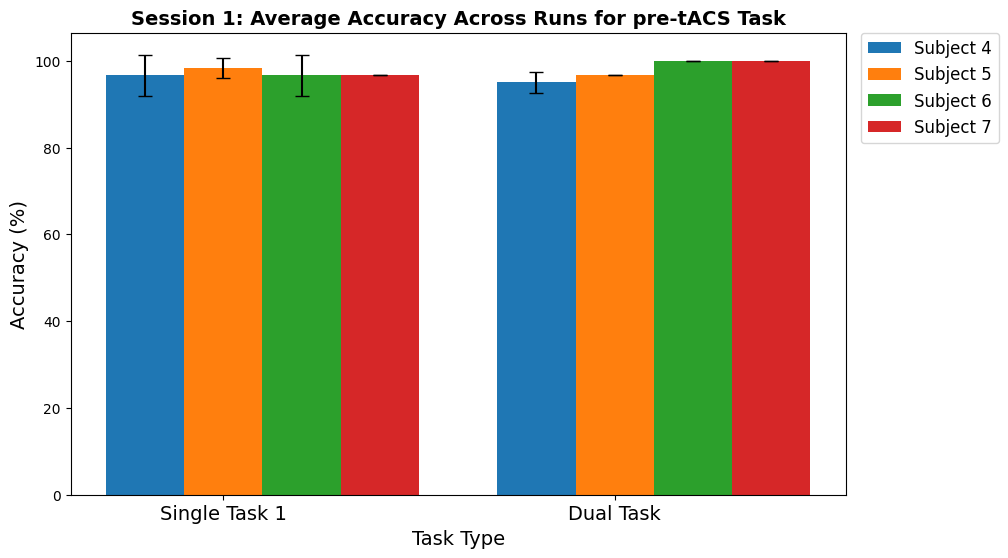

In [21]:
display_accuracies(s0N_s01_pre_tACS_runs_accuracy, "pre-tACS", 1)

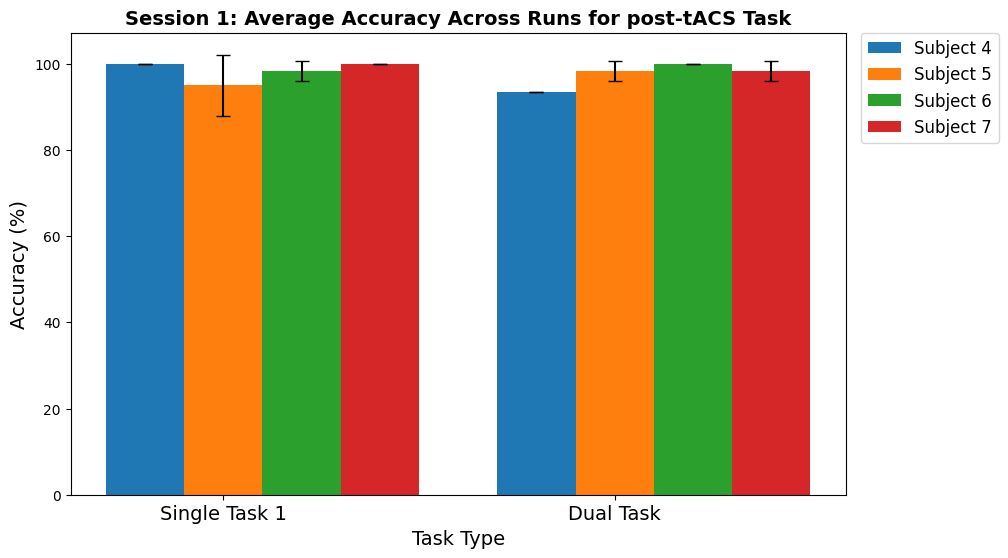

In [22]:
display_accuracies(s0N_s01_post_tACS_runs_accuracy, "post-tACS", 1)

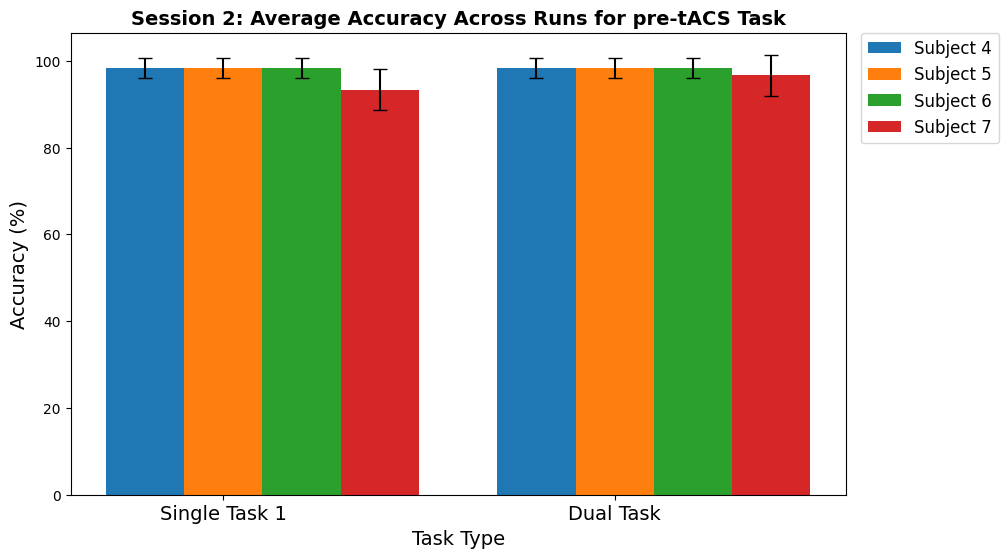

In [23]:
display_accuracies(s0N_s02_pre_tACS_runs_accuracy, "pre-tACS", 2)

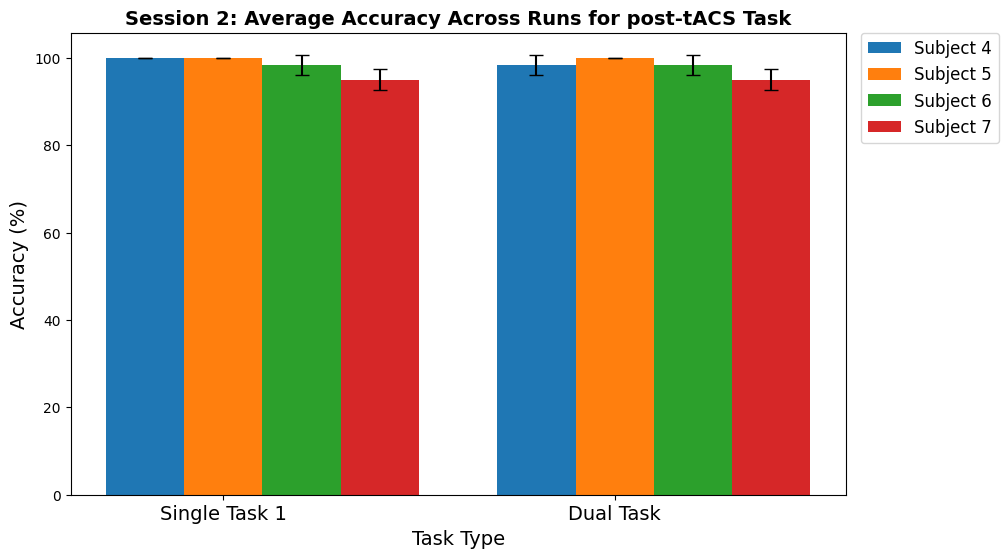

In [24]:
display_accuracies(s0N_s02_post_tACS_runs_accuracy, "post-tACS", 2)

In [25]:
def extract_response_times(s0N_s0X_r0X_type_txt_file_name):
  """Function parses through ST1 of DT trigger text file and returns task response times and task labels in a session
    Returns:
    (task_labels, task_durations): Tuple of task_labels and corresponding task_durations in seconds.
  """

  time_format = "%M:%S:%f"

  # Regular expression pattern to match the timestamp
  time_pattern = r"Timestamp: (\d{2}:\d{2}:\d{3})"

  # Label = 0: Incorrect, Label = 1: Correct
  task_labels = []

  # Collect Task Durations for Hits and Misses
  task_durations = []

  with open(s0N_s0X_r0X_type_txt_file_name, "r") as file:
      lines = file.readlines()

  lines = lines[1:] # Remove start of session entry

  # Task Triggers: 600, 700/702/701/703, 900/901, 800/801/802
  # Every 4 Lines is a new task
  for line_num in range(0, len(lines), 4):
      task_start_line = lines[line_num + 1]
      task_end_line = lines[line_num + 2]

      # Extract Start Time from task_start_line
      match = re.search(time_pattern, task_start_line)
      if match:
          # Extract the timestamp string
          task_start_str_time = match.group(1)
          start_time = datetime.strptime(task_start_str_time, time_format)
      else:
        print("Error extracting trial start timestamp")
        return -1

      # Extract End Time from task_start_line
      match = re.search(time_pattern, task_end_line)
      if match:
        # Extract the timestamp string
        task_end_str_time = match.group(1)
        end_time = datetime.strptime(task_end_str_time, time_format)
      else:
        print("Error extracting trial end timestamp")
        return -1

      task_duration = end_time - start_time
      task_durations.append(task_duration.total_seconds())

      # Get Task Label (correct/incorrect) from task_end_line
      if "[900]" in task_end_line: # Hit Trigger = 900
        task_labels.append(1)
      else:
        task_labels.append(0)
  return (task_labels, task_durations)

In [26]:
# Session 1 - Pre-tACS Durations pre-tACS per DT Runs and ST1 Runs

# Subject 4
(s04_s01_r01_pre_tACS_ST1_labels, s04_s01_r01_pre_tACS_ST1_task_durations) = extract_response_times(subject_4_session1_pre_tACS_path + '/s04_s01_r01_ST1_triggers.txt')
(s04_s01_r02_pre_tACS_ST1_labels, s04_s01_r02_pre_tACS_ST1_task_durations) = extract_response_times(subject_4_session1_pre_tACS_path + '/s04_s01_r02_ST1_triggers.txt')
(s04_s01_r01_pre_tACS_DT_labels, s04_s01_r01_pre_tACS_DT_task_durations) = extract_response_times(subject_4_session1_pre_tACS_path + '/s04_s01_r01_DT_triggers.txt')
(s04_s01_r02_pre_tACS_DT_labels, s04_s01_r02_pre_tACS_DT_task_durations) = extract_response_times(subject_4_session1_pre_tACS_path + '/s04_s01_r02_DT_triggers.txt')

# Subject 5
(s05_s01_r01_pre_tACS_ST1_labels, s05_s01_r01_pre_tACS_ST1_task_durations) = extract_response_times(subject_5_session1_pre_tACS_path + '/s05_s01_r01_ST1_triggers.txt')
(s05_s01_r02_pre_tACS_ST1_labels, s05_s01_r02_pre_tACS_ST1_task_durations) = extract_response_times(subject_5_session1_pre_tACS_path + '/s05_s01_r02_ST1_triggers.txt')
(s05_s01_r01_pre_tACS_DT_labels, s05_s01_r01_pre_tACS_DT_task_durations) = extract_response_times(subject_5_session1_pre_tACS_path + '/s05_s01_r01_DT_triggers.txt')
(s05_s01_r02_pre_tACS_DT_labels, s05_s01_r02_pre_tACS_DT_task_durations) = extract_response_times(subject_5_session1_pre_tACS_path + '/s05_s01_r02_DT_triggers.txt')

# Subject 6
(s06_s01_r01_pre_tACS_ST1_labels, s06_s01_r01_pre_tACS_ST1_task_durations) = extract_response_times(subject_6_session1_pre_tACS_path + '/s06_s01_r01_ST1_triggers.txt')
(s06_s01_r02_pre_tACS_ST1_labels, s06_s01_r02_pre_tACS_ST1_task_durations) = extract_response_times(subject_6_session1_pre_tACS_path + '/s06_s01_r02_ST1_triggers.txt')
(s06_s01_r01_pre_tACS_DT_labels, s06_s01_r01_pre_tACS_DT_task_durations) = extract_response_times(subject_6_session1_pre_tACS_path + '/s06_s01_r01_DT_triggers.txt')
(s06_s01_r02_pre_tACS_DT_labels, s06_s01_r02_pre_tACS_DT_task_durations) = extract_response_times(subject_6_session1_pre_tACS_path + '/s06_s01_r02_DT_triggers.txt')

# Subject 7
(s07_s01_r01_pre_tACS_ST1_labels, s07_s01_r01_pre_tACS_ST1_task_durations) = extract_response_times(subject_7_session1_pre_tACS_path + '/s07_s01_r01_ST1_triggers.txt')
(s07_s01_r02_pre_tACS_ST1_labels, s07_s01_r02_pre_tACS_ST1_task_durations) = extract_response_times(subject_7_session1_pre_tACS_path + '/s07_s01_r02_ST1_triggers.txt')
(s07_s01_r01_pre_tACS_DT_labels, s07_s01_r01_pre_tACS_DT_task_durations) = extract_response_times(subject_7_session1_pre_tACS_path + '/s07_s01_r01_DT_triggers.txt')
(s07_s01_r02_pre_tACS_DT_labels, s07_s01_r02_pre_tACS_DT_task_durations) = extract_response_times(subject_7_session1_pre_tACS_path + '/s07_s01_r02_DT_triggers.txt')

In [27]:
# Session 1 - Post-tACS Durations pre-tACS per DT Runs and ST1 Runs

# Subject 4
(s04_s01_r01_post_tACS_ST1_labels, s04_s01_r01_post_tACS_ST1_task_durations) = extract_response_times(subject_4_session1_post_tACS_path + '/s04_s01_r03_ST1_triggers.txt')
(s04_s01_r02_post_tACS_ST1_labels, s04_s01_r02_post_tACS_ST1_task_durations) = extract_response_times(subject_4_session1_post_tACS_path + '/s04_s01_r04_ST1_triggers.txt')
(s04_s01_r01_post_tACS_DT_labels, s04_s01_r01_post_tACS_DT_task_durations) = extract_response_times(subject_4_session1_post_tACS_path + '/s04_s01_r03_DT_triggers.txt')
(s04_s01_r02_post_tACS_DT_labels, s04_s01_r02_post_tACS_DT_task_durations) = extract_response_times(subject_4_session1_post_tACS_path + '/s04_s01_r04_DT_triggers.txt')

# Subject 5
(s05_s01_r01_post_tACS_ST1_labels, s05_s01_r01_post_tACS_ST1_task_durations) = extract_response_times(subject_5_session1_post_tACS_path + '/s05_s01_r03_ST1_triggers.txt')
(s05_s01_r02_post_tACS_ST1_labels, s05_s01_r02_post_tACS_ST1_task_durations) = extract_response_times(subject_5_session1_post_tACS_path + '/s05_s01_r04_ST1_triggers.txt')
(s05_s01_r01_post_tACS_DT_labels, s05_s01_r01_post_tACS_DT_task_durations) = extract_response_times(subject_5_session1_post_tACS_path + '/s05_s01_r03_DT_triggers.txt')
(s05_s01_r02_post_tACS_DT_labels, s05_s01_r02_post_tACS_DT_task_durations) = extract_response_times(subject_5_session1_post_tACS_path + '/s05_s01_r04_DT_triggers.txt')

# Subject 6
(s06_s01_r01_post_tACS_ST1_labels, s06_s01_r01_post_tACS_ST1_task_durations) = extract_response_times(subject_6_session1_post_tACS_path + '/s06_s01_r03_ST1_triggers.txt')
(s06_s01_r02_post_tACS_ST1_labels, s06_s01_r02_post_tACS_ST1_task_durations) = extract_response_times(subject_6_session1_post_tACS_path + '/s06_s01_r04_ST1_triggers.txt')
(s06_s01_r01_post_tACS_DT_labels, s06_s01_r01_post_tACS_DT_task_durations) = extract_response_times(subject_6_session1_post_tACS_path + '/s06_s01_r03_DT_triggers.txt')
(s06_s01_r02_post_tACS_DT_labels, s06_s01_r02_post_tACS_DT_task_durations) = extract_response_times(subject_6_session1_post_tACS_path + '/s06_s01_r04_DT_triggers.txt')

# Subject 7
(s07_s01_r01_post_tACS_ST1_labels, s07_s01_r01_post_tACS_ST1_task_durations) = extract_response_times(subject_7_session1_post_tACS_path + '/s07_s01_r03_ST1_triggers.txt')
(s07_s01_r02_post_tACS_ST1_labels, s07_s01_r02_post_tACS_ST1_task_durations) = extract_response_times(subject_7_session1_post_tACS_path + '/s07_s01_r04_ST1_triggers.txt')
(s07_s01_r01_post_tACS_DT_labels, s07_s01_r01_post_tACS_DT_task_durations) = extract_response_times(subject_7_session1_post_tACS_path + '/s07_s01_r03_DT_triggers.txt')
(s07_s01_r02_post_tACS_DT_labels, s07_s01_r02_post_tACS_DT_task_durations) = extract_response_times(subject_7_session1_post_tACS_path + '/s07_s01_r04_DT_triggers.txt')

In [28]:
# Session 2 - Pre-tACS Durations pre-tACS per DT Runs and ST1 Runs

# Subject 4
(s04_s02_r01_pre_tACS_ST1_labels, s04_s02_r01_pre_tACS_ST1_task_durations) = extract_response_times(subject_4_session2_pre_tACS_path + '/s04_s02_r01_ST1_triggers.txt')
(s04_s02_r02_pre_tACS_ST1_labels, s04_s02_r02_pre_tACS_ST1_task_durations) = extract_response_times(subject_4_session2_pre_tACS_path + '/s04_s02_r02_ST1_triggers.txt')
(s04_s02_r01_pre_tACS_DT_labels, s04_s02_r01_pre_tACS_DT_task_durations) = extract_response_times(subject_4_session2_pre_tACS_path + '/s04_s02_r01_DT_triggers.txt')
(s04_s02_r02_pre_tACS_DT_labels, s04_s02_r02_pre_tACS_DT_task_durations) = extract_response_times(subject_4_session2_pre_tACS_path + '/s04_s02_r02_DT_triggers.txt')

# Subject 5
(s05_s02_r01_pre_tACS_ST1_labels, s05_s02_r01_pre_tACS_ST1_task_durations) = extract_response_times(subject_5_session2_pre_tACS_path + '/s05_s02_r01_ST1_triggers.txt')
(s05_s02_r02_pre_tACS_ST1_labels, s05_s02_r02_pre_tACS_ST1_task_durations) = extract_response_times(subject_5_session2_pre_tACS_path + '/s05_s02_r02_ST1_triggers.txt')
(s05_s02_r01_pre_tACS_DT_labels, s05_s02_r01_pre_tACS_DT_task_durations) = extract_response_times(subject_5_session2_pre_tACS_path + '/s05_s02_r01_DT_triggers.txt')
(s05_s02_r02_pre_tACS_DT_labels, s05_s02_r02_pre_tACS_DT_task_durations) = extract_response_times(subject_5_session2_pre_tACS_path + '/s05_s02_r02_DT_triggers.txt')

# Subject 6
(s06_s02_r01_pre_tACS_ST1_labels, s06_s02_r01_pre_tACS_ST1_task_durations) = extract_response_times(subject_6_session2_pre_tACS_path + '/s06_s02_r01_ST1_triggers.txt')
(s06_s02_r02_pre_tACS_ST1_labels, s06_s02_r02_pre_tACS_ST1_task_durations) = extract_response_times(subject_6_session2_pre_tACS_path + '/s06_s02_r02_ST1_triggers.txt')
(s06_s02_r01_pre_tACS_DT_labels, s06_s02_r01_pre_tACS_DT_task_durations) = extract_response_times(subject_6_session2_pre_tACS_path + '/s06_s02_r01_DT_triggers.txt')
(s06_s02_r02_pre_tACS_DT_labels, s06_s02_r02_pre_tACS_DT_task_durations) = extract_response_times(subject_6_session2_pre_tACS_path + '/s06_s02_r02_DT_triggers.txt')

# Subject 7
(s07_s02_r01_pre_tACS_ST1_labels, s07_s02_r01_pre_tACS_ST1_task_durations) = extract_response_times(subject_7_session2_pre_tACS_path + '/s07_s02_r01_ST1_triggers.txt')
(s07_s02_r02_pre_tACS_ST1_labels, s07_s02_r02_pre_tACS_ST1_task_durations) = extract_response_times(subject_7_session2_pre_tACS_path + '/s07_s02_r02_ST1_triggers.txt')
(s07_s02_r01_pre_tACS_DT_labels, s07_s02_r01_pre_tACS_DT_task_durations) = extract_response_times(subject_7_session2_pre_tACS_path + '/s07_s02_r01_DT_triggers.txt')
(s07_s02_r02_pre_tACS_DT_labels, s07_s02_r02_pre_tACS_DT_task_durations) = extract_response_times(subject_7_session2_pre_tACS_path + '/s07_s02_r02_DT_triggers.txt')

In [29]:
# Session 2 - Post-tACS Durations pre-tACS per DT Runs and ST1 Runs

# Subject 4
(s04_s02_r01_post_tACS_ST1_labels, s04_s02_r01_post_tACS_ST1_task_durations) = extract_response_times(subject_4_session2_post_tACS_path + '/s04_s02_r03_ST1_triggers.txt')
(s04_s02_r02_post_tACS_ST1_labels, s04_s02_r02_post_tACS_ST1_task_durations) = extract_response_times(subject_4_session2_post_tACS_path + '/s04_s02_r04_ST1_triggers.txt')
(s04_s02_r01_post_tACS_DT_labels, s04_s02_r01_post_tACS_DT_task_durations) = extract_response_times(subject_4_session2_post_tACS_path + '/s04_s02_r03_DT_triggers.txt')
(s04_s02_r02_post_tACS_DT_labels, s04_s02_r02_post_tACS_DT_task_durations) = extract_response_times(subject_4_session2_post_tACS_path + '/s04_s02_r04_DT_triggers.txt')

# Subject 5
(s05_s02_r01_post_tACS_ST1_labels, s05_s02_r01_post_tACS_ST1_task_durations) = extract_response_times(subject_5_session2_post_tACS_path + '/s05_s02_r03_ST1_triggers.txt')
(s05_s02_r02_post_tACS_ST1_labels, s05_s02_r02_post_tACS_ST1_task_durations) = extract_response_times(subject_5_session2_post_tACS_path + '/s05_s02_r04_ST1_triggers.txt')
(s05_s02_r01_post_tACS_DT_labels, s05_s02_r01_post_tACS_DT_task_durations) = extract_response_times(subject_5_session2_post_tACS_path + '/s05_s02_r03_DT_triggers.txt')
(s05_s02_r02_post_tACS_DT_labels, s05_s02_r02_post_tACS_DT_task_durations) = extract_response_times(subject_5_session2_post_tACS_path + '/s05_s02_r04_DT_triggers.txt')

# Subject 6
(s06_s02_r01_post_tACS_ST1_labels, s06_s02_r01_post_tACS_ST1_task_durations) = extract_response_times(subject_6_session2_post_tACS_path + '/s06_s02_r03_ST1_triggers.txt')
(s06_s02_r02_post_tACS_ST1_labels, s06_s02_r02_post_tACS_ST1_task_durations) = extract_response_times(subject_6_session2_post_tACS_path + '/s06_s02_r04_ST1_triggers.txt')
(s06_s02_r01_post_tACS_DT_labels, s06_s02_r01_post_tACS_DT_task_durations) = extract_response_times(subject_6_session2_post_tACS_path + '/s06_s02_r03_DT_triggers.txt')
(s06_s02_r02_post_tACS_DT_labels, s06_s02_r02_post_tACS_DT_task_durations) = extract_response_times(subject_6_session2_post_tACS_path + '/s06_s02_r04_DT_triggers.txt')

# Subject 7
(s07_s02_r01_post_tACS_ST1_labels, s07_s02_r01_post_tACS_ST1_task_durations) = extract_response_times(subject_7_session2_post_tACS_path + '/s07_s02_r03_ST1_triggers.txt')
(s07_s02_r02_post_tACS_ST1_labels, s07_s02_r02_post_tACS_ST1_task_durations) = extract_response_times(subject_7_session2_post_tACS_path + '/s07_s02_r04_ST1_triggers.txt')
(s07_s02_r01_post_tACS_DT_labels, s07_s02_r01_post_tACS_DT_task_durations) = extract_response_times(subject_7_session2_post_tACS_path + '/s07_s02_r03_DT_triggers.txt')
(s07_s02_r02_post_tACS_DT_labels, s07_s02_r02_post_tACS_DT_task_durations) = extract_response_times(subject_7_session2_post_tACS_path + '/s07_s02_r04_DT_triggers.txt')

In [30]:
# Session 1 - Pre-tACS Response Times
s04_s01_pre_tACS_response_times = np.array([s04_s01_r01_pre_tACS_ST1_task_durations, s04_s01_r02_pre_tACS_ST1_task_durations, s04_s01_r01_pre_tACS_DT_task_durations, s04_s01_r02_pre_tACS_DT_task_durations])
s05_s01_pre_tACS_response_times = np.array([s05_s01_r01_pre_tACS_ST1_task_durations, s05_s01_r02_pre_tACS_ST1_task_durations, s05_s01_r01_pre_tACS_DT_task_durations, s05_s01_r02_pre_tACS_DT_task_durations])
s06_s01_pre_tACS_response_times = np.array([s06_s01_r01_pre_tACS_ST1_task_durations, s06_s01_r02_pre_tACS_ST1_task_durations, s06_s01_r01_pre_tACS_DT_task_durations, s06_s01_r02_pre_tACS_DT_task_durations])
s07_s01_pre_tACS_response_times = np.array([s07_s01_r01_pre_tACS_ST1_task_durations, s07_s01_r02_pre_tACS_ST1_task_durations, s07_s01_r01_pre_tACS_DT_task_durations, s07_s01_r02_pre_tACS_DT_task_durations])

s0N_s01_pre_tACS_runs_response_times = np.array([s04_s01_pre_tACS_response_times, s05_s01_pre_tACS_response_times, s06_s01_pre_tACS_response_times, s07_s01_pre_tACS_response_times])

In [31]:
# Session 1 - Post-tACS Response Times
s04_s01_post_tACS_response_times = np.array([s04_s01_r01_post_tACS_ST1_task_durations, s04_s01_r02_post_tACS_ST1_task_durations, s04_s01_r01_post_tACS_DT_task_durations, s04_s01_r02_post_tACS_DT_task_durations])
s05_s01_post_tACS_response_times = np.array([s05_s01_r01_post_tACS_ST1_task_durations, s05_s01_r02_post_tACS_ST1_task_durations, s05_s01_r01_post_tACS_DT_task_durations, s05_s01_r02_post_tACS_DT_task_durations])
s06_s01_post_tACS_response_times = np.array([s06_s01_r01_post_tACS_ST1_task_durations, s06_s01_r02_post_tACS_ST1_task_durations, s06_s01_r01_post_tACS_DT_task_durations, s06_s01_r02_post_tACS_DT_task_durations])
s07_s01_post_tACS_response_times = np.array([s07_s01_r01_post_tACS_ST1_task_durations, s07_s01_r02_post_tACS_ST1_task_durations, s07_s01_r01_post_tACS_DT_task_durations, s07_s01_r02_post_tACS_DT_task_durations])

s0N_s01_post_tACS_runs_response_times = np.array([s04_s01_post_tACS_response_times, s05_s01_post_tACS_response_times, s06_s01_post_tACS_response_times, s07_s01_post_tACS_response_times])

In [32]:
# Session 2 - Pre-tACS Response Times
s04_s02_pre_tACS_response_times = np.array([s04_s02_r01_pre_tACS_ST1_task_durations, s04_s02_r02_pre_tACS_ST1_task_durations, s04_s02_r01_pre_tACS_DT_task_durations, s04_s02_r02_pre_tACS_DT_task_durations])
s05_s02_pre_tACS_response_times = np.array([s05_s02_r01_pre_tACS_ST1_task_durations, s05_s02_r02_pre_tACS_ST1_task_durations, s05_s02_r01_pre_tACS_DT_task_durations, s05_s02_r02_pre_tACS_DT_task_durations])
s06_s02_pre_tACS_response_times = np.array([s06_s02_r01_pre_tACS_ST1_task_durations, s06_s02_r02_pre_tACS_ST1_task_durations, s06_s02_r01_pre_tACS_DT_task_durations, s06_s02_r02_pre_tACS_DT_task_durations])
s07_s02_pre_tACS_response_times = np.array([s07_s02_r01_pre_tACS_ST1_task_durations, s07_s02_r02_pre_tACS_ST1_task_durations, s07_s02_r01_pre_tACS_DT_task_durations, s07_s02_r02_pre_tACS_DT_task_durations])

s0N_s02_pre_tACS_runs_response_times = np.array([s04_s02_pre_tACS_response_times, s05_s02_pre_tACS_response_times, s06_s02_pre_tACS_response_times, s07_s02_pre_tACS_response_times])

In [33]:
# Session 2 - Post-tACS Response Times
s04_s02_post_tACS_response_times = np.array([s04_s02_r01_post_tACS_ST1_task_durations, s04_s02_r02_post_tACS_ST1_task_durations, s04_s02_r01_post_tACS_DT_task_durations, s04_s02_r02_post_tACS_DT_task_durations])
s05_s02_post_tACS_response_times = np.array([s05_s02_r01_post_tACS_ST1_task_durations, s05_s02_r02_post_tACS_ST1_task_durations, s05_s02_r01_post_tACS_DT_task_durations, s05_s02_r02_post_tACS_DT_task_durations])
s06_s02_post_tACS_response_times = np.array([s06_s02_r01_post_tACS_ST1_task_durations, s06_s02_r02_post_tACS_ST1_task_durations, s06_s02_r01_post_tACS_DT_task_durations, s06_s02_r02_post_tACS_DT_task_durations])
s07_s02_post_tACS_response_times = np.array([s07_s02_r01_post_tACS_ST1_task_durations, s07_s02_r02_post_tACS_ST1_task_durations, s07_s02_r01_post_tACS_DT_task_durations, s07_s02_r02_post_tACS_DT_task_durations])

s0N_s02_post_tACS_runs_response_times = np.array([s04_s02_post_tACS_response_times, s05_s02_post_tACS_response_times, s06_s02_post_tACS_response_times, s07_s02_post_tACS_response_times])

In [34]:
# Reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
def display_response_times(s0N_s0X_task_type_runs_response_times:np.array, task_type:str, session_number:int):
  """Function plots average response times (over runs) for provided pre/post tACS runs per subject
    Arguments:
    - s0N_s0X_task_type_runs_accuracy (np.array): Numpy Array of Arrays we each subarray is for a subject.
      Within a subarray, a list of 4 arrays contain the response times for the ST1-Rn, ST1-Rn+1, DT-Rn, DT-Rn+1. Each task may have a different number of elements.
    - task_type (str): String representing whether the tasks were conducted "Pre" or "Post" tACS
    - session_number (int): Session Number of Data
  """
  labels = ('Single Task 1', 'Dual Task')

  # Compute Average ST1 Response Time over the 2 runs (elements 0 and 1)
  avg_response_time_per_subject_for_ST1 = [
                                 statistics.mean(np.concatenate((s0N_s0X_task_type_runs_response_times[0][0], s0N_s0X_task_type_runs_response_times[0][1]), axis=0)),
                                 statistics.mean(np.concatenate((s0N_s0X_task_type_runs_response_times[1][0], s0N_s0X_task_type_runs_response_times[1][1]), axis=0)),
                                 statistics.mean(np.concatenate((s0N_s0X_task_type_runs_response_times[2][0], s0N_s0X_task_type_runs_response_times[2][1]), axis=0)),
                                 statistics.mean(np.concatenate((s0N_s0X_task_type_runs_response_times[3][0], s0N_s0X_task_type_runs_response_times[3][1]), axis=0)),
                                ]
  # Compute STD of Average ST1 Response Time over the 2 runs (elements 0 and 1)
  std_avg_response_time_per_subject_for_ST1 = [
                                 statistics.stdev(np.concatenate((s0N_s0X_task_type_runs_response_times[0][0], s0N_s0X_task_type_runs_response_times[0][1]), axis=0)),
                                 statistics.stdev(np.concatenate((s0N_s0X_task_type_runs_response_times[1][0], s0N_s0X_task_type_runs_response_times[1][1]), axis=0)),
                                 statistics.stdev(np.concatenate((s0N_s0X_task_type_runs_response_times[2][0], s0N_s0X_task_type_runs_response_times[2][1]), axis=0)),
                                 statistics.stdev(np.concatenate((s0N_s0X_task_type_runs_response_times[3][0], s0N_s0X_task_type_runs_response_times[3][1]), axis=0)),
                                ]

  # Compute Average DT1 Response Time over the 2 runs (elements 2 and 3)
  avg_response_time_per_subject_for_DT = [
                                statistics.mean(np.concatenate((s0N_s0X_task_type_runs_response_times[0][2], s0N_s0X_task_type_runs_response_times[0][3]), axis=0)),
                                statistics.mean(np.concatenate((s0N_s0X_task_type_runs_response_times[1][2], s0N_s0X_task_type_runs_response_times[1][3]), axis=0)),
                                statistics.mean(np.concatenate((s0N_s0X_task_type_runs_response_times[2][2], s0N_s0X_task_type_runs_response_times[2][3]), axis=0)),
                                statistics.mean(np.concatenate((s0N_s0X_task_type_runs_response_times[3][2], s0N_s0X_task_type_runs_response_times[3][3]), axis=0)),
                               ]

  # Compute STD of Average DT1 Response Time over the 2 runs (elements 2 and 3)
  std_avg_response_time_per_subject_for_DT = [
                                  statistics.stdev(np.concatenate((s0N_s0X_task_type_runs_response_times[0][2], s0N_s0X_task_type_runs_response_times[0][3]), axis=0)),
                                  statistics.stdev(np.concatenate((s0N_s0X_task_type_runs_response_times[1][2], s0N_s0X_task_type_runs_response_times[1][3]), axis=0)),
                                  statistics.stdev(np.concatenate((s0N_s0X_task_type_runs_response_times[2][2], s0N_s0X_task_type_runs_response_times[2][3]), axis=0)),
                                  statistics.stdev(np.concatenate((s0N_s0X_task_type_runs_response_times[3][2], s0N_s0X_task_type_runs_response_times[3][3]), axis=0)),
                                  ]


  x = np.arange(len(labels))  # the label locations
  width = 0.20                # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size

  subject_acc_means = {
    'Subject 4': (avg_response_time_per_subject_for_ST1[0],  avg_response_time_per_subject_for_DT[0]),
    'Subject 5': (avg_response_time_per_subject_for_ST1[1],  avg_response_time_per_subject_for_DT[1]),
    'Subject 6': (avg_response_time_per_subject_for_ST1[2],  avg_response_time_per_subject_for_DT[2]),
    'Subject 7': (avg_response_time_per_subject_for_ST1[3],  avg_response_time_per_subject_for_DT[3]),
  }
  for attribute, measurement in subject_acc_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, yerr=(std_avg_response_time_per_subject_for_ST1[multiplier], std_avg_response_time_per_subject_for_DT[multiplier]), label=attribute, capsize=5)
    #ax.bar_label(rects, fmt='%.2f', padding=2)  # Round to 2 decimal places
    multiplier += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Response Time (sec)', fontsize=14)
  ax.set_xlabel('Task Type', fontsize=14)
  ax.set_title(f"Session {session_number}: Average Response Time Across Runs for {task_type} Task", fontsize=14, fontweight='bold')
  ax.set_xticks(x + width, labels, fontsize=14)
  leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)
  plt.show()

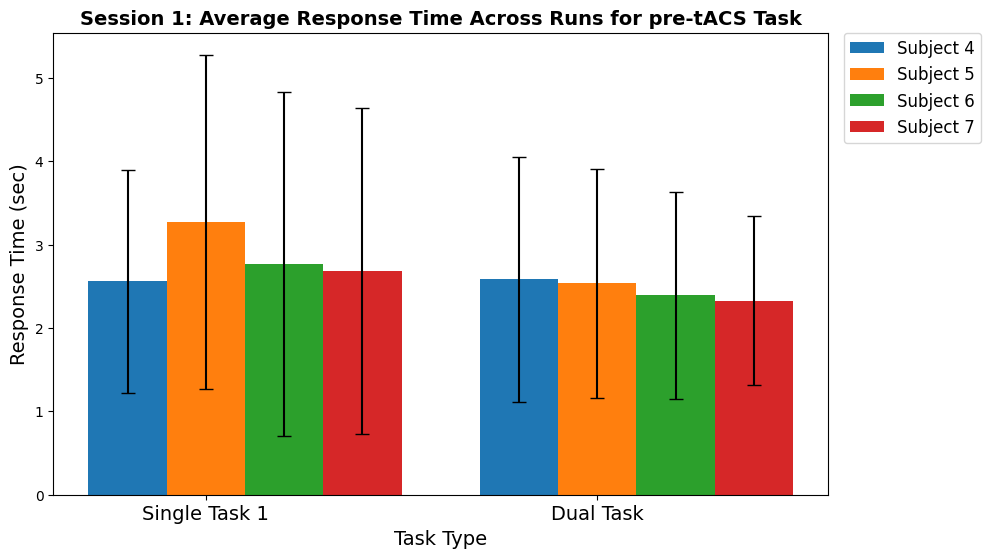

In [35]:
display_response_times(s0N_s01_pre_tACS_runs_response_times, "pre-tACS", 1)

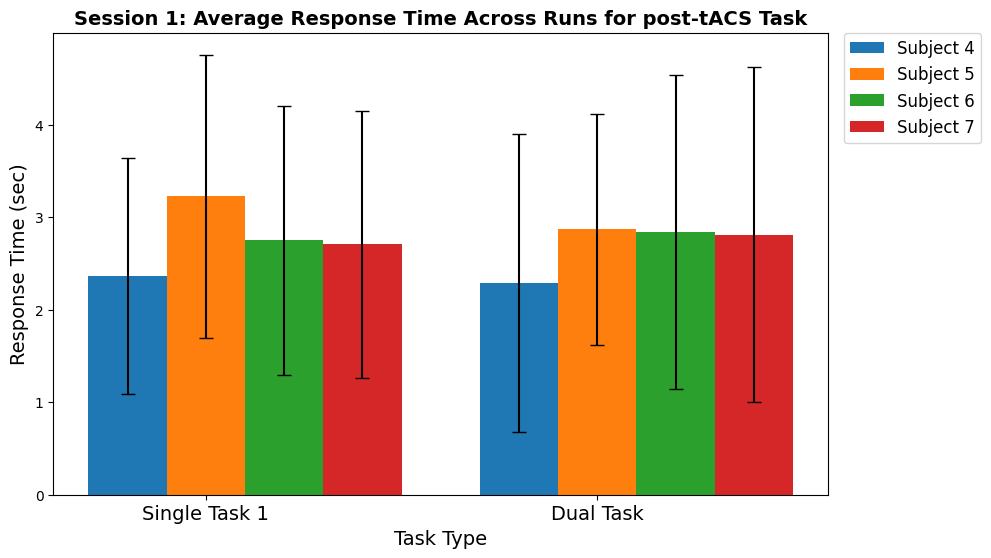

In [36]:
display_response_times(s0N_s01_post_tACS_runs_response_times, "post-tACS", 1)

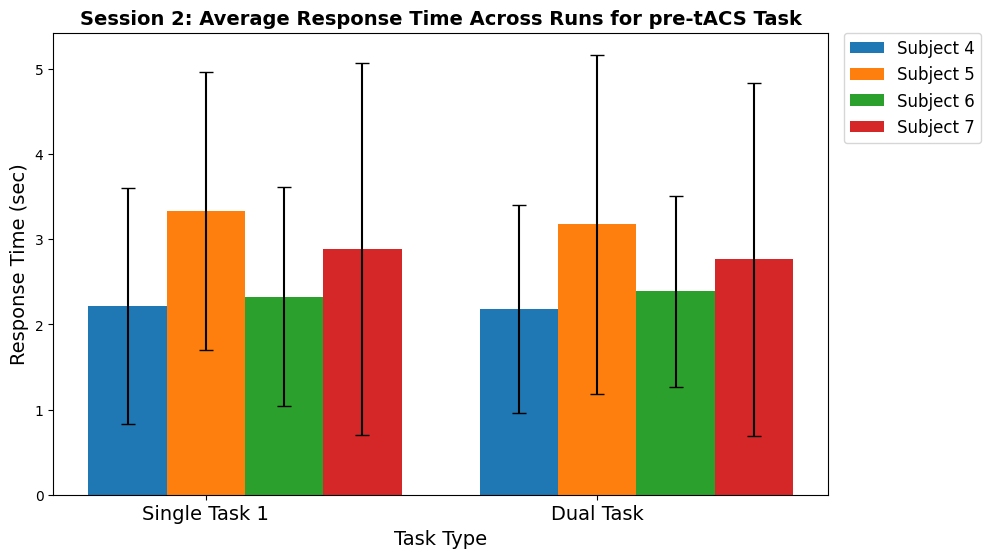

In [37]:
display_response_times(s0N_s02_pre_tACS_runs_response_times, "pre-tACS", 2)

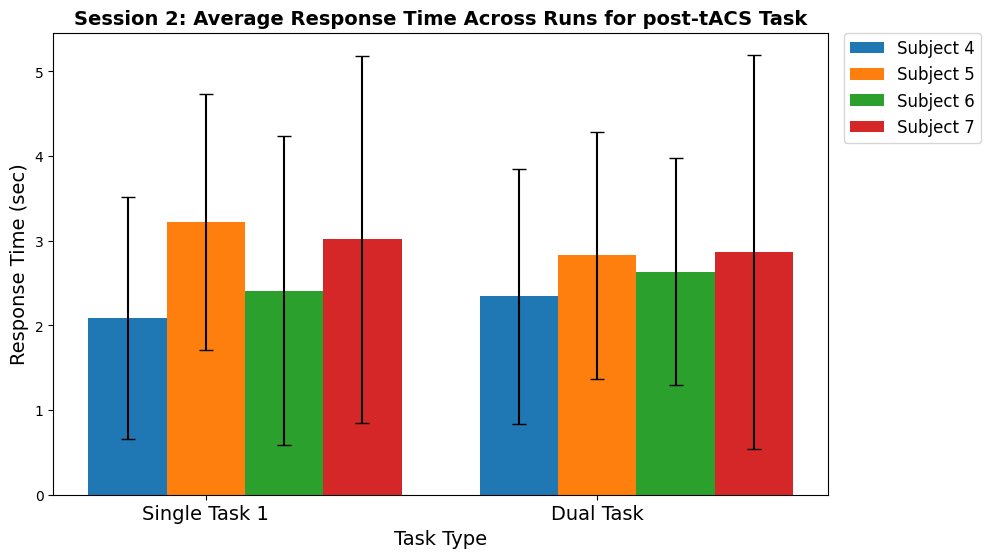

In [38]:
display_response_times(s0N_s02_post_tACS_runs_response_times, "post-tACS", 2)

**Behavioral Analysis**

Conduct Statitical Testing for pre-tACS vs. post-tACS using Paired t-test
  - Use 2 Metrics: Response Accuracy and Response Time
  - Conduct run wise and subject
  - Pearsons correlation coefficient

In [39]:
import itertools

# Session Level Behavioral Analysis
def perform_behavioral_analysis(s0N_sXX_pre_tACS_runs_metric, s0N_sXX_post_tACS_runs_metric, metric_type:str):
  """Function computes the paired t-test for each subject's performance metric between pre and post tACS treatment.
    If the p-value is less than 0.05, we reject the null hypothesis.
    So, we have enough proof to claim that the true mean metric score is different for pre-tACS and post-tACS.

    Arguments:
    - s0N_sXX_pre_tACS_runs_metric ():
    - s0N_sXX_post_tACS_runs_metric ():
    - metric_type ():
  """
  # Collect all of the data to perform test at the group level
  all_subjects_pre_tACS_ST1_metrics = []
  all_subjects_post_tACS_ST1_metrics = []

  all_subjects_pre_tACS_DT_metrics = []
  all_subjects_post_tACS_DT_metrics = []

  for subjectN in range(4):
    if metric_type == "Accuracy":
      s0N_pre_tACS_ST1_runs_metric = [s0N_sXX_pre_tACS_runs_metric[subjectN][0], s0N_sXX_pre_tACS_runs_metric[subjectN][1]]
      all_subjects_pre_tACS_ST1_metrics.append(s0N_pre_tACS_ST1_runs_metric)
      s0N_pre_tACS_DT_runs_metric = [s0N_sXX_pre_tACS_runs_metric[subjectN][2], s0N_sXX_pre_tACS_runs_metric[subjectN][3]]
      all_subjects_pre_tACS_DT_metrics.append(s0N_pre_tACS_DT_runs_metric)

      s0N_post_tACS_ST1_runs_metric = [s0N_sXX_post_tACS_runs_metric[subjectN][0], s0N_sXX_post_tACS_runs_metric[subjectN][1]]
      all_subjects_post_tACS_ST1_metrics.append(s0N_post_tACS_ST1_runs_metric)
      s0N_post_tACS_DT_runs_metric = [s0N_sXX_post_tACS_runs_metric[subjectN][2], s0N_sXX_post_tACS_runs_metric[subjectN][3]]
      all_subjects_post_tACS_DT_metrics.append(s0N_post_tACS_DT_runs_metric)

    elif metric_type == "Response Time":
      s0N_pre_tACS_ST1_runs_metric = np.concatenate([s0N_s01_pre_tACS_runs_response_times[subjectN][0], s0N_s01_pre_tACS_runs_response_times[subjectN][1]])
      all_subjects_pre_tACS_ST1_metrics.append(s0N_pre_tACS_ST1_runs_metric)
      s0N_pre_tACS_DT_runs_metric = np.concatenate([s0N_s01_pre_tACS_runs_response_times[subjectN][2], s0N_s01_pre_tACS_runs_response_times[subjectN][3]])
      all_subjects_pre_tACS_DT_metrics.append(s0N_pre_tACS_DT_runs_metric)

      s0N_post_tACS_ST1_runs_metric = np.concatenate([s0N_sXX_post_tACS_runs_metric[subjectN][0], s0N_sXX_post_tACS_runs_metric[subjectN][1]])
      all_subjects_post_tACS_ST1_metrics.append(s0N_post_tACS_ST1_runs_metric)
      s0N_post_tACS_DT_runs_metric = np.concatenate([s0N_sXX_post_tACS_runs_metric[subjectN][2], s0N_sXX_post_tACS_runs_metric[subjectN][3]])
      all_subjects_post_tACS_DT_metrics.append(s0N_post_tACS_DT_runs_metric)

    print(f"\nSubject {subjectN + 1}:")
    print("--------------------------------")

    # Performing Subject Based Paired Sample t-tests. Default alpha value = 0.05

    # Compare pre-tACS Single Task 1 to post-tACS Single Task 1 Accuracy/Response Time (Indicies 0 & 1)
    t1, p1 = stats.ttest_rel(s0N_pre_tACS_ST1_runs_metric, s0N_post_tACS_ST1_runs_metric)
    print(f"pre-tACS Single Task 1 {metric_type} vs. post-tACS Single Task 1 {metric_type}: p =", str(round(p1, 5)))
    if math.isnan(p1):
      print("The difference between every pair is the same. Can't compute paired t test.")
    if (p1 < 0.05):
      print("There is a statistically significant difference.")


    # Compare pre-tACS Dual Task  to post-tACS Dual Task Accuracy/Response Time (Indicies 2 & 3)
    t2, p2= stats.ttest_rel(s0N_pre_tACS_DT_runs_metric, s0N_post_tACS_DT_runs_metric)
    print(f"pre-tACS Dual Task {metric_type} vs. post-tACS Dual Task {metric_type}: p =", str(round(p2, 5)))
    if math.isnan(p2):
      print("The difference between every pair is the same. Can't compute paired t test.")
    if (p2 < 0.05):
      print("There is a statistically significant difference.")

  # Performing Group Based Paired Sample t-tests. Default alpha value = 0.05
  print(f"\nGroup Level t-test:")
  print("n = ", len(list(itertools.chain.from_iterable(all_subjects_pre_tACS_ST1_metrics))))
  print("--------------------------------")

  t_group_1, p_group_1 = stats.ttest_rel(list(itertools.chain.from_iterable(all_subjects_pre_tACS_ST1_metrics)), list(itertools.chain.from_iterable(all_subjects_post_tACS_ST1_metrics)))
  print(f"pre-tACS Single Task 1 {metric_type} vs. post-tACS Single Task 1 {metric_type}: p =", str(round(p_group_1, 5)))
  if math.isnan(p_group_1):
    print("The difference between every pair is the same. Can't compute paired t test.")
  if (p_group_1 < 0.05):
    print("There is a statistically significant difference.")

  t_group_2, p_group_2 = stats.ttest_rel(list(itertools.chain.from_iterable(all_subjects_pre_tACS_DT_metrics)), list(itertools.chain.from_iterable(all_subjects_post_tACS_DT_metrics)))
  print(f"pre-tACS Dual Task  {metric_type} vs. post-tACS Dual Task  {metric_type}: p =", str(round(p_group_2, 5)))
  if math.isnan(p_group_2):
    print("The difference between every pair is the same. Can't compute paired t test.")
  if (p_group_2 < 0.05):
    print("There is a statistically significant difference.")


In [40]:
# Session 1: Subject Based pre-tACS vs. post-tACS ST and DT Accuracy
perform_behavioral_analysis(s0N_s01_pre_tACS_runs_accuracy, s0N_s01_post_tACS_runs_accuracy, "Accuracy")


Subject 1:
--------------------------------
pre-tACS Single Task 1 Accuracy vs. post-tACS Single Task 1 Accuracy: p = 0.5
pre-tACS Dual Task Accuracy vs. post-tACS Dual Task Accuracy: p = 0.5

Subject 2:
--------------------------------
pre-tACS Single Task 1 Accuracy vs. post-tACS Single Task 1 Accuracy: p = 0.70483
pre-tACS Dual Task Accuracy vs. post-tACS Dual Task Accuracy: p = 0.5

Subject 3:
--------------------------------
pre-tACS Single Task 1 Accuracy vs. post-tACS Single Task 1 Accuracy: p = 0.79517
pre-tACS Dual Task Accuracy vs. post-tACS Dual Task Accuracy: p = nan
The difference between every pair is the same. Can't compute paired t test.

Subject 4:
--------------------------------
pre-tACS Single Task 1 Accuracy vs. post-tACS Single Task 1 Accuracy: p = 0.0
There is a statistically significant difference.
pre-tACS Dual Task Accuracy vs. post-tACS Dual Task Accuracy: p = 0.5

Group Level t-test:
n =  8
--------------------------------
pre-tACS Single Task 1 Accuracy vs

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [41]:
# Session 1: Subject Based pre-tACS vs. post-tACS ST and DT Response Time
perform_behavioral_analysis(s0N_s01_pre_tACS_runs_response_times, s0N_s01_post_tACS_runs_response_times, "Response Time")


Subject 1:
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Single Task 1 Response Time: p = 0.42122
pre-tACS Dual Task Response Time vs. post-tACS Dual Task Response Time: p = 0.26956

Subject 2:
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Single Task 1 Response Time: p = 0.88279
pre-tACS Dual Task Response Time vs. post-tACS Dual Task Response Time: p = 0.13035

Subject 3:
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Single Task 1 Response Time: p = 0.97169
pre-tACS Dual Task Response Time vs. post-tACS Dual Task Response Time: p = 0.10196

Subject 4:
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Single Task 1 Response Time: p = 0.94638
pre-tACS Dual Task Response Time vs. post-tACS Dual Task Response Time: p = 0.09013

Group Level t-test:
n =  240
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Si

In [42]:
# Session 2: Subject Based pre-tACS vs. post-tACS ST and DT Accuracy
perform_behavioral_analysis(s0N_s02_pre_tACS_runs_accuracy, s0N_s02_post_tACS_runs_accuracy, "Accuracy")


Subject 1:
--------------------------------
pre-tACS Single Task 1 Accuracy vs. post-tACS Single Task 1 Accuracy: p = 0.5
pre-tACS Dual Task Accuracy vs. post-tACS Dual Task Accuracy: p = nan
The difference between every pair is the same. Can't compute paired t test.

Subject 2:
--------------------------------
pre-tACS Single Task 1 Accuracy vs. post-tACS Single Task 1 Accuracy: p = 0.5
pre-tACS Dual Task Accuracy vs. post-tACS Dual Task Accuracy: p = 0.5

Subject 3:
--------------------------------
pre-tACS Single Task 1 Accuracy vs. post-tACS Single Task 1 Accuracy: p = 1.0
pre-tACS Dual Task Accuracy vs. post-tACS Dual Task Accuracy: p = nan
The difference between every pair is the same. Can't compute paired t test.

Subject 4:
--------------------------------
pre-tACS Single Task 1 Accuracy vs. post-tACS Single Task 1 Accuracy: p = 0.5
pre-tACS Dual Task Accuracy vs. post-tACS Dual Task Accuracy: p = 0.79517

Group Level t-test:
n =  8
--------------------------------
pre-tACS Si

In [43]:
# Session 2: Subject Based pre-tACS vs. post-tACS ST and DT Response Time
perform_behavioral_analysis(s0N_s02_pre_tACS_runs_response_times, s0N_s02_post_tACS_runs_response_times, "Response Time")


Subject 1:
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Single Task 1 Response Time: p = 0.04046
There is a statistically significant difference.
pre-tACS Dual Task Response Time vs. post-tACS Dual Task Response Time: p = 0.30327

Subject 2:
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Single Task 1 Response Time: p = 0.89358
pre-tACS Dual Task Response Time vs. post-tACS Dual Task Response Time: p = 0.26287

Subject 3:
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Single Task 1 Response Time: p = 0.31917
pre-tACS Dual Task Response Time vs. post-tACS Dual Task Response Time: p = 0.28355

Subject 4:
--------------------------------
pre-tACS Single Task 1 Response Time vs. post-tACS Single Task 1 Response Time: p = 0.36829
pre-tACS Dual Task Response Time vs. post-tACS Dual Task Response Time: p = 0.09808

Group Level t-test:
n =  240
--------------------------------
pre-

**Conduct statistical testing across sessions for accuracy and response time. Subject Level Session 1 vs. Session 2, Sham vs. Stimulation**

 Now for each subject, compare performance between session 1 vs session 2 (e.g., the session occurred 1-2 weeks later).
 For each subject:
 1. Compare accuracy:
 - compare accuracy for pre tACS ST1 between session 1 and session 2;
 - compare accuracy for pre tACS DT between session 1 and session 2;
 - compare accuracy for post tACS ST1 between session 1 and session 2;
 - compare accuracy for post tACS DT between session 1 and session 2;
 2. Compare response time:
 - compare response time for pre tACS ST1 between session 1 and session 2;
 - compare response time for pre tACS DT between session 1 and session 2;
 - compare response time for post tACS ST1 between session 1 and session 2;
 - compare response time for post tACS DT between session 1 and session 2.

 3. Do paired-sample t-test for accuracy and response data illustrated above.

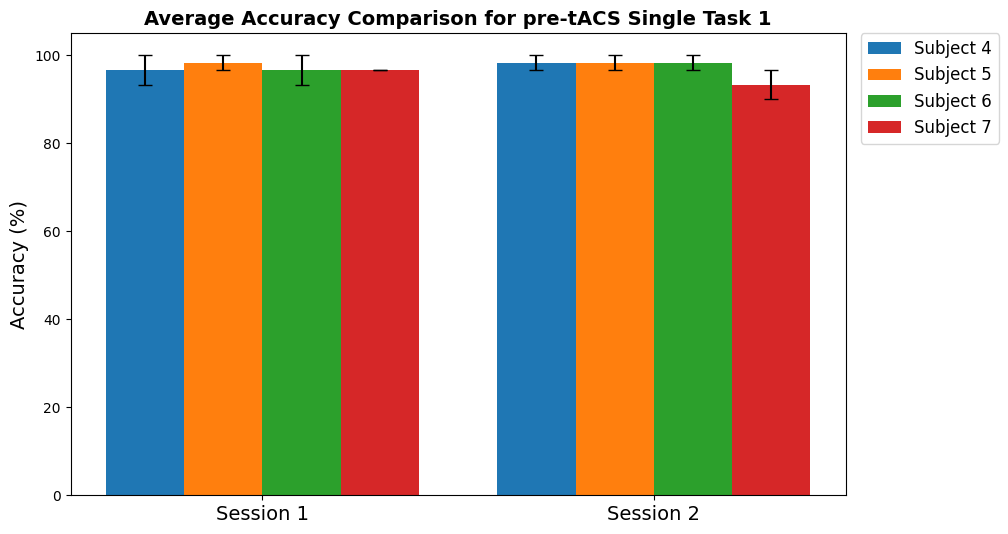

s01_pre_tACS_ST1_runs_accuracy: [0.93333333 1.         1.         0.96666667 1.         0.93333333
 0.96666667 0.96666667]
s02_pre_tACS_ST1_runs_accuracy: [1.         0.96666667 1.         0.96666667 0.96666667 1.
 0.9        0.96666667]
Inter Session pre tACS Single Task 1 Paired t-test results:
Inter Session pre tACS Single Task 1 t-statistic: 0.0
Inter Session pre tACS Single Task 1 p-value: 1.0
Inter Session pre tACS Single Task 1 - Fail to reject the null hypothesis: There is no significant difference between the means.
Inter Session pre tACS Single Task 1 Wilcoxon signed-rank test results:
Inter Session pre tACS Single Task 1 W-statistic: 7.0
Inter Session pre tACS Single Task 1 p-value: 0.8902300549434974
Inter Session pre tACS Single Task 1 - Fail to reject the null hypothesis: There is no significant difference between the medians.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [44]:
from scipy.stats import wilcoxon
# Calculate the averages and standard deviations of the first two elements for each session
avg_subject4 = np.mean([s04_s01_pre_tACS_runs_accuracy[:2], s04_s02_pre_tACS_runs_accuracy[:2]], axis=1)
std_subject4 = np.std([s04_s01_pre_tACS_runs_accuracy[:2], s04_s02_pre_tACS_runs_accuracy[:2]], axis=1)
avg_subject5 = np.mean([s05_s01_pre_tACS_runs_accuracy[:2], s05_s02_pre_tACS_runs_accuracy[:2]], axis=1)
std_subject5 = np.std([s05_s01_pre_tACS_runs_accuracy[:2], s05_s02_pre_tACS_runs_accuracy[:2]], axis=1)
avg_subject6 = np.mean([s06_s01_pre_tACS_runs_accuracy[:2], s06_s02_pre_tACS_runs_accuracy[:2]], axis=1)
std_subject6 = np.std([s06_s01_pre_tACS_runs_accuracy[:2], s06_s02_pre_tACS_runs_accuracy[:2]], axis=1)
avg_subject7 = np.mean([s07_s01_pre_tACS_runs_accuracy[:2], s07_s02_pre_tACS_runs_accuracy[:2]], axis=1)
std_subject7 = np.std([s07_s01_pre_tACS_runs_accuracy[:2], s07_s02_pre_tACS_runs_accuracy[:2]], axis=1)

# Plot clustered bar comparison with error bars
labels = ['Session 1', 'Session 2']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width * 1.5, avg_subject4 * 100, width, yerr=std_subject4 * 100, label='Subject 4', capsize=5)
rects2 = ax.bar(x - width * 0.5, avg_subject5 * 100, width, yerr=std_subject5 * 100, label='Subject 5', capsize=5)
rects3 = ax.bar(x + width * 0.5, avg_subject6 * 100, width, yerr=std_subject6 * 100, label='Subject 6', capsize=5)
rects4 = ax.bar(x + width * 1.5, avg_subject7 * 100, width, yerr=std_subject7 * 100, label='Subject 7', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=14)
#ax.set_xlabel('Task Type', fontsize=14)
ax.set_title("Average Accuracy Comparison for pre-tACS Single Task 1", fontsize=14, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

plt.show()

###################

#do paired-sample t test
# Extract the first two elements from each array - session 1
s04_s01_pre_tACS_runs_accuracy_first_two = s04_s01_pre_tACS_runs_accuracy[:2]
s05_s01_pre_tACS_runs_accuracy_first_two = s05_s01_pre_tACS_runs_accuracy[:2]
s06_s01_pre_tACS_runs_accuracy_first_two = s06_s01_pre_tACS_runs_accuracy[:2]
s07_s01_pre_tACS_runs_accuracy_first_two = s07_s01_pre_tACS_runs_accuracy[:2]

# Combine the extracted elements into a new dataset
s01_pre_tACS_ST1_runs_accuracy = np.concatenate([s04_s01_pre_tACS_runs_accuracy_first_two,
                                              s05_s01_pre_tACS_runs_accuracy_first_two,
                                              s06_s01_pre_tACS_runs_accuracy_first_two,
                                              s07_s01_pre_tACS_runs_accuracy_first_two])

# Output the combined dataset
print("s01_pre_tACS_ST1_runs_accuracy:", s01_pre_tACS_ST1_runs_accuracy)

# Extract the first two elements from each array - session 2
s04_s02_pre_tACS_runs_accuracy_first_two = s04_s02_pre_tACS_runs_accuracy[:2]
s05_s02_pre_tACS_runs_accuracy_first_two = s05_s02_pre_tACS_runs_accuracy[:2]
s06_s02_pre_tACS_runs_accuracy_first_two = s06_s02_pre_tACS_runs_accuracy[:2]
s07_s02_pre_tACS_runs_accuracy_first_two = s07_s02_pre_tACS_runs_accuracy[:2]

# Combine the extracted elements into a new dataset
s02_pre_tACS_ST1_runs_accuracy = np.concatenate([s04_s02_pre_tACS_runs_accuracy_first_two,
                                              s05_s02_pre_tACS_runs_accuracy_first_two,
                                              s06_s02_pre_tACS_runs_accuracy_first_two,
                                              s07_s02_pre_tACS_runs_accuracy_first_two])

# Output the combined dataset
print("s02_pre_tACS_ST1_runs_accuracy:", s02_pre_tACS_ST1_runs_accuracy)

# Perform paired sample t-test
t_statistic, p_value = stats.ttest_rel(s01_pre_tACS_ST1_runs_accuracy, s02_pre_tACS_ST1_runs_accuracy)

# Print the results
print("Inter Session pre tACS Single Task 1 Paired t-test results:")
print("Inter Session pre tACS Single Task 1 t-statistic:", t_statistic)
print("Inter Session pre tACS Single Task 1 p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Inter Session pre tACS Single Task 1 - Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Inter Session pre tACS Single Task 1 - Fail to reject the null hypothesis: There is no significant difference between the means.")

#Since there are only 8 samples, try non-parametric t test:
# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(s01_pre_tACS_ST1_runs_accuracy, s02_pre_tACS_ST1_runs_accuracy)

# Print the results
print("Inter Session pre tACS Single Task 1 Wilcoxon signed-rank test results:")
print("Inter Session pre tACS Single Task 1 W-statistic:", w_statistic)
print("Inter Session pre tACS Single Task 1 p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Inter Session pre tACS Single Task 1 - Reject the null hypothesis: There is a significant difference between the medians.")
else:
    print("Inter Session pre tACS Single Task 1 - Fail to reject the null hypothesis: There is no significant difference between the medians.")

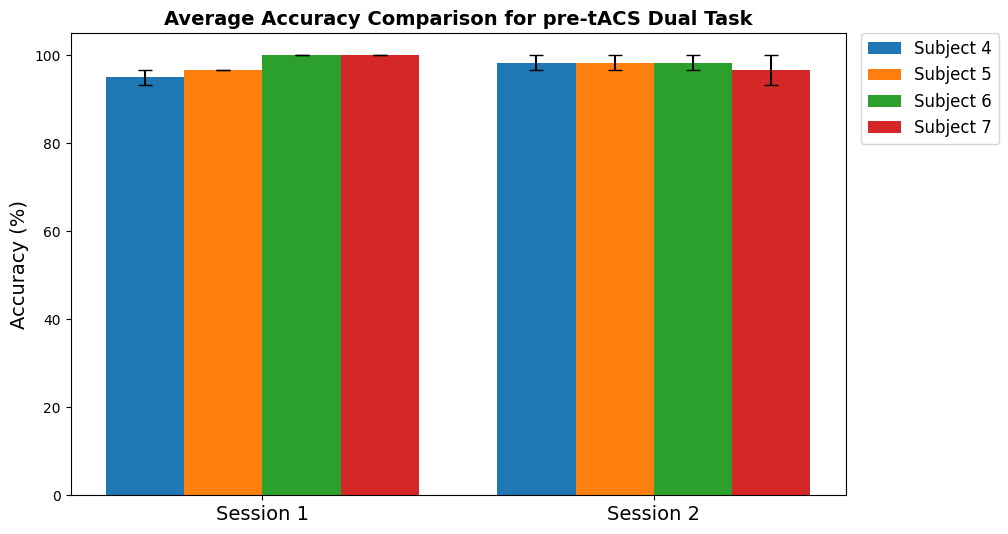

s01_pre_tACS_DT_runs_accuracy: [0.96666667 0.93333333 0.96666667 0.96666667 1.         1.
 1.         1.        ]
s02_pre_tACS_DT_runs_accuracy: [1.         0.96666667 0.96666667 1.         0.96666667 1.
 1.         0.93333333]
Inter Session pre tACS Dual Task Paired t-test results:
Inter Session pre tACS Dual Task t-statistic: 0.0
Inter Session pre tACS Dual Task p-value: 1.0
Inter Session pre tACS Dual Task - Fail to reject the null hypothesis: There is no significant difference between the means.
Inter Session pre tACS Dual Task Wilcoxon signed-rank test results:
Inter Session pre tACS Dual Task W-statistic: 7.5
Inter Session pre tACS Dual Task p-value: 1.0
Inter Session pre tACS Dual Task - Fail to reject the null hypothesis: There is no significant difference between the medians.


In [45]:
# Calculate the averages and standard deviations of the last two elements for each session
avg_subject4 = np.mean([s04_s01_pre_tACS_runs_accuracy[-2:], s04_s02_pre_tACS_runs_accuracy[-2:]], axis=1)
std_subject4 = np.std([s04_s01_pre_tACS_runs_accuracy[-2:], s04_s02_pre_tACS_runs_accuracy[-2:]], axis=1)
avg_subject5 = np.mean([s05_s01_pre_tACS_runs_accuracy[-2:], s05_s02_pre_tACS_runs_accuracy[-2:]], axis=1)
std_subject5 = np.std([s05_s01_pre_tACS_runs_accuracy[-2:], s05_s02_pre_tACS_runs_accuracy[-2:]], axis=1)
avg_subject6 = np.mean([s06_s01_pre_tACS_runs_accuracy[-2:], s06_s02_pre_tACS_runs_accuracy[-2:]], axis=1)
std_subject6 = np.std([s06_s01_pre_tACS_runs_accuracy[-2:], s06_s02_pre_tACS_runs_accuracy[-2:]], axis=1)
avg_subject7 = np.mean([s07_s01_pre_tACS_runs_accuracy[-2:], s07_s02_pre_tACS_runs_accuracy[-2:]], axis=1)
std_subject7 = np.std([s07_s01_pre_tACS_runs_accuracy[-2:], s07_s02_pre_tACS_runs_accuracy[-2:]], axis=1)

# Plot clustered bar comparison with error bars
labels = ['Session 1', 'Session 2']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width * 1.5, avg_subject4 * 100, width, yerr=std_subject4 * 100, label='Subject 4', capsize=5)
rects2 = ax.bar(x - width * 0.5, avg_subject5 * 100, width, yerr=std_subject5 * 100, label='Subject 5', capsize=5)
rects3 = ax.bar(x + width * 0.5, avg_subject6 * 100, width, yerr=std_subject6 * 100, label='Subject 6', capsize=5)
rects4 = ax.bar(x + width * 1.5, avg_subject7 * 100, width, yerr=std_subject7 * 100, label='Subject 7', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=14)
#ax.set_xlabel('Task Type', fontsize=14)
ax.set_title("Average Accuracy Comparison for pre-tACS Dual Task", fontsize=14, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

plt.show()

###################

#do paired-sample t test
# Extract the last two elements from each array - session 1
s04_s01_pre_tACS_runs_accuracy_last_two = s04_s01_pre_tACS_runs_accuracy[-2:]
s05_s01_pre_tACS_runs_accuracy_last_two = s05_s01_pre_tACS_runs_accuracy[-2:]
s06_s01_pre_tACS_runs_accuracy_last_two = s06_s01_pre_tACS_runs_accuracy[-2:]
s07_s01_pre_tACS_runs_accuracy_last_two = s07_s01_pre_tACS_runs_accuracy[-2:]

# Combine the extracted elements into a new dataset
s01_pre_tACS_DT_runs_accuracy = np.concatenate([s04_s01_pre_tACS_runs_accuracy_last_two,
                                              s05_s01_pre_tACS_runs_accuracy_last_two,
                                              s06_s01_pre_tACS_runs_accuracy_last_two,
                                              s07_s01_pre_tACS_runs_accuracy_last_two])

# Output the combined dataset
print("s01_pre_tACS_DT_runs_accuracy:", s01_pre_tACS_DT_runs_accuracy)

# Extract the last two elements from each array - session 2
s04_s02_pre_tACS_runs_accuracy_last_two = s04_s02_pre_tACS_runs_accuracy[-2:]
s05_s02_pre_tACS_runs_accuracy_last_two = s05_s02_pre_tACS_runs_accuracy[-2:]
s06_s02_pre_tACS_runs_accuracy_last_two = s06_s02_pre_tACS_runs_accuracy[-2:]
s07_s02_pre_tACS_runs_accuracy_last_two = s07_s02_pre_tACS_runs_accuracy[-2:]

# Combine the extracted elements into a new dataset
s02_pre_tACS_DT_runs_accuracy = np.concatenate([s04_s02_pre_tACS_runs_accuracy_last_two,
                                              s05_s02_pre_tACS_runs_accuracy_last_two,
                                              s06_s02_pre_tACS_runs_accuracy_last_two,
                                              s07_s02_pre_tACS_runs_accuracy_last_two])

# Output the combined dataset
print("s02_pre_tACS_DT_runs_accuracy:", s02_pre_tACS_DT_runs_accuracy)

# Perform paired sample t-test
t_statistic, p_value = stats.ttest_rel(s01_pre_tACS_DT_runs_accuracy, s02_pre_tACS_DT_runs_accuracy)

# Print the results
print("Inter Session pre tACS Dual Task Paired t-test results:")
print("Inter Session pre tACS Dual Task t-statistic:", t_statistic)
print("Inter Session pre tACS Dual Task p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Inter Session pre tACS Dual Task - Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Inter Session pre tACS Dual Task - Fail to reject the null hypothesis: There is no significant difference between the means.")

#Since there are only 8 samples, try non-parametric t test:
# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(s01_pre_tACS_DT_runs_accuracy, s02_pre_tACS_DT_runs_accuracy)

# Print the results
print("Inter Session pre tACS Dual Task Wilcoxon signed-rank test results:")
print("Inter Session pre tACS Dual Task W-statistic:", w_statistic)
print("Inter Session pre tACS Dual Task p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Inter Session pre tACS Dual Task - Reject the null hypothesis: There is a significant difference between the medians.")
else:
    print("Inter Session pre tACS Dual Task - Fail to reject the null hypothesis: There is no significant difference between the medians.")

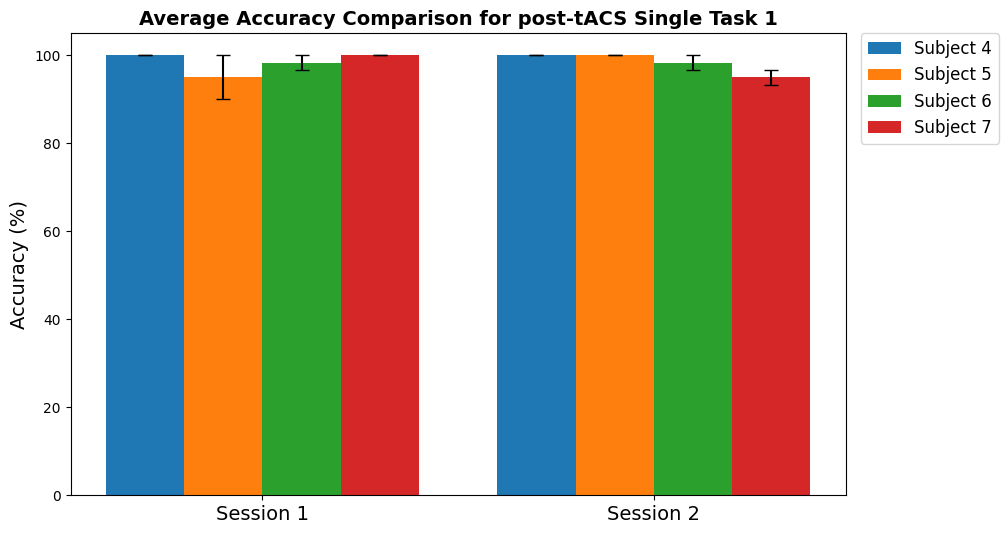

s01_post_tACS_ST1_runs_accuracy: [1.         1.         0.9        1.         0.96666667 1.
 1.         1.        ]
s02_post_tACS_ST1_runs_accuracy: [1.         1.         1.         1.         1.         0.96666667
 0.93333333 0.96666667]
Inter Session post tACS Single Task 1 Paired t-test results:
Inter Session post tACS Single Task 1 t-statistic: 0.0
Inter Session post tACS Single Task 1 p-value: 1.0
Inter Session post tACS Single Task 1 - Fail to reject the null hypothesis: There is no significant difference between the means.
Inter Session post tACS Single Task 1 Wilcoxon signed-rank test results:
Inter Session post tACS Single Task 1 W-statistic: 7.0
Inter Session post tACS Single Task 1 p-value: 0.8907458009320663
Inter Session post tACS Single Task 1 - Fail to reject the null hypothesis: There is no significant difference between the medians.


In [46]:
# Calculate the averages and standard deviations of the first two elements for each session
avg_subject4 = np.mean([s04_s01_post_tACS_runs_accuracy[:2], s04_s02_post_tACS_runs_accuracy[:2]], axis=1)
std_subject4 = np.std([s04_s01_post_tACS_runs_accuracy[:2], s04_s02_post_tACS_runs_accuracy[:2]], axis=1)
avg_subject5 = np.mean([s05_s01_post_tACS_runs_accuracy[:2], s05_s02_post_tACS_runs_accuracy[:2]], axis=1)
std_subject5 = np.std([s05_s01_post_tACS_runs_accuracy[:2], s05_s02_post_tACS_runs_accuracy[:2]], axis=1)
avg_subject6 = np.mean([s06_s01_post_tACS_runs_accuracy[:2], s06_s02_post_tACS_runs_accuracy[:2]], axis=1)
std_subject6 = np.std([s06_s01_post_tACS_runs_accuracy[:2], s06_s02_post_tACS_runs_accuracy[:2]], axis=1)
avg_subject7 = np.mean([s07_s01_post_tACS_runs_accuracy[:2], s07_s02_post_tACS_runs_accuracy[:2]], axis=1)
std_subject7 = np.std([s07_s01_post_tACS_runs_accuracy[:2], s07_s02_post_tACS_runs_accuracy[:2]], axis=1)

# Plot clustered bar comparison with error bars
labels = ['Session 1', 'Session 2']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width * 1.5, avg_subject4 * 100, width, yerr=std_subject4 * 100, label='Subject 4', capsize=5)
rects2 = ax.bar(x - width * 0.5, avg_subject5 * 100, width, yerr=std_subject5 * 100, label='Subject 5', capsize=5)
rects3 = ax.bar(x + width * 0.5, avg_subject6 * 100, width, yerr=std_subject6 * 100, label='Subject 6', capsize=5)
rects4 = ax.bar(x + width * 1.5, avg_subject7 * 100, width, yerr=std_subject7 * 100, label='Subject 7', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=14)
#ax.set_xlabel('Task Type', fontsize=14)
ax.set_title("Average Accuracy Comparison for post-tACS Single Task 1", fontsize=14, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

plt.show()

###################

#do paired-sample t test
# Extract the first two elements from each array - session 1
s04_s01_post_tACS_runs_accuracy_first_two = s04_s01_post_tACS_runs_accuracy[:2]
s05_s01_post_tACS_runs_accuracy_first_two = s05_s01_post_tACS_runs_accuracy[:2]
s06_s01_post_tACS_runs_accuracy_first_two = s06_s01_post_tACS_runs_accuracy[:2]
s07_s01_post_tACS_runs_accuracy_first_two = s07_s01_post_tACS_runs_accuracy[:2]

# Combine the extracted elements into a new dataset
s01_post_tACS_ST1_runs_accuracy = np.concatenate([s04_s01_post_tACS_runs_accuracy_first_two,
                                              s05_s01_post_tACS_runs_accuracy_first_two,
                                              s06_s01_post_tACS_runs_accuracy_first_two,
                                              s07_s01_post_tACS_runs_accuracy_first_two])

# Output the combined dataset
print("s01_post_tACS_ST1_runs_accuracy:", s01_post_tACS_ST1_runs_accuracy)

# Extract the first two elements from each array - session 2
s04_s02_post_tACS_runs_accuracy_first_two = s04_s02_post_tACS_runs_accuracy[:2]
s05_s02_post_tACS_runs_accuracy_first_two = s05_s02_post_tACS_runs_accuracy[:2]
s06_s02_post_tACS_runs_accuracy_first_two = s06_s02_post_tACS_runs_accuracy[:2]
s07_s02_post_tACS_runs_accuracy_first_two = s07_s02_post_tACS_runs_accuracy[:2]

# Combine the extracted elements into a new dataset
s02_post_tACS_ST1_runs_accuracy = np.concatenate([s04_s02_post_tACS_runs_accuracy_first_two,
                                              s05_s02_post_tACS_runs_accuracy_first_two,
                                              s06_s02_post_tACS_runs_accuracy_first_two,
                                              s07_s02_post_tACS_runs_accuracy_first_two])

# Output the combined dataset
print("s02_post_tACS_ST1_runs_accuracy:", s02_post_tACS_ST1_runs_accuracy)

# Perform paired sample t-test
t_statistic, p_value = stats.ttest_rel(s01_post_tACS_ST1_runs_accuracy, s02_post_tACS_ST1_runs_accuracy)

# Print the results
print("Inter Session post tACS Single Task 1 Paired t-test results:")
print("Inter Session post tACS Single Task 1 t-statistic:", t_statistic)
print("Inter Session post tACS Single Task 1 p-value:", p_value)

# Interpostt the results
alpha = 0.05
if p_value < alpha:
    print("Inter Session post tACS Single Task 1 - Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Inter Session post tACS Single Task 1 - Fail to reject the null hypothesis: There is no significant difference between the means.")

#Since there are only 8 samples, try non-parametric t test:
# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(s01_post_tACS_ST1_runs_accuracy, s02_post_tACS_ST1_runs_accuracy)

# Print the results
print("Inter Session post tACS Single Task 1 Wilcoxon signed-rank test results:")
print("Inter Session post tACS Single Task 1 W-statistic:", w_statistic)
print("Inter Session post tACS Single Task 1 p-value:", p_value)

# Interpostt the results
alpha = 0.05
if p_value < alpha:
    print("Inter Session post tACS Single Task 1 - Reject the null hypothesis: There is a significant difference between the medians.")
else:
    print("Inter Session post tACS Single Task 1 - Fail to reject the null hypothesis: There is no significant difference between the medians.")

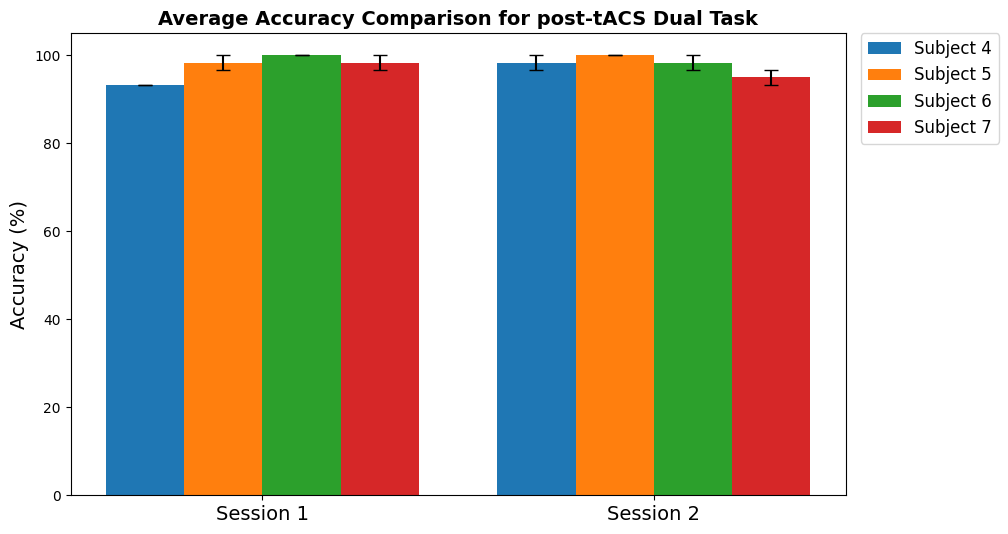

s01_post_tACS_DT_runs_accuracy: [0.93333333 0.93333333 1.         0.96666667 1.         1.
 1.         0.96666667]
s02_post_tACS_DT_runs_accuracy: [1.         0.96666667 1.         1.         0.96666667 1.
 0.93333333 0.96666667]
Inter Session post tACS Dual Task Paired t-test results:
Inter Session post tACS Dual Task t-statistic: -0.2836543144655877
Inter Session post tACS Dual Task p-value: 0.7848815134082948
Inter Session post tACS Dual Task - Fail to reject the null hypothesis: There is no significant difference between the means.
Inter Session post tACS Dual Task Wilcoxon signed-rank test results:
Inter Session post tACS Dual Task W-statistic: 6.5
Inter Session post tACS Dual Task p-value: 0.7825279247400674
Inter Session post tACS Dual Task - Fail to reject the null hypothesis: There is no significant difference between the medians.


In [47]:
# Calculate the averages and standard deviations of the last two elements for each session
avg_subject4 = np.mean([s04_s01_post_tACS_runs_accuracy[-2:], s04_s02_post_tACS_runs_accuracy[-2:]], axis=1)
std_subject4 = np.std([s04_s01_post_tACS_runs_accuracy[-2:], s04_s02_post_tACS_runs_accuracy[-2:]], axis=1)
avg_subject5 = np.mean([s05_s01_post_tACS_runs_accuracy[-2:], s05_s02_post_tACS_runs_accuracy[-2:]], axis=1)
std_subject5 = np.std([s05_s01_post_tACS_runs_accuracy[-2:], s05_s02_post_tACS_runs_accuracy[-2:]], axis=1)
avg_subject6 = np.mean([s06_s01_post_tACS_runs_accuracy[-2:], s06_s02_post_tACS_runs_accuracy[-2:]], axis=1)
std_subject6 = np.std([s06_s01_post_tACS_runs_accuracy[-2:], s06_s02_post_tACS_runs_accuracy[-2:]], axis=1)
avg_subject7 = np.mean([s07_s01_post_tACS_runs_accuracy[-2:], s07_s02_post_tACS_runs_accuracy[-2:]], axis=1)
std_subject7 = np.std([s07_s01_post_tACS_runs_accuracy[-2:], s07_s02_post_tACS_runs_accuracy[-2:]], axis=1)

# Plot clustered bar comparison with error bars
labels = ['Session 1', 'Session 2']
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width * 1.5, avg_subject4 * 100, width, yerr=std_subject4 * 100, label='Subject 4', capsize=5)
rects2 = ax.bar(x - width * 0.5, avg_subject5 * 100, width, yerr=std_subject5 * 100, label='Subject 5', capsize=5)
rects3 = ax.bar(x + width * 0.5, avg_subject6 * 100, width, yerr=std_subject6 * 100, label='Subject 6', capsize=5)
rects4 = ax.bar(x + width * 1.5, avg_subject7 * 100, width, yerr=std_subject7 * 100, label='Subject 7', capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)', fontsize=14)
#ax.set_xlabel('Task Type', fontsize=14)
ax.set_title("Average Accuracy Comparison for post-tACS Dual Task", fontsize=14, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

plt.show()

###################

#do paired-sample t test
# Extract the last two elements from each array - session 1
s04_s01_post_tACS_runs_accuracy_last_two = s04_s01_post_tACS_runs_accuracy[-2:]
s05_s01_post_tACS_runs_accuracy_last_two = s05_s01_post_tACS_runs_accuracy[-2:]
s06_s01_post_tACS_runs_accuracy_last_two = s06_s01_post_tACS_runs_accuracy[-2:]
s07_s01_post_tACS_runs_accuracy_last_two = s07_s01_post_tACS_runs_accuracy[-2:]

# Combine the extracted elements into a new dataset
s01_post_tACS_DT_runs_accuracy = np.concatenate([s04_s01_post_tACS_runs_accuracy_last_two,
                                              s05_s01_post_tACS_runs_accuracy_last_two,
                                              s06_s01_post_tACS_runs_accuracy_last_two,
                                              s07_s01_post_tACS_runs_accuracy_last_two])

# Output the combined dataset
print("s01_post_tACS_DT_runs_accuracy:", s01_post_tACS_DT_runs_accuracy)

# Extract the last two elements from each array - session 2
s04_s02_post_tACS_runs_accuracy_last_two = s04_s02_post_tACS_runs_accuracy[-2:]
s05_s02_post_tACS_runs_accuracy_last_two = s05_s02_post_tACS_runs_accuracy[-2:]
s06_s02_post_tACS_runs_accuracy_last_two = s06_s02_post_tACS_runs_accuracy[-2:]
s07_s02_post_tACS_runs_accuracy_last_two = s07_s02_post_tACS_runs_accuracy[-2:]

# Combine the extracted elements into a new dataset
s02_post_tACS_DT_runs_accuracy = np.concatenate([s04_s02_post_tACS_runs_accuracy_last_two,
                                              s05_s02_post_tACS_runs_accuracy_last_two,
                                              s06_s02_post_tACS_runs_accuracy_last_two,
                                              s07_s02_post_tACS_runs_accuracy_last_two])

# Output the combined dataset
print("s02_post_tACS_DT_runs_accuracy:", s02_post_tACS_DT_runs_accuracy)

# Perform paired sample t-test
t_statistic, p_value = stats.ttest_rel(s01_post_tACS_DT_runs_accuracy, s02_post_tACS_DT_runs_accuracy)

# Print the results
print("Inter Session post tACS Dual Task Paired t-test results:")
print("Inter Session post tACS Dual Task t-statistic:", t_statistic)
print("Inter Session post tACS Dual Task p-value:", p_value)

# Interpostt the results
alpha = 0.05
if p_value < alpha:
    print("Inter Session post tACS Dual Task - Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Inter Session post tACS Dual Task - Fail to reject the null hypothesis: There is no significant difference between the means.")

#Since there are only 8 samples, try non-parametric t test:
# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(s01_post_tACS_DT_runs_accuracy, s02_post_tACS_DT_runs_accuracy)

# Print the results
print("Inter Session post tACS Dual Task Wilcoxon signed-rank test results:")
print("Inter Session post tACS Dual Task W-statistic:", w_statistic)
print("Inter Session post tACS Dual Task p-value:", p_value)

# Interpostt the results
alpha = 0.05
if p_value < alpha:
    print("Inter Session post tACS Dual Task - Reject the null hypothesis: There is a significant difference between the medians.")
else:
    print("Inter Session post tACS Dual Task - Fail to reject the null hypothesis: There is no significant difference between the medians.")

In [48]:
from scipy.stats import ttest_rel

def interS_responseT_paired_t_test(subject_id, session_1_data, session_2_data, task_name):
    # Concatenate the data for each session
    session_1_combined = np.concatenate(session_1_data, axis=0)
    session_2_combined = np.concatenate(session_2_data, axis=0)

    # Perform paired sample t-test
    t_statistic, p_value = ttest_rel(session_1_combined, session_2_combined)

    # Print the results
    print(f"{subject_id} {task_name} paired sample t-test results:")
    print(f"{subject_id} {task_name} t-statistic:", t_statistic)
    print(f"{subject_id} {task_name} p-value:", p_value)

    # Interpret the results
    if p_value < 0.05:
        print(f"Reject the null hypothesis: There is a significant difference between session 1 and session 2 for {subject_id} {task_name}.")
    else:
        print(f"Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for {subject_id} {task_name}.")

In [49]:
interS_responseT_paired_t_test("Subject 4", [s04_s01_r01_pre_tACS_ST1_task_durations, s04_s01_r02_pre_tACS_ST1_task_durations],
              [s04_s02_r01_pre_tACS_ST1_task_durations, s04_s02_r02_pre_tACS_ST1_task_durations], "pre tACS single task 1")

Subject 4 pre tACS single task 1 paired sample t-test results:
Subject 4 pre tACS single task 1 t-statistic: 1.3663849459193826
Subject 4 pre tACS single task 1 p-value: 0.17700331191498844
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 4 pre tACS single task 1.


In [50]:
interS_responseT_paired_t_test("Subject 5", [s05_s01_r01_pre_tACS_ST1_task_durations, s05_s01_r02_pre_tACS_ST1_task_durations],
              [s05_s02_r01_pre_tACS_ST1_task_durations, s05_s02_r02_pre_tACS_ST1_task_durations], "pre tACS single task 1")

Subject 5 pre tACS single task 1 paired sample t-test results:
Subject 5 pre tACS single task 1 t-statistic: -0.2030215646854811
Subject 5 pre tACS single task 1 p-value: 0.8398167210476952
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 5 pre tACS single task 1.


In [51]:
interS_responseT_paired_t_test("Subject 6", [s06_s01_r01_pre_tACS_ST1_task_durations, s06_s01_r02_pre_tACS_ST1_task_durations],
              [s06_s02_r01_pre_tACS_ST1_task_durations, s06_s02_r02_pre_tACS_ST1_task_durations], "pre tACS single task 1")

Subject 6 pre tACS single task 1 paired sample t-test results:
Subject 6 pre tACS single task 1 t-statistic: 1.5216021575317353
Subject 6 pre tACS single task 1 p-value: 0.1334506336833147
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 6 pre tACS single task 1.


In [52]:
interS_responseT_paired_t_test("Subject 7", [s07_s01_r01_pre_tACS_ST1_task_durations, s07_s01_r02_pre_tACS_ST1_task_durations],
              [s07_s02_r01_pre_tACS_ST1_task_durations, s07_s02_r02_pre_tACS_ST1_task_durations], "pre tACS single task 1")

Subject 7 pre tACS single task 1 paired sample t-test results:
Subject 7 pre tACS single task 1 t-statistic: -0.5351253233849415
Subject 7 pre tACS single task 1 p-value: 0.5945744690373795
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 7 pre tACS single task 1.


In [53]:
interS_responseT_paired_t_test("Subject 4", [s04_s01_r01_pre_tACS_DT_task_durations, s04_s01_r02_pre_tACS_DT_task_durations],
              [s04_s02_r01_pre_tACS_DT_task_durations, s04_s02_r02_pre_tACS_DT_task_durations], "pre tACS dual task")

Subject 4 pre tACS dual task paired sample t-test results:
Subject 4 pre tACS dual task t-statistic: 1.641253960189767
Subject 4 pre tACS dual task p-value: 0.10606540881311069
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 4 pre tACS dual task.


In [54]:
interS_responseT_paired_t_test("Subject 5", [s05_s01_r01_pre_tACS_DT_task_durations, s05_s01_r02_pre_tACS_DT_task_durations],
              [s05_s02_r01_pre_tACS_DT_task_durations, s05_s02_r02_pre_tACS_DT_task_durations], "pre tACS dual task")

Subject 5 pre tACS dual task paired sample t-test results:
Subject 5 pre tACS dual task t-statistic: -1.9942616132876916
Subject 5 pre tACS dual task p-value: 0.05075104295029504
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 5 pre tACS dual task.


In [55]:
interS_responseT_paired_t_test("Subject 6", [s06_s01_r01_pre_tACS_DT_task_durations, s06_s01_r02_pre_tACS_DT_task_durations],
              [s06_s02_r01_pre_tACS_DT_task_durations, s06_s02_r02_pre_tACS_DT_task_durations], "pre tACS dual task")

Subject 6 pre tACS dual task paired sample t-test results:
Subject 6 pre tACS dual task t-statistic: 0.010758694470428602
Subject 6 pre tACS dual task p-value: 0.991452266507076
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 6 pre tACS dual task.


In [56]:
interS_responseT_paired_t_test("Subject 7", [s07_s01_r01_pre_tACS_DT_task_durations, s07_s01_r02_pre_tACS_DT_task_durations],
              [s07_s02_r01_pre_tACS_DT_task_durations, s07_s02_r02_pre_tACS_DT_task_durations], "pre tACS dual task")

Subject 7 pre tACS dual task paired sample t-test results:
Subject 7 pre tACS dual task t-statistic: -1.4359013296931422
Subject 7 pre tACS dual task p-value: 0.15631142624440292
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 7 pre tACS dual task.


In [57]:
interS_responseT_paired_t_test("Subject 4", [s04_s01_r01_post_tACS_ST1_task_durations, s04_s01_r02_post_tACS_ST1_task_durations],
              [s04_s02_r01_post_tACS_ST1_task_durations, s04_s02_r02_post_tACS_ST1_task_durations], "post tACS single task 1")

Subject 4 post tACS single task 1 paired sample t-test results:
Subject 4 post tACS single task 1 t-statistic: 1.0991501933703907
Subject 4 post tACS single task 1 p-value: 0.27616754061663784
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 4 post tACS single task 1.


In [58]:
interS_responseT_paired_t_test("Subject 5", [s05_s01_r01_post_tACS_ST1_task_durations, s05_s01_r02_post_tACS_ST1_task_durations],
              [s05_s02_r01_post_tACS_ST1_task_durations, s05_s02_r02_post_tACS_ST1_task_durations], "post tACS single task 1")

Subject 5 post tACS single task 1 paired sample t-test results:
Subject 5 post tACS single task 1 t-statistic: 0.0037591858544166034
Subject 5 post tACS single task 1 p-value: 0.9970132926115873
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 5 post tACS single task 1.


In [59]:
interS_responseT_paired_t_test("Subject 6", [s06_s01_r01_post_tACS_ST1_task_durations, s06_s01_r02_post_tACS_ST1_task_durations],
              [s06_s02_r01_post_tACS_ST1_task_durations, s06_s02_r02_post_tACS_ST1_task_durations], "post tACS single task 1")

Subject 6 post tACS single task 1 paired sample t-test results:
Subject 6 post tACS single task 1 t-statistic: 1.1135469779330425
Subject 6 post tACS single task 1 p-value: 0.26998969192666794
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 6 post tACS single task 1.


In [60]:
interS_responseT_paired_t_test("Subject 7", [s07_s01_r01_post_tACS_ST1_task_durations, s07_s01_r02_post_tACS_ST1_task_durations],
              [s07_s02_r01_post_tACS_ST1_task_durations, s07_s02_r02_post_tACS_ST1_task_durations], "post tACS single task 1")

Subject 7 post tACS single task 1 paired sample t-test results:
Subject 7 post tACS single task 1 t-statistic: -0.9404295100023645
Subject 7 post tACS single task 1 p-value: 0.350831811172737
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 7 post tACS single task 1.


In [61]:
interS_responseT_paired_t_test("Subject 4", [s04_s01_r01_post_tACS_DT_task_durations, s04_s01_r02_post_tACS_DT_task_durations],
              [s04_s02_r01_post_tACS_DT_task_durations, s04_s02_r02_post_tACS_DT_task_durations], "post tACS dual task")

Subject 4 post tACS dual task paired sample t-test results:
Subject 4 post tACS dual task t-statistic: -0.18096465116196234
Subject 4 post tACS dual task p-value: 0.8570155387050965
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 4 post tACS dual task.


In [62]:
interS_responseT_paired_t_test("Subject 5", [s05_s01_r01_post_tACS_DT_task_durations, s05_s01_r02_post_tACS_DT_task_durations],
              [s05_s02_r01_post_tACS_DT_task_durations, s05_s02_r02_post_tACS_DT_task_durations], "post tACS dual task")

Subject 5 post tACS dual task paired sample t-test results:
Subject 5 post tACS dual task t-statistic: 0.18047614778004267
Subject 5 post tACS dual task p-value: 0.8573972695751257
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 5 post tACS dual task.


In [63]:
interS_responseT_paired_t_test("Subject 6", [s06_s01_r01_post_tACS_DT_task_durations, s06_s01_r02_post_tACS_DT_task_durations],
              [s06_s02_r01_post_tACS_DT_task_durations, s06_s02_r02_post_tACS_DT_task_durations], "post tACS dual task")

Subject 6 post tACS dual task paired sample t-test results:
Subject 6 post tACS dual task t-statistic: 0.7294082233595981
Subject 6 post tACS dual task p-value: 0.4686379090013256
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 6 post tACS dual task.


In [64]:
interS_responseT_paired_t_test("Subject 7", [s07_s01_r01_post_tACS_DT_task_durations, s07_s01_r02_post_tACS_DT_task_durations],
              [s07_s02_r01_post_tACS_DT_task_durations, s07_s02_r02_post_tACS_DT_task_durations], "post tACS dual task")

Subject 7 post tACS dual task paired sample t-test results:
Subject 7 post tACS dual task t-statistic: -0.15059566382366796
Subject 7 post tACS dual task p-value: 0.8808083711953008
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for Subject 7 post tACS dual task.


In [65]:
#do an overall t test for all subjects pre tACS ST1 response time
interS_responseT_paired_t_test("All Subjects", [s04_s01_r01_pre_tACS_ST1_task_durations, s04_s01_r02_pre_tACS_ST1_task_durations,s05_s01_r01_pre_tACS_ST1_task_durations, s05_s01_r02_pre_tACS_ST1_task_durations,s06_s01_r01_pre_tACS_ST1_task_durations, s06_s01_r02_pre_tACS_ST1_task_durations,s07_s01_r01_pre_tACS_ST1_task_durations, s07_s01_r02_pre_tACS_ST1_task_durations],
              [s04_s02_r01_pre_tACS_ST1_task_durations, s04_s02_r02_pre_tACS_ST1_task_durations,s05_s02_r01_pre_tACS_ST1_task_durations, s05_s02_r02_pre_tACS_ST1_task_durations,s06_s02_r01_pre_tACS_ST1_task_durations, s06_s02_r02_pre_tACS_ST1_task_durations,s07_s02_r01_pre_tACS_ST1_task_durations, s07_s02_r02_pre_tACS_ST1_task_durations], "pre tACS single task 1")

All Subjects pre tACS single task 1 paired sample t-test results:
All Subjects pre tACS single task 1 t-statistic: 0.8300324199145195
All Subjects pre tACS single task 1 p-value: 0.40734876986633106
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for All Subjects pre tACS single task 1.


In [66]:
#do an overall t test for all subjects pre tACS DT response time
interS_responseT_paired_t_test("All Subjects", [s04_s01_r01_pre_tACS_DT_task_durations, s04_s01_r02_pre_tACS_DT_task_durations,s05_s01_r01_pre_tACS_DT_task_durations, s05_s01_r02_pre_tACS_DT_task_durations,s06_s01_r01_pre_tACS_DT_task_durations, s06_s01_r02_pre_tACS_DT_task_durations,s07_s01_r01_pre_tACS_DT_task_durations, s07_s01_r02_pre_tACS_DT_task_durations],
              [s04_s02_r01_pre_tACS_DT_task_durations, s04_s02_r02_pre_tACS_DT_task_durations,s05_s02_r01_pre_tACS_DT_task_durations, s05_s02_r02_pre_tACS_DT_task_durations,s06_s02_r01_pre_tACS_DT_task_durations, s06_s02_r02_pre_tACS_DT_task_durations,s07_s02_r01_pre_tACS_DT_task_durations, s07_s02_r02_pre_tACS_DT_task_durations], "pre tACS dual task")

All Subjects pre tACS dual task paired sample t-test results:
All Subjects pre tACS dual task t-statistic: -1.2126651419687084
All Subjects pre tACS dual task p-value: 0.22645516743319644
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for All Subjects pre tACS dual task.


In [67]:
#do an overall t test for all subjects post tACS ST1 response time
interS_responseT_paired_t_test("All Subjects", [s04_s01_r01_post_tACS_ST1_task_durations, s04_s01_r02_post_tACS_ST1_task_durations,s05_s01_r01_post_tACS_ST1_task_durations, s05_s01_r02_post_tACS_ST1_task_durations,s06_s01_r01_post_tACS_ST1_task_durations, s06_s01_r02_post_tACS_ST1_task_durations,s07_s01_r01_post_tACS_ST1_task_durations, s07_s01_r02_post_tACS_ST1_task_durations],
              [s04_s02_r01_post_tACS_ST1_task_durations, s04_s02_r02_post_tACS_ST1_task_durations,s05_s02_r01_post_tACS_ST1_task_durations, s05_s02_r02_post_tACS_ST1_task_durations,s06_s02_r01_post_tACS_ST1_task_durations, s06_s02_r02_post_tACS_ST1_task_durations,s07_s02_r01_post_tACS_ST1_task_durations, s07_s02_r02_post_tACS_ST1_task_durations], "post tACS single task 1")

All Subjects post tACS single task 1 paired sample t-test results:
All Subjects post tACS single task 1 t-statistic: 0.5277481967081021
All Subjects post tACS single task 1 p-value: 0.5981637227044497
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for All Subjects post tACS single task 1.


In [68]:
#do an overall t test for all subjects post tACS DT response time
interS_responseT_paired_t_test("All Subjects", [s04_s01_r01_post_tACS_DT_task_durations, s04_s01_r02_post_tACS_DT_task_durations,s05_s01_r01_post_tACS_DT_task_durations, s05_s01_r02_post_tACS_DT_task_durations,s06_s01_r01_post_tACS_DT_task_durations, s06_s01_r02_post_tACS_DT_task_durations,s07_s01_r01_post_tACS_DT_task_durations, s07_s01_r02_post_tACS_DT_task_durations],
              [s04_s02_r01_post_tACS_DT_task_durations, s04_s02_r02_post_tACS_DT_task_durations,s05_s02_r01_post_tACS_DT_task_durations, s05_s02_r02_post_tACS_DT_task_durations,s06_s02_r01_post_tACS_DT_task_durations, s06_s02_r02_post_tACS_DT_task_durations,s07_s02_r01_post_tACS_DT_task_durations, s07_s02_r02_post_tACS_DT_task_durations], "post tACS dual task")

All Subjects post tACS dual task paired sample t-test results:
All Subjects post tACS dual task t-statistic: 0.23327568260588633
All Subjects post tACS dual task p-value: 0.8157470089439172
Fail to reject the null hypothesis: There is no significant difference between session 1 and session 2 for All Subjects post tACS dual task.


In [69]:
# Row-bind round 1 and round 2 of pre tACS single task 1 together - subject 4, session 1
s04_s01_pre_tACS_ST1_task_durations = np.concatenate((s04_s01_r01_pre_tACS_ST1_task_durations, s04_s01_r02_pre_tACS_ST1_task_durations), axis=0)
# Row-bind round 1 and round 2 of pre tACS single task 1 together - subject 4, session 2
s04_s02_pre_tACS_ST1_task_durations = np.concatenate((s04_s02_r01_pre_tACS_ST1_task_durations, s04_s02_r02_pre_tACS_ST1_task_durations), axis=0)

# Row-bind round 1 and round 2 of pre tACS single task 1 together - subject 5, session 1
s05_s01_pre_tACS_ST1_task_durations = np.concatenate((s05_s01_r01_pre_tACS_ST1_task_durations, s05_s01_r02_pre_tACS_ST1_task_durations), axis=0)
# Row-bind round 1 and round 2 of pre tACS single task 1 together - subject 5, session 2
s05_s02_pre_tACS_ST1_task_durations = np.concatenate((s05_s02_r01_pre_tACS_ST1_task_durations, s05_s02_r02_pre_tACS_ST1_task_durations), axis=0)

# Row-bind round 1 and round 2 of pre tACS single task 1 together - subject 6, session 1
s06_s01_pre_tACS_ST1_task_durations = np.concatenate((s06_s01_r01_pre_tACS_ST1_task_durations, s06_s01_r02_pre_tACS_ST1_task_durations), axis=0)
# Row-bind round 1 and round 2 of pre tACS single task 1 together - subject 6, session 2
s06_s02_pre_tACS_ST1_task_durations = np.concatenate((s06_s02_r01_pre_tACS_ST1_task_durations, s06_s02_r02_pre_tACS_ST1_task_durations), axis=0)

# Row-bind round 1 and round 2 of pre tACS single task 1 together - subject 7, session 1
s07_s01_pre_tACS_ST1_task_durations = np.concatenate((s07_s01_r01_pre_tACS_ST1_task_durations, s07_s01_r02_pre_tACS_ST1_task_durations), axis=0)
# Row-bind round 1 and round 2 of pre tACS single task 1 together - subject 7, session 2
s07_s02_pre_tACS_ST1_task_durations = np.concatenate((s07_s02_r01_pre_tACS_ST1_task_durations, s07_s02_r02_pre_tACS_ST1_task_durations), axis=0)

###########

# Row-bind round 1 and round 2 of pre tACS dual task together - subject 4, session 1
s04_s01_pre_tACS_DT_task_durations = np.concatenate((s04_s01_r01_pre_tACS_DT_task_durations, s04_s01_r02_pre_tACS_DT_task_durations), axis=0)
# Row-bind round 1 and round 2 of pre tACS dual task together - subject 4, session 2
s04_s02_pre_tACS_DT_task_durations = np.concatenate((s04_s02_r01_pre_tACS_DT_task_durations, s04_s02_r02_pre_tACS_DT_task_durations), axis=0)

# Row-bind round 1 and round 2 of pre tACS dual task together - subject 5, session 1
s05_s01_pre_tACS_DT_task_durations = np.concatenate((s05_s01_r01_pre_tACS_DT_task_durations, s05_s01_r02_pre_tACS_DT_task_durations), axis=0)
# Row-bind round 1 and round 2 of pre tACS dual task together - subject 5, session 2
s05_s02_pre_tACS_DT_task_durations = np.concatenate((s05_s02_r01_pre_tACS_DT_task_durations, s05_s02_r02_pre_tACS_DT_task_durations), axis=0)

# Row-bind round 1 and round 2 of pre tACS dual task together - subject 6, session 1
s06_s01_pre_tACS_DT_task_durations = np.concatenate((s06_s01_r01_pre_tACS_DT_task_durations, s06_s01_r02_pre_tACS_DT_task_durations), axis=0)
# Row-bind round 1 and round 2 of pre tACS dual task together - subject 6, session 2
s06_s02_pre_tACS_DT_task_durations = np.concatenate((s06_s02_r01_pre_tACS_DT_task_durations, s06_s02_r02_pre_tACS_DT_task_durations), axis=0)

# Row-bind round 1 and round 2 of pre tACS dual task together - subject 7, session 1
s07_s01_pre_tACS_DT_task_durations = np.concatenate((s07_s01_r01_pre_tACS_DT_task_durations, s07_s01_r02_pre_tACS_DT_task_durations), axis=0)
# Row-bind round 1 and round 2 of pre tACS dual task together - subject 7, session 2
s07_s02_pre_tACS_DT_task_durations = np.concatenate((s07_s02_r01_pre_tACS_DT_task_durations, s07_s02_r02_pre_tACS_DT_task_durations), axis=0)

###########

# Row-bind round 1 and round 2 of post tACS single task 1 together - subject 4, session 1
s04_s01_post_tACS_ST1_task_durations = np.concatenate((s04_s01_r01_post_tACS_ST1_task_durations, s04_s01_r02_post_tACS_ST1_task_durations), axis=0)
# Row-bind round 1 and round 2 of post tACS single task 1 together - subject 4, session 2
s04_s02_post_tACS_ST1_task_durations = np.concatenate((s04_s02_r01_post_tACS_ST1_task_durations, s04_s02_r02_post_tACS_ST1_task_durations), axis=0)

# Row-bind round 1 and round 2 of post tACS single task 1 together - subject 5, session 1
s05_s01_post_tACS_ST1_task_durations = np.concatenate((s05_s01_r01_post_tACS_ST1_task_durations, s05_s01_r02_post_tACS_ST1_task_durations), axis=0)
# Row-bind round 1 and round 2 of post tACS single task 1 together - subject 5, session 2
s05_s02_post_tACS_ST1_task_durations = np.concatenate((s05_s02_r01_post_tACS_ST1_task_durations, s05_s02_r02_post_tACS_ST1_task_durations), axis=0)

# Row-bind round 1 and round 2 of post tACS single task 1 together - subject 6, session 1
s06_s01_post_tACS_ST1_task_durations = np.concatenate((s06_s01_r01_post_tACS_ST1_task_durations, s06_s01_r02_post_tACS_ST1_task_durations), axis=0)
# Row-bind round 1 and round 2 of post tACS single task 1 together - subject 6, session 2
s06_s02_post_tACS_ST1_task_durations = np.concatenate((s06_s02_r01_post_tACS_ST1_task_durations, s06_s02_r02_post_tACS_ST1_task_durations), axis=0)

# Row-bind round 1 and round 2 of post tACS single task 1 together - subject 7, session 1
s07_s01_post_tACS_ST1_task_durations = np.concatenate((s07_s01_r01_post_tACS_ST1_task_durations, s07_s01_r02_post_tACS_ST1_task_durations), axis=0)
# Row-bind round 1 and round 2 of post tACS single task 1 together - subject 7, session 2
s07_s02_post_tACS_ST1_task_durations = np.concatenate((s07_s02_r01_post_tACS_ST1_task_durations, s07_s02_r02_post_tACS_ST1_task_durations), axis=0)

###########

# Row-bind round 1 and round 2 of post tACS dual task together - subject 4, session 1
s04_s01_post_tACS_DT_task_durations = np.concatenate((s04_s01_r01_post_tACS_DT_task_durations, s04_s01_r02_post_tACS_DT_task_durations), axis=0)
# Row-bind round 1 and round 2 of post tACS dual task together - subject 4, session 2
s04_s02_post_tACS_DT_task_durations = np.concatenate((s04_s02_r01_post_tACS_DT_task_durations, s04_s02_r02_post_tACS_DT_task_durations), axis=0)

# Row-bind round 1 and round 2 of post tACS dual task together - subject 5, session 1
s05_s01_post_tACS_DT_task_durations = np.concatenate((s05_s01_r01_post_tACS_DT_task_durations, s05_s01_r02_post_tACS_DT_task_durations), axis=0)
# Row-bind round 1 and round 2 of post tACS dual task together - subject 5, session 2
s05_s02_post_tACS_DT_task_durations = np.concatenate((s05_s02_r01_post_tACS_DT_task_durations, s05_s02_r02_post_tACS_DT_task_durations), axis=0)

# Row-bind round 1 and round 2 of post tACS dual task together - subject 6, session 1
s06_s01_post_tACS_DT_task_durations = np.concatenate((s06_s01_r01_post_tACS_DT_task_durations, s06_s01_r02_post_tACS_DT_task_durations), axis=0)
# Row-bind round 1 and round 2 of post tACS dual task together - subject 6, session 2
s06_s02_post_tACS_DT_task_durations = np.concatenate((s06_s02_r01_post_tACS_DT_task_durations, s06_s02_r02_post_tACS_DT_task_durations), axis=0)

# Row-bind round 1 and round 2 of post tACS dual task together - subject 7, session 1
s07_s01_post_tACS_DT_task_durations = np.concatenate((s07_s01_r01_post_tACS_DT_task_durations, s07_s01_r02_post_tACS_DT_task_durations), axis=0)
# Row-bind round 1 and round 2 of post tACS dual task together - subject 7, session 2
s07_s02_post_tACS_DT_task_durations = np.concatenate((s07_s02_r01_post_tACS_DT_task_durations, s07_s02_r02_post_tACS_DT_task_durations), axis=0)

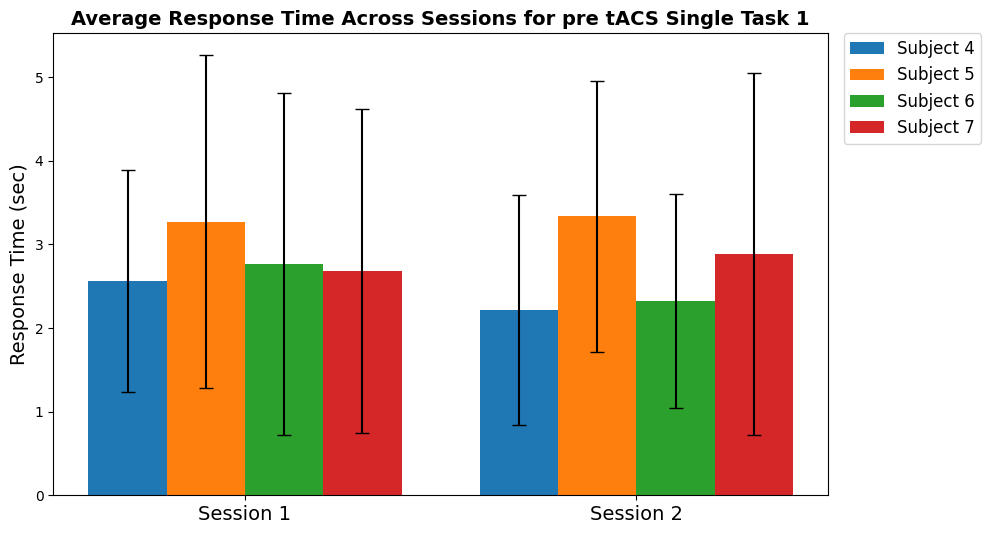

In [70]:
# Calculate average values for each subject and session
avg_s04 = [np.mean(s04_s01_pre_tACS_ST1_task_durations), np.mean(s04_s02_pre_tACS_ST1_task_durations)]
avg_s05 = [np.mean(s05_s01_pre_tACS_ST1_task_durations), np.mean(s05_s02_pre_tACS_ST1_task_durations)]
avg_s06 = [np.mean(s06_s01_pre_tACS_ST1_task_durations), np.mean(s06_s02_pre_tACS_ST1_task_durations)]
avg_s07 = [np.mean(s07_s01_pre_tACS_ST1_task_durations), np.mean(s07_s02_pre_tACS_ST1_task_durations)]

# Calculate standard error for each subject and session
std_s04 = [np.std(s04_s01_pre_tACS_ST1_task_durations), np.std(s04_s02_pre_tACS_ST1_task_durations)]
std_s05 = [np.std(s05_s01_pre_tACS_ST1_task_durations), np.std(s05_s02_pre_tACS_ST1_task_durations)]
std_s06 = [np.std(s06_s01_pre_tACS_ST1_task_durations), np.std(s06_s02_pre_tACS_ST1_task_durations)]
std_s07 = [np.std(s07_s01_pre_tACS_ST1_task_durations), np.std(s07_s02_pre_tACS_ST1_task_durations)]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(2)
width = 0.2

# Plot bars for each subject with error bars representing SEM
bars_s04 = ax.bar(x - 3*width/2, avg_s04, width, yerr=std_s04, label='Subject 4', capsize = 5)
bars_s05 = ax.bar(x - width/2, avg_s05, width, yerr=std_s05, label='Subject 5', capsize = 5)
bars_s06 = ax.bar(x + width/2, avg_s06, width, yerr=std_s06, label='Subject 6', capsize = 5)
bars_s07 = ax.bar(x + 3*width/2, avg_s07, width, yerr=std_s07, label='Subject 7' ,capsize = 5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Response Time (sec)', fontsize=14)
#ax.set_xlabel('Task Type', fontsize=14)
ax.set_title("Average Response Time Across Sessions for pre tACS Single Task 1", fontsize=14, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

plt.show()

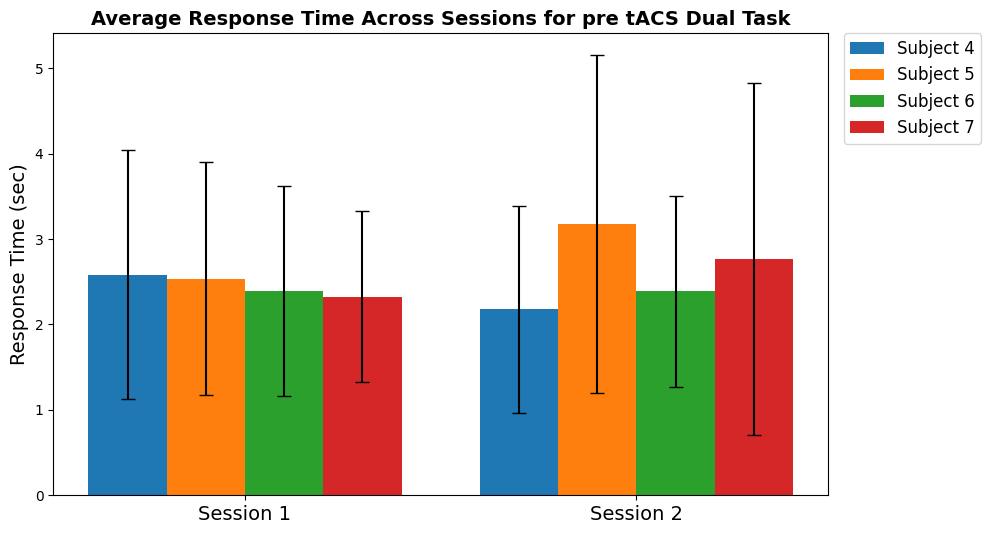

In [71]:
# Calculate average values for each subject and session
avg_s04 = [np.mean(s04_s01_pre_tACS_DT_task_durations), np.mean(s04_s02_pre_tACS_DT_task_durations)]
avg_s05 = [np.mean(s05_s01_pre_tACS_DT_task_durations), np.mean(s05_s02_pre_tACS_DT_task_durations)]
avg_s06 = [np.mean(s06_s01_pre_tACS_DT_task_durations), np.mean(s06_s02_pre_tACS_DT_task_durations)]
avg_s07 = [np.mean(s07_s01_pre_tACS_DT_task_durations), np.mean(s07_s02_pre_tACS_DT_task_durations)]

# Calculate standard error for each subject and session
std_s04 = [np.std(s04_s01_pre_tACS_DT_task_durations), np.std(s04_s02_pre_tACS_DT_task_durations)]
std_s05 = [np.std(s05_s01_pre_tACS_DT_task_durations), np.std(s05_s02_pre_tACS_DT_task_durations)]
std_s06 = [np.std(s06_s01_pre_tACS_DT_task_durations), np.std(s06_s02_pre_tACS_DT_task_durations)]
std_s07 = [np.std(s07_s01_pre_tACS_DT_task_durations), np.std(s07_s02_pre_tACS_DT_task_durations)]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(2)
width = 0.2

# Plot bars for each subject with error bars representing SEM
bars_s04 = ax.bar(x - 3*width/2, avg_s04, width, yerr=std_s04, label='Subject 4', capsize = 5)
bars_s05 = ax.bar(x - width/2, avg_s05, width, yerr=std_s05, label='Subject 5', capsize = 5)
bars_s06 = ax.bar(x + width/2, avg_s06, width, yerr=std_s06, label='Subject 6', capsize = 5)
bars_s07 = ax.bar(x + 3*width/2, avg_s07, width, yerr=std_s07, label='Subject 7' ,capsize = 5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Response Time (sec)', fontsize=14)
#ax.set_xlabel('Task Type', fontsize=14)
ax.set_title("Average Response Time Across Sessions for pre tACS Dual Task", fontsize=14, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

plt.show()

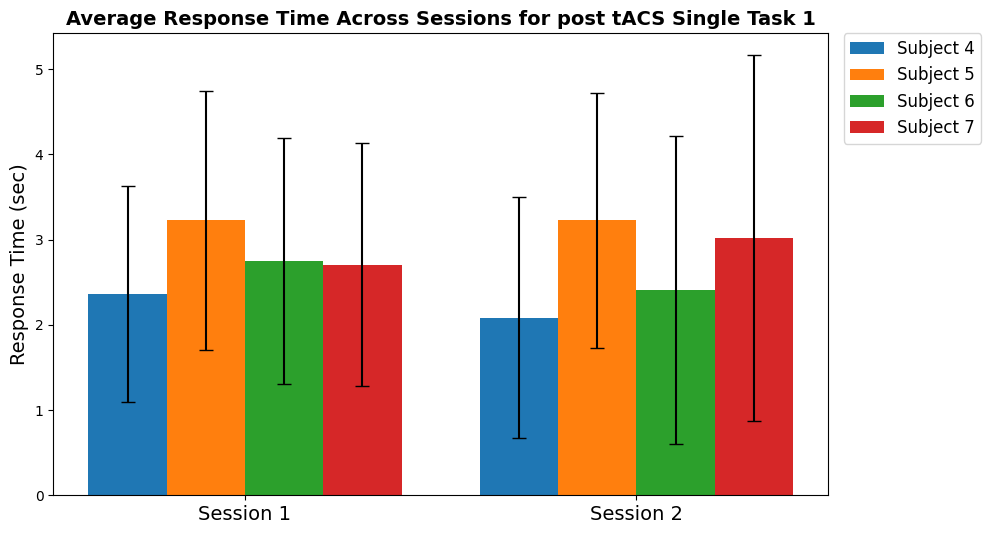

In [72]:
# Calculate average values for each subject and session
avg_s04 = [np.mean(s04_s01_post_tACS_ST1_task_durations), np.mean(s04_s02_post_tACS_ST1_task_durations)]
avg_s05 = [np.mean(s05_s01_post_tACS_ST1_task_durations), np.mean(s05_s02_post_tACS_ST1_task_durations)]
avg_s06 = [np.mean(s06_s01_post_tACS_ST1_task_durations), np.mean(s06_s02_post_tACS_ST1_task_durations)]
avg_s07 = [np.mean(s07_s01_post_tACS_ST1_task_durations), np.mean(s07_s02_post_tACS_ST1_task_durations)]

# Calculate standard error for each subject and session
std_s04 = [np.std(s04_s01_post_tACS_ST1_task_durations), np.std(s04_s02_post_tACS_ST1_task_durations)]
std_s05 = [np.std(s05_s01_post_tACS_ST1_task_durations), np.std(s05_s02_post_tACS_ST1_task_durations)]
std_s06 = [np.std(s06_s01_post_tACS_ST1_task_durations), np.std(s06_s02_post_tACS_ST1_task_durations)]
std_s07 = [np.std(s07_s01_post_tACS_ST1_task_durations), np.std(s07_s02_post_tACS_ST1_task_durations)]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(2)
width = 0.2

# Plot bars for each subject with error bars repostsenting SEM
bars_s04 = ax.bar(x - 3*width/2, avg_s04, width, yerr=std_s04, label='Subject 4', capsize = 5)
bars_s05 = ax.bar(x - width/2, avg_s05, width, yerr=std_s05, label='Subject 5', capsize = 5)
bars_s06 = ax.bar(x + width/2, avg_s06, width, yerr=std_s06, label='Subject 6', capsize = 5)
bars_s07 = ax.bar(x + 3*width/2, avg_s07, width, yerr=std_s07, label='Subject 7' ,capsize = 5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Response Time (sec)', fontsize=14)
#ax.set_xlabel('Task Type', fontsize=14)
ax.set_title("Average Response Time Across Sessions for post tACS Single Task 1", fontsize=14, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

plt.show()

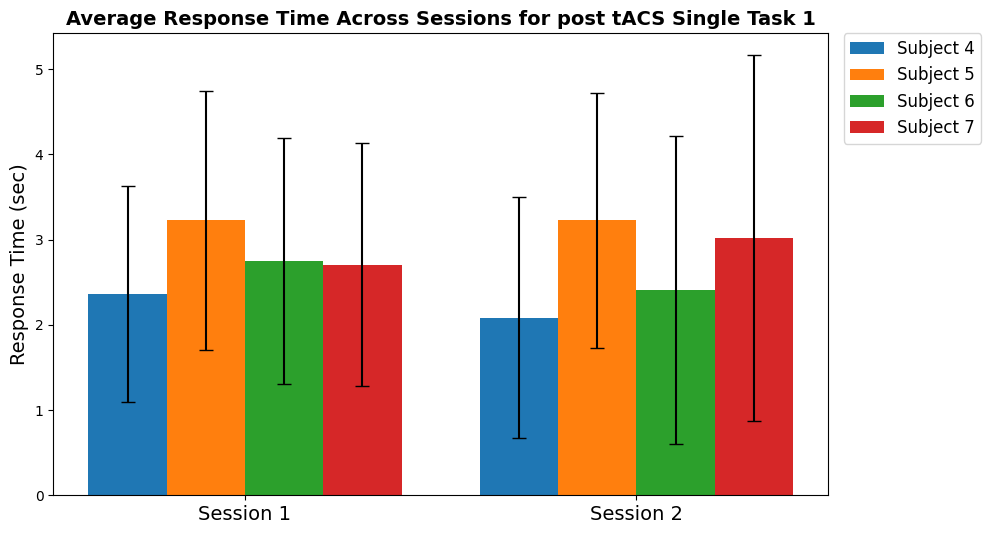

In [73]:
# Calculate average values for each subject and session
avg_s04 = [np.mean(s04_s01_post_tACS_ST1_task_durations), np.mean(s04_s02_post_tACS_ST1_task_durations)]
avg_s05 = [np.mean(s05_s01_post_tACS_ST1_task_durations), np.mean(s05_s02_post_tACS_ST1_task_durations)]
avg_s06 = [np.mean(s06_s01_post_tACS_ST1_task_durations), np.mean(s06_s02_post_tACS_ST1_task_durations)]
avg_s07 = [np.mean(s07_s01_post_tACS_ST1_task_durations), np.mean(s07_s02_post_tACS_ST1_task_durations)]

# Calculate standard error for each subject and session
std_s04 = [np.std(s04_s01_post_tACS_ST1_task_durations), np.std(s04_s02_post_tACS_ST1_task_durations)]
std_s05 = [np.std(s05_s01_post_tACS_ST1_task_durations), np.std(s05_s02_post_tACS_ST1_task_durations)]
std_s06 = [np.std(s06_s01_post_tACS_ST1_task_durations), np.std(s06_s02_post_tACS_ST1_task_durations)]
std_s07 = [np.std(s07_s01_post_tACS_ST1_task_durations), np.std(s07_s02_post_tACS_ST1_task_durations)]

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(2)
width = 0.2

# Plot bars for each subject with error bars repostsenting SEM
bars_s04 = ax.bar(x - 3*width/2, avg_s04, width, yerr=std_s04, label='Subject 4', capsize = 5)
bars_s05 = ax.bar(x - width/2, avg_s05, width, yerr=std_s05, label='Subject 5', capsize = 5)
bars_s06 = ax.bar(x + width/2, avg_s06, width, yerr=std_s06, label='Subject 6', capsize = 5)
bars_s07 = ax.bar(x + 3*width/2, avg_s07, width, yerr=std_s07, label='Subject 7' ,capsize = 5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Response Time (sec)', fontsize=14)
#ax.set_xlabel('Task Type', fontsize=14)
ax.set_title("Average Response Time Across Sessions for post tACS Single Task 1", fontsize=14, fontweight='bold')
ax.set_xticks(x, labels, fontsize=14)
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, fontsize=12)

plt.show()

# Cleaning




## Loading Filtered

This data has been prefiltered using EEGLAB. Notch filtered for powerline noise, filtered for only alpha and theta bands. Removed "bad channels." rereferenced the data by average referencing.

In [8]:
# Pre-tACS Filtered Data

# Subject 4
s04_s01_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_pre_tACS_path + '/filtered/set/f_s04_s01_r01_EO.set').load_data()
s04_s01_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_pre_tACS_path + '/filtered/set/f_s04_s01_r01_ST1.set').load_data()
s04_s01_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_pre_tACS_path + '/filtered/set/f_s04_s01_r02_ST1.set').load_data()
s04_s01_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_pre_tACS_path + '/filtered/set/f_s04_s01_r01_ST2.set').load_data()
s04_s01_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_pre_tACS_path + '/filtered/set/f_s04_s01_r01_DT.set').load_data()
s04_s01_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_pre_tACS_path + '/filtered/set/f_s04_s01_r02_DT.set').load_data()

# Subject 5
s05_s01_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_pre_tACS_path + '/filtered/set/f_s05_s01_r01_EO.set').load_data()
s05_s01_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_pre_tACS_path + '/filtered/set/f_s05_s01_r01_ST1.set').load_data()
s05_s01_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_pre_tACS_path + '/filtered/set/f_s05_s01_r02_ST1.set').load_data()
s05_s01_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_pre_tACS_path + '/filtered/set/f_s05_s01_r01_ST2.set').load_data()
s05_s01_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_pre_tACS_path + '/filtered/set/f_s05_s01_r01_DT.set').load_data()
s05_s01_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_pre_tACS_path + '/filtered/set/f_s05_s01_r02_DT.set').load_data()

# Subject 6
s06_s01_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_pre_tACS_path + '/filtered/set/f_s06_s01_r01_EO.set').load_data()
s06_s01_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_pre_tACS_path + '/filtered/set/f_s06_s01_r01_ST1.set').load_data()
s06_s01_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_pre_tACS_path + '/filtered/set/f_s06_s01_r02_ST1.set').load_data()
s06_s01_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_pre_tACS_path + '/filtered/set/f_s06_s01_r01_ST2.set').load_data()
s06_s01_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_pre_tACS_path + '/filtered/set/f_s06_s01_r01_DT.set').load_data()
s06_s01_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_pre_tACS_path + '/filtered/set/f_s06_s01_r02_DT.set').load_data()

# Subject 7
print(subject_7_session2_pre_tACS_path)
s07_s01_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r01_EO.set').load_data()
s07_s01_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r01_ST1.set').load_data()
s07_s01_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r02_ST1.set').load_data()
s07_s01_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r01_ST2.set').load_data()
s07_s01_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r01_DT.set').load_data()
s07_s01_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r02_DT.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/pre_tACS/filtered/set/f_s04_s01_r01_EO.fdt
Reading 0 ... 50175  =      0.000 ...    97.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/pre_tACS/filtered/set/f_s04_s01_r01_ST1.fdt
Reading 0 ... 183807  =      0.000 ...   358.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/pre_tACS/filtered/set/f_s04_s01_r02_ST1.fdt
Reading 0 ... 157183  =      0.000 ...   306.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/pre_tACS/filtered/set/f_s04_s01_r01_ST2.fdt
Reading 0 ... 101887  =      0.000 ...   198.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/pre_tACS/filtered/set/f_s04_s01_r01_DT.fdt
Reading 0 ... 157695  =      0.000 ...   307.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Co

<ipython-input-8-15e3efbe7461>:29: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r01_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r01_EO.fdt).
  s07_s01_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r01_EO.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/pre_tACS/filtered/set/f_s07_s02_r01_ST1.fdt
Reading 0 ... 231935  =      0.000 ...   452.998 secs...


<ipython-input-8-15e3efbe7461>:30: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r01_ST1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r01_ST1.fdt).
  s07_s01_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r01_ST1.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/pre_tACS/filtered/set/f_s07_s02_r02_ST1.fdt
Reading 0 ... 170495  =      0.000 ...   332.998 secs...


<ipython-input-8-15e3efbe7461>:31: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r02_ST1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r02_ST1.fdt).
  s07_s01_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r02_ST1.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/pre_tACS/filtered/set/f_s07_s02_r01_ST2.fdt
Reading 0 ... 111103  =      0.000 ...   216.998 secs...


<ipython-input-8-15e3efbe7461>:32: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r01_ST2.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r01_ST2.fdt).
  s07_s01_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r01_ST2.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/pre_tACS/filtered/set/f_s07_s02_r01_DT.fdt


<ipython-input-8-15e3efbe7461>:33: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r01_DT.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r01_DT.fdt).
  s07_s01_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r01_DT.set').load_data()


Reading 0 ... 174079  =      0.000 ...   339.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/pre_tACS/filtered/set/f_s07_s02_r02_DT.fdt


<ipython-input-8-15e3efbe7461>:34: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r02_DT.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r02_DT.fdt).
  s07_s01_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_pre_tACS_path + '/filtered/set/f_s07_s02_r02_DT.set').load_data()


Reading 0 ... 154111  =      0.000 ...   300.998 secs...


In [9]:
# Post-tACS Filtered Data

# Subject 4
s04_s01_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_post_tACS_path + '/filtered/set/f_s04_s01_r02_EO.set').load_data()
s04_s01_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_post_tACS_path + '/filtered/set/f_s04_s01_r03_ST1.set').load_data()
s04_s01_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_post_tACS_path + '/filtered/set/f_s04_s01_r04_ST1.set').load_data()
s04_s01_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_post_tACS_path + '/filtered/set/f_s04_s01_r02_ST2.set').load_data()
s04_s01_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_post_tACS_path + '/filtered/set/f_s04_s01_r03_DT.set').load_data()
s04_s01_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session1_post_tACS_path + '/filtered/set/f_s04_s01_r04_DT.set').load_data()

# Subject 5
s05_s01_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_post_tACS_path + '/filtered/set/f_s05_s01_r02_EO.set').load_data()
s05_s01_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_post_tACS_path + '/filtered/set/f_s05_s01_r03_ST1.set').load_data()
s05_s01_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_post_tACS_path + '/filtered/set/f_s05_s01_r04_ST1.set').load_data()
s05_s01_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_post_tACS_path + '/filtered/set/f_s05_s01_r02_ST2.set').load_data()
s05_s01_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_post_tACS_path + '/filtered/set/f_s05_s01_r03_DT.set').load_data()
s05_s01_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session1_post_tACS_path + '/filtered/set/f_s05_s01_r04_DT.set').load_data()

# Subject 6
s06_s01_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_post_tACS_path + '/filtered/set/f_s06_s01_r02_EO.set').load_data()
s06_s01_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_post_tACS_path + '/filtered/set/f_s06_s01_r03_ST1.set').load_data()
s06_s01_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_post_tACS_path + '/filtered/set/f_s06_s01_r04_ST1.set').load_data()
s06_s01_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_post_tACS_path + '/filtered/set/f_s06_s01_r02_ST2.set').load_data()
s06_s01_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_post_tACS_path + '/filtered/set/f_s06_s01_r03_DT.set').load_data()
s06_s01_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session1_post_tACS_path + '/filtered/set/f_s06_s01_r04_DT.set').load_data()

# Subject 7
s07_s01_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r02_EO.set').load_data()
s07_s01_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r03_ST1.set').load_data()
s07_s01_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r04_ST1.set').load_data()
s07_s01_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r02_ST2.set').load_data()
s07_s01_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r03_DT.set').load_data()
s07_s01_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r04_DT.set').load_data()

Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/post_tACS/filtered/set/f_s04_s01_r02_EO.fdt
Reading 0 ... 49663  =      0.000 ...    96.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/post_tACS/filtered/set/f_s04_s01_r03_ST1.fdt
Reading 0 ... 148991  =      0.000 ...   290.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/post_tACS/filtered/set/f_s04_s01_r04_ST1.fdt
Reading 0 ... 147967  =      0.000 ...   288.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/post_tACS/filtered/set/f_s04_s01_r02_ST2.fdt
Reading 0 ... 100863  =      0.000 ...   196.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_1/post_tACS/filtered/set/f_s04_s01_r03_DT.fdt
Reading 0 ... 147967  =      0.000 ...   288.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Proje

<ipython-input-9-6de5f8fa625f>:28: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r02_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r02_EO.fdt).
  s07_s01_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r02_EO.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/post_tACS/filtered/set/f_s07_s02_r03_ST1.fdt
Reading 0 ... 161279  =      0.000 ...   314.998 secs...


<ipython-input-9-6de5f8fa625f>:29: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r03_ST1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r03_ST1.fdt).
  s07_s01_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r03_ST1.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/post_tACS/filtered/set/f_s07_s02_r04_ST1.fdt
Reading 0 ... 163327  =      0.000 ...   318.998 secs...


<ipython-input-9-6de5f8fa625f>:30: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r04_ST1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r04_ST1.fdt).
  s07_s01_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r04_ST1.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/post_tACS/filtered/set/f_s07_s02_r02_ST2.fdt
Reading 0 ... 103935  =      0.000 ...   202.998 secs...


<ipython-input-9-6de5f8fa625f>:31: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r02_ST2.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r02_ST2.fdt).
  s07_s01_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r02_ST2.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/post_tACS/filtered/set/f_s07_s02_r03_DT.fdt
Reading 0 ... 162815  =      0.000 ...   317.998 secs...


<ipython-input-9-6de5f8fa625f>:32: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r03_DT.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r03_DT.fdt).
  s07_s01_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r03_DT.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_2/post_tACS/filtered/set/f_s07_s02_r04_DT.fdt
Reading 0 ... 163327  =      0.000 ...   318.998 secs...


<ipython-input-9-6de5f8fa625f>:33: RuntimeWarning: Data file name in EEG.data (f_s07_s01_r04_DT.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s02_r04_DT.fdt).
  s07_s01_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session2_post_tACS_path + '/filtered/set/f_s07_s02_r04_DT.set').load_data()


In [10]:
# 2nd Post-tACS Filtered Data

# Subject 4
s04_s02_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_post_tACS_path + '/filtered/set/f_s04_s02_r02_EO.set').load_data()
s04_s02_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_post_tACS_path + '/filtered/set/f_s04_s02_r03_ST1.set').load_data()
s04_s02_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_post_tACS_path + '/filtered/set/f_s04_s02_r04_ST1.set').load_data()
s04_s02_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_post_tACS_path + '/filtered/set/f_s04_s02_r02_ST2.set').load_data()
s04_s02_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_post_tACS_path + '/filtered/set/f_s04_s02_r03_DT.set').load_data()
s04_s02_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_post_tACS_path + '/filtered/set/f_s04_s02_r04_DT.set').load_data()

# Subject 5
s05_s02_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_post_tACS_path + '/filtered/set/f_s05_s02_r02_EO.set').load_data()
s05_s02_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_post_tACS_path + '/filtered/set/f_s05_s02_r03_ST1.set').load_data()
s05_s02_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_post_tACS_path + '/filtered/set/f_s05_s02_r04_ST1.set').load_data()
s05_s02_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_post_tACS_path + '/filtered/set/f_s05_s02_r02_ST2.set').load_data()
s05_s02_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_post_tACS_path + '/filtered/set/f_s05_s02_r03_DT.set').load_data()
s05_s02_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_post_tACS_path + '/filtered/set/f_s05_s02_r04_DT.set').load_data()

# Subject 6
s06_s02_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_post_tACS_path + '/filtered/set/f_s06_s02_r02_EO.set').load_data()
s06_s02_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_post_tACS_path + '/filtered/set/f_s06_s02_r03_ST1.set').load_data()
s06_s02_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_post_tACS_path + '/filtered/set/f_s06_s02_r04_ST1.set').load_data()
s06_s02_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_post_tACS_path + '/filtered/set/f_s06_s02_r02_ST2.set').load_data()
s06_s02_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_post_tACS_path + '/filtered/set/f_s06_s02_r03_DT.set').load_data()
s06_s02_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_post_tACS_path + '/filtered/set/f_s06_s02_r04_DT.set').load_data()

# Subject 7
s07_s02_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r02_EO.set').load_data()
s07_s02_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r03_ST1.set').load_data()
s07_s02_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r04_ST1.set').load_data()
s07_s02_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r02_ST2.set').load_data()
s07_s02_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r03_DT.set').load_data()
s07_s02_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r04_DT.set').load_data()

Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/post_tACS/filtered/set/f_s04_s02_r02_EO.fdt
Reading 0 ... 51711  =      0.000 ...   100.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/post_tACS/filtered/set/f_s04_s02_r03_ST1.fdt
Reading 0 ... 141823  =      0.000 ...   276.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/post_tACS/filtered/set/f_s04_s02_r04_ST1.fdt
Reading 0 ... 148991  =      0.000 ...   290.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/post_tACS/filtered/set/f_s04_s02_r02_ST2.fdt
Reading 0 ... 100863  =      0.000 ...   196.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/post_tACS/filtered/set/f_s04_s02_r03_DT.fdt
Reading 0 ... 152575  =      0.000 ...   297.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Proje

<ipython-input-10-b309c6906ec0>:28: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r02_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r02_EO.fdt).
  s07_s02_r02_EO_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r02_EO.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/post_tACS/filtered/set/f_s07_s01_r03_ST1.fdt
Reading 0 ... 155135  =      0.000 ...   302.998 secs...


<ipython-input-10-b309c6906ec0>:29: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r03_ST1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r03_ST1.fdt).
  s07_s02_r03_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r03_ST1.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/post_tACS/filtered/set/f_s07_s01_r04_ST1.fdt
Reading 0 ... 156671  =      0.000 ...   305.998 secs...


<ipython-input-10-b309c6906ec0>:30: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r04_ST1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r04_ST1.fdt).
  s07_s02_r04_ST1_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r04_ST1.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/post_tACS/filtered/set/f_s07_s01_r02_ST2.fdt
Reading 0 ... 102911  =      0.000 ...   200.998 secs...


<ipython-input-10-b309c6906ec0>:31: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r02_ST2.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r02_ST2.fdt).
  s07_s02_r02_ST2_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r02_ST2.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/post_tACS/filtered/set/f_s07_s01_r03_DT.fdt
Reading 0 ... 154623  =      0.000 ...   301.998 secs...


<ipython-input-10-b309c6906ec0>:32: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r03_DT.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r03_DT.fdt).
  s07_s02_r03_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r03_DT.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/post_tACS/filtered/set/f_s07_s01_r04_DT.fdt
Reading 0 ... 164863  =      0.000 ...   321.998 secs...


<ipython-input-10-b309c6906ec0>:33: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r04_DT.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r04_DT.fdt).
  s07_s02_r04_DT_post_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_post_tACS_path + '/filtered/set/f_s07_s01_r04_DT.set').load_data()


In [11]:
# Pre-tACS Filtered Data

# Subject 4
s04_s02_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_pre_tACS_path + '/filtered/set/f_s04_s02_r01_EO.set').load_data()
s04_s02_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_pre_tACS_path + '/filtered/set/f_s04_s02_r01_ST1.set').load_data()
s04_s02_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_pre_tACS_path + '/filtered/set/f_s04_s02_r02_ST1.set').load_data()
s04_s02_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_pre_tACS_path + '/filtered/set/f_s04_s02_r01_ST2.set').load_data()
s04_s02_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_pre_tACS_path + '/filtered/set/f_s04_s02_r01_DT.set').load_data()
s04_s02_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_4_session2_pre_tACS_path + '/filtered/set/f_s04_s02_r02_DT.set').load_data()

# Subject 5
s05_s02_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_pre_tACS_path + '/filtered/set/f_s05_s02_r01_EO.set').load_data()
s05_s02_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_pre_tACS_path + '/filtered/set/f_s05_s02_r01_ST1.set').load_data()
s05_s02_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_pre_tACS_path + '/filtered/set/f_s05_s02_r02_ST1.set').load_data()
s05_s02_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_pre_tACS_path + '/filtered/set/f_s05_s02_r01_ST2.set').load_data()
s05_s02_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_pre_tACS_path + '/filtered/set/f_s05_s02_r01_DT.set').load_data()
s05_s02_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_5_session2_pre_tACS_path + '/filtered/set/f_s05_s02_r02_DT.set').load_data()

# Subject 6
s06_s02_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_pre_tACS_path + '/filtered/set/f_s06_s02_r01_EO.set').load_data()
s06_s02_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_pre_tACS_path + '/filtered/set/f_s06_s02_r01_ST1.set').load_data()
s06_s02_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_pre_tACS_path + '/filtered/set/f_s06_s02_r02_ST1.set').load_data()
s06_s02_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_pre_tACS_path + '/filtered/set/f_s06_s02_r01_ST2.set').load_data()
s06_s02_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_pre_tACS_path + '/filtered/set/f_s06_s02_r01_DT.set').load_data()
s06_s02_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_6_session2_pre_tACS_path + '/filtered/set/f_s06_s02_r02_DT.set').load_data()

# Subject 7
print(subject_7_session2_pre_tACS_path)
s07_s02_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r01_EO.set').load_data()
s07_s02_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r01_ST1.set').load_data()
s07_s02_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r02_ST1.set').load_data()
s07_s02_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r01_ST2.set').load_data()
s07_s02_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r01_DT.set').load_data()
s07_s02_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r02_DT.set').load_data()

Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/pre_tACS/filtered/set/f_s04_s02_r01_EO.fdt
Reading 0 ... 57343  =      0.000 ...   111.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/pre_tACS/filtered/set/f_s04_s02_r01_ST1.fdt
Reading 0 ... 147967  =      0.000 ...   288.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/pre_tACS/filtered/set/f_s04_s02_r02_ST1.fdt
Reading 0 ... 146943  =      0.000 ...   286.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/pre_tACS/filtered/set/f_s04_s02_r01_ST2.fdt
Reading 0 ... 100863  =      0.000 ...   196.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s04/session_2/pre_tACS/filtered/set/f_s04_s02_r01_DT.fdt
Reading 0 ... 154111  =      0.000 ...   300.998 secs...
Reading /content/drive/MyDrive/ECE 385J Team Project/Project Co

<ipython-input-11-581420303b6e>:29: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r01_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r01_EO.fdt).
  s07_s02_r01_EO_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r01_EO.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/pre_tACS/filtered/set/f_s07_s01_r01_ST1.fdt
Reading 0 ... 180735  =      0.000 ...   352.998 secs...


<ipython-input-11-581420303b6e>:30: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r01_ST1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r01_ST1.fdt).
  s07_s02_r01_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r01_ST1.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/pre_tACS/filtered/set/f_s07_s01_r02_ST1.fdt
Reading 0 ... 160255  =      0.000 ...   312.998 secs...


<ipython-input-11-581420303b6e>:31: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r02_ST1.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r02_ST1.fdt).
  s07_s02_r02_ST1_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r02_ST1.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/pre_tACS/filtered/set/f_s07_s01_r01_ST2.fdt
Reading 0 ... 101887  =      0.000 ...   198.998 secs...


<ipython-input-11-581420303b6e>:32: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r01_ST2.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r01_ST2.fdt).
  s07_s02_r01_ST2_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r01_ST2.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/pre_tACS/filtered/set/f_s07_s01_r01_DT.fdt
Reading 0 ... 147455  =      0.000 ...   287.998 secs...


<ipython-input-11-581420303b6e>:33: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r01_DT.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r01_DT.fdt).
  s07_s02_r01_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r01_DT.set').load_data()


Reading /content/drive/MyDrive/ECE 385J Team Project/Project Code & Data/s07/session_1/pre_tACS/filtered/set/f_s07_s01_r02_DT.fdt
Reading 0 ... 150015  =      0.000 ...   292.998 secs...


<ipython-input-11-581420303b6e>:34: RuntimeWarning: Data file name in EEG.data (f_s07_s02_r02_DT.fdt) is incorrect, the file name must have changed on disk, using the correct file name (f_s07_s01_r02_DT.fdt).
  s07_s02_r02_DT_pre_tACS_filt = mne.io.read_raw_eeglab(subject_7_session1_pre_tACS_path + '/filtered/set/f_s07_s01_r02_DT.set').load_data()


ASR + other automatic cleaning agencies:


**EMG Analysis**

Note from Diego: We recommend using an EEG reading and preprocessing program compatible with the .gdf format (e.g.
EEGLAB). For preprocessing, you can be guided by the many online guides. You can make use of an
automatic EEG cleaner such as Clean Rawdata, and it is recommended to use a data corrector such as ASR,
and also to use ICA for blink artifact removal. To do time-frequency analysis, the same program selected
for preprocessing can be used.




In [12]:
# baseline it - cross subject cross section comparison
# synchrony of EMG
# psd to isolate region (or fft): area under the curve -- note PSD contains harmonics so sometimes preferential to include in neurological data
# feature extraction : band power analysis
#
# after removing M1 and M2 For prefrontal analysis starting at 0 - FZ, F3, F4, FC1, FC2. Indicie Channels = 5, 4, 6, 9, 10
# For parietal analysis  - Pz, P3, P4, POz. Indicie Channels = 23,22, 24, 26



## Name Standardizing



In [13]:
def naming_standard(data_raw):
  ch_names = data_raw.ch_names
  ten_five = mne.channels.make_standard_montage('standard_1005')
  updated_a = replacement(data_raw.ch_names,  ten_five.ch_names)
  updated_eeg = data_raw.copy().rename_channels({orig: new for orig, new in zip(ch_names, updated_a)})
  # Remove non standard channels
  bad_channels = [name for name in updated_a if name not in ten_five.ch_names]
  updated_eeg.info['bads'] = bad_channels
  updated_eeg.drop_channels(bad_channels)
  # Assign montage
  montage = mne.channels.make_standard_montage('standard_1005')
  updated_eeg.set_montage(montage)
  return updated_eeg

#uncomment for debugging
#naming_standard(s04_s01_r04_DT_post_tACS_filt )

from difflib import get_close_matches

def closest_match(item, options, cutoff=0.8):
    # Get the closest match for the item in the list of options
    closest_match = get_close_matches(item.lower(), options, n=1, cutoff=cutoff)
    if closest_match:
        return closest_match[0]
    else:
        return item

def replacement(a, b, cutoff=0.8):
    # Convert list 'b' to lowercase for case-insensitive comparison
    b_lower = [code.lower() for code in b]

    # Replace entries in list 'a' with closest matching entries from list 'b'
    updated_a = []
    for item in a:
        # Find closest match in list 'b'
        cm = closest_match(item, b_lower, cutoff)
        if cm in b_lower:
            # If match found, append the corresponding item from list 'b'
            index = b_lower.index(cm)
            updated_a.append(b[index])
        else:
            # If no match found, keep the original item from list 'a'
            updated_a.append(item)
    return updated_a


## ICA




 **ICA:**

Execute ICA within the epoching function

In [2]:
def run_ica(raw,reject_components=None, reject_log = None, n_components= 11, random_state=5):
  '''
    Perform Independent Component Analysis (ICA) on raw EEG data.
  '''
    # Perform ICA decomposition
  #ica = mne.preprocessing.ICA( method="infomax", fit_params=dict(extended=True), random_state=random_state)
  ica = mne.preprocessing.ICA(n_components=n_components, method="infomax", fit_params=dict(extended=True), random_state=random_state)
  ica.fit(raw, reject = reject_log)

   # Mark components for rejection
  if reject_components:
      ica.exclude = reject_components

  #uncomment to get percent of explained ratio
  #explained_var_ratio = ica.get_explained_variance_ratio(raw)
  #for channel_type, ratio in explained_var_ratio.items():
   # print(
   #     f"Fraction of {channel_type} variance explained by all components: " f"{ratio}"
  #  )

  #uncomment if you want to determine number of components manually instead of using variance threshold
  #num_components = determine_num_components(ica, raw)
  #print = num_components
  #uncomment to plot time series of ica
  #ica.plot_sources(raw, show_scrollbars=False)
  #ica.plot_overlay(raw, exclude=[0], picks="eeg")
  #ica.plot_properties(raw, picks=[0, 1, 2, 3])
  raw_clean = ica.apply(raw.copy())
  return ica, raw_clean

def determine_num_components(ica, raw, desired_variance_ratio=0.9):
  """
  manually determine the number of components needed to explain a desired percentage of variance.
  """
  sources = ica.get_sources(raw)
  variances = np.var(sources.get_data(), axis=1)
    # Sort variances in descending order
  sorted_variances = np.sort(variances)[::-1]
    # Calculate explained variance ratio
  explained_var_ratio = np.cumsum(sorted_variances) / np.sum(sorted_variances)
    # Determine the number of components needed to explain desired variance ratio
  num_components = np.argmax(explained_var_ratio >= desired_variance_ratio) + 1
  percent_variances = []
  for i, variance in enumerate(variances[:26]):
    percent_variance = (variance / np.sum(variances)) * 100
    percent_variances.append(percent_variance)
    print(f"Component {i+1}: Variance = {variance:.4f}, Percent Variance = {percent_variance:.2f}%")
    # Plot the singular values, comnment in if want visual inspection
    # singular_values = np.abs(ica.get_components())
    # plt.figure(figsize=(8, 6))
    # plt.plot(range(1, len(singular_values) + 1), singular_values, marker='o', linestyle='-')
    # plt.xlabel('Component Number')
    # plt.ylabel('Singular Value')
    # plt.title('Singular Values of ICA Components')
    # plt.grid(True)
    # plt.show()
    # ica.plot_components()
  return num_components

## Baselining

In [15]:
def baseline_correction(data_raw, baseline_data):
  channel_means_baseline = np.mean(data_raw.get_data(), axis = 1)
  task_eeg_filtered_data_all_channels_info = data_raw.info
  pre_baseline_task_eeg_filtered_data_all_channels = data_raw.get_data()
  num_channels = channel_means_baseline.size
  for channel in range(0, num_channels):
    channel_mean = channel_means_baseline[channel]
    # Extract Row from EEG data and subtract channel mean from each sample
    pre_baseline_task_eeg_filtered_data_all_channels[channel] -= channel_mean

  # Convert numpy array back to MNE object
  #baselined_task_eeg_filtered_data_all_channels = mne.io.RawArray(pre_baseline_task_eeg_filtered_data_all_channels, task_eeg_filtered_data_all_channels_info)

  return pre_baseline_task_eeg_filtered_data_all_channels





## Automatic Cleaners

Methods of cleaning data looked at here are ICA-- note small variance between data so not many IC account for it. Potentially not the best method. We want to apply cleaning methods first because we could be just capturing strong artifacts.

### ASR

Calibration

In [28]:

s04_alpha = 7
s05_alpha = 6
s06_alpha = 6
s07_alpha = 3


In [29]:
import asrpy


def ASR_raw(template, raw_data, fs:int, cutoff:int):
  asr =  asrpy.ASR (sfreq = fs, cutoff = cutoff)
  asr.fit(template.copy().crop(tmax=60))
  raw_asr = asr.transform(raw_data)

  # #uncomment to plot
  # scalings = {raw_asr:2e-8}
  # print("Uncleaned Data")
  # raw_data.plot(start = 50, scalings=scalings, title="raw scaled 2e-8");
  # print("Cleaned Data")
  # raw_asr.plot(start = 50, scalings=scalings,
  #           title="after ASR scaled 2e-8");

  return raw_asr


# uncomment to debug
#asr_sample = ASR_raw(s07_s01_r01_EO_pre_tACS_filt, s07_s01_r04_DT_post_tACS_filt, fs = 512, cutoff = 20)

In [30]:

def ASR_numpy(template, raw_data, fs:int, cutoff:int):
  M,T =  asrpy.asr_calibrate(template, sfreq = fs, cutoff = cutoff)
  raw_asr = asrpy.asr_process(raw_data, fs, M, T)

  return raw_asr



### Autoreject

In [31]:

# run on epoched data

from autoreject import get_rejection_threshold

def automatic_rejection(data_raw):
  epochs = mne.make_fixed_length_epochs(data_raw)
  reject = get_rejection_threshold(epochs)
  return reject

In [32]:
# #uncomment to debug
# standardized = naming_standard(s05_s01_r04_DT_post_tACS_filt)
# reject_thresh = automatic_rejection(standardized)
# print(reject_thresh)

# ica_test, data_test = run_ica(standardized, reject_components=[1], reject_log = reject_thresh)

# # this rejection threshold can be used in ica
# ica_test.plot_components()


In [33]:


def autoreject(epochs):
  n_interpolates = np.array([1, 2, 4])
  consensus = np.linspace(0.5, 1.0, 6)
  n_interpolates = np.array(n_interpolates)
  consensus_percs = np.linspace(concensus_percs[0], consensus_percs[1], len(n_interpolate))
  ar = AutoReject(n_interpolates, concensus_percs, random_state = 2)
  ar.fit(epochs)
  data_ar, reject_log = ar.transform(epochs, return_log=True)
  return data_ar, reject_log



### Adaptive Mixture ICA

In [34]:
def AMICA(raw_data, n_components):
  amica = mne.preprocessing.ICA(n_components = n_components, method = 'amica')
  amica.fit(raw_data.copy())
  return amica

In [35]:
#AMICA(s05_s01_r04_DT_post_tACS_filt, 2)

### Waveleft transfrorm denoising

In [36]:
import pywt

def wavelet_denoising(raw, wavelet='db4', level=3):
    """
    Apply wavelet transform-based denoising to EEG data stored in MNE Raw object.

    Parameters:
    - raw (mne.io.Raw): MNE Raw object containing EEG data.
    - wavelet (str): Wavelet type (default: 'db4').
    - level (int): Decomposition level (default: 3).

    Returns:
    - denoised_raw (mne.io.Raw): Denoised MNE Raw object.
    """
    data = raw.get_data()  # Get raw EEG data (channels x samples)
    denoised_data = np.zeros_like(data)

    for i in range(data.shape[0]):  # Loop over channels
        # Apply wavelet decomposition
        coeffs = pywt.wavedec(data[i], wavelet, level=level)

        # Thresholding (hard thresholding with universal threshold)
        threshold = np.sqrt(2 * np.log(data[i].size)) * np.median(np.abs(coeffs[-level]))
        coeffs[1:] = (pywt.threshold(c, value=threshold, mode='hard') for c in coeffs[1:])

        # Reconstruct denoised signal
        denoised_data[i] = pywt.waverec(coeffs, wavelet)

    # Create denoised MNE Raw object
    denoised_raw = raw.copy()
    denoised_raw._data = denoised_data  # Replace data with denoised data

    return denoised_raw



In [37]:
# uncomment for debugging / visualization
# denoised_wavelet = wavelet_denoising(s05_s01_r04_DT_post_tACS_filt)

# s05_s01_r04_DT_post_tACS_filt.plot(duration=10, n_channels=5, title='Original')
# denoised_wavelet.plot(duration=10, n_channels=5, title='Denoised')


### Automated Cleaning pipeline Comparison


In [38]:
def compute_snr(data):
    """Compute Signal-to-Noise Ratio (SNR) for EEG data."""
    signal_power = np.mean(np.var(data, axis=1))  # Average variance across channels
    noise = data.T - np.mean(data, axis=1)
    noise_power = np.mean(np.var(noise, axis=1))  # Average variance of noise
    #print("Signal power:", signal_power)
    #print("Noise power:", noise_power)
    snr = signal_power / noise_power
    print("SNR:", snr)
    return snr


In [40]:
from mne.minimum_norm import apply_inverse, make_inverse_operator

stand_named_EO = naming_standard(s05_s02_r01_EO_pre_tACS_filt)

stand_named_ST2 = naming_standard(s05_s02_r01_ST2_pre_tACS_filt)

print('Post filtering')

stand_snr_EO = compute_snr(stand_named_EO.get_data())

stand_snr_ST2 = compute_snr(stand_named_ST2.get_data())

stand_named_ST2 = naming_standard(s05_s02_r01_ST2_pre_tACS_filt)

baselined_EO = mne.io.RawArray(baseline_correction(stand_named_EO, s05_s02_r01_EO_pre_tACS_filt ), stand_named_EO.info)

baselined_ST2 = mne.io.RawArray(baseline_correction(stand_named_ST2, s05_s02_r01_EO_pre_tACS_filt), stand_named_ST2.info)

print('Post Baselining')
base_snr_EO = compute_snr(baselined_EO.get_data())

base_snr_ST2 = compute_snr(baselined_ST2.get_data())

print('Post wavelet denoise + baseline')
wave_denoised_EO = wavelet_denoising(baselined_EO)
wave_denoised_ST2 = wavelet_denoising(baselined_ST2)

wave_EO_snr= compute_snr(wave_denoised_EO.get_data())
wave_ST2_snr = compute_snr(wave_denoised_ST2.get_data())

print('Post wavelet denoise')
owave_denoised_EO = wavelet_denoising(stand_named_EO)
owave_denoised_ST2 = wavelet_denoising(stand_named_ST2)

owave_EO_snr= compute_snr(owave_denoised_EO.get_data())
owave_ST2_snr = compute_snr(owave_denoised_ST2.get_data())

print('Post ASR')
asr_EO = ASR_raw(stand_named_EO, stand_named_EO, 512, 20)
asr_ST2 = ASR_raw(stand_named_EO, stand_named_ST2, 512, 20)
asr_EO_snr= compute_snr(asr_EO.get_data())
asr_ST2_snr = compute_snr(asr_ST2.get_data())


Post filtering
SNR: 1.0000000000081952


NameError: name 'stand_named_ST2' is not defined

## Running Cleaning Pipeline

In [42]:
subjects = ['s04', 's05', 's06', 's07']
sessions = ['s01', 's02']
tasks = ['EO', 'ST1', 'ST2', 'DT']
runs = ['r01', 'r02', 'r03', 'r04']
tacs_conditions = ['pre_tACS', 'post_tACS']

In [ ]:


for subject in subjects:
    for session in sessions:
        for task in tasks:
            for run in runs:
                for tacs_condition in tacs_conditions:
                    # Construct the variable name
                    variable_name = f"{subject}_{session}_{run}_{task}_{tacs_condition}_filt"

                    #uncomment for debugging
                    variable_name_cleaned = f"{subject}_{session}_{run}_{task}_{tacs_condition}_cleaned"
                    variable_name_asrcleaned = f"{subject}_{session}_{run}_{task}_{tacs_condition}_asrcleaned"

                    #globals()[variable_name_cleaned] = 1

                    #print(f"Storing cleaned data in variable: {variable_name_cleaned}")
                   # print(f"Storing ASR-cleaned data in variable: {variable_name_asrcleaned}")
                   # print(s04_s01_r01_ST1_pre_tACS_cleaned)

                    # Try to get the EEG data for the current combination
                    try:
                        eeg_data = globals()[variable_name]
                    except KeyError:
                        continue


                    name_normalized = naming_standard(eeg_data)
                    trial_info = name_normalized.info

                    baseline = f"{subject}_{session}_{'r01'}_{'EO'}_{'pre_tACS'}_filt"
                    baseline_data = globals()[baseline].get_data()


                    baselined_raw = baseline_correction(name_normalized, baseline_data)

                    asr_raw = ASR_numpy(baseline_data[: , 20*512: 30*512], baselined_raw, 512, 20 )


                     # Convert numpy array back to MNE object
                    cleaned_mne = mne.io.RawArray(asr_raw, trial_info)

                    ica_obj, ica_mne = run_ica(cleaned_mne, reject_components=[1])

                    #storing
                    globals()[variable_name_cleaned] = cleaned_mne
                    globals()[variable_name_asrcleaned] = asr_raw
                    globals()[variable_name + '_ica_obj'] = ica_obj
                    globals()[variable_name + '_ica_mne'] = ica_mne

                    #ica_obj.plot_components()


Creating RawArray with float64 data, n_channels=30, n_times=50176
    Range : 0 ... 50175 =      0.000 ...    97.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 27.8s.
Fraction of eeg variance explained by all components: 0.989538619534411
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=49664
    Range : 0 ... 49663 =      0.000 ...    96.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 27.5s.
Fraction of eeg variance explained by all components: 0.9562756663189206
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=183808
    Range : 0 ... 183807 =      0.000 ...   358.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 68.6s.
Fraction of eeg variance explained by all components: 0.9535775872976895
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=157184
    Range : 0 ... 157183 =      0.000 ...   306.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 68.7s.
Fraction of eeg variance explained by all components: 0.9662718655406123
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=148992
    Range : 0 ... 148991 =      0.000 ...   290.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 69.0s.
Fraction of eeg variance explained by all components: 0.9994834195067759
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=147968
    Range : 0 ... 147967 =      0.000 ...   288.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 74.1s.
Fraction of eeg variance explained by all components: 0.9973588347178999
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=101888
    Range : 0 ... 101887 =      0.000 ...   198.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 54.3s.
Fraction of eeg variance explained by all components: 0.9481170488726324
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=100864
    Range : 0 ... 100863 =      0.000 ...   196.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 53.6s.
Fraction of eeg variance explained by all components: 0.9815439039510035
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=157696
    Range : 0 ... 157695 =      0.000 ...   307.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 55.9s.
Fraction of eeg variance explained by all components: 0.9612576290253508
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=154112
    Range : 0 ... 154111 =      0.000 ...   300.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 61.3s.
Fraction of eeg variance explained by all components: 0.9706737213884937
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=147968
    Range : 0 ... 147967 =      0.000 ...   288.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 76.5s.
Fraction of eeg variance explained by all components: 0.9619802402969095
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=148480
    Range : 0 ... 148479 =      0.000 ...   289.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 59.2s.
Fraction of eeg variance explained by all components: 0.9582533367369067
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=57344
    Range : 0 ... 57343 =      0.000 ...   111.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 25.9s.
Fraction of eeg variance explained by all components: 0.928166167834315
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=51712
    Range : 0 ... 51711 =      0.000 ...   100.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 32.0s.
Fraction of eeg variance explained by all components: 0.9506615968656764
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=147968
    Range : 0 ... 147967 =      0.000 ...   288.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 70.0s.
Fraction of eeg variance explained by all components: 0.9489283684810291
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=146944
    Range : 0 ... 146943 =      0.000 ...   286.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 61.6s.
Fraction of eeg variance explained by all components: 0.9714340148182885
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=141824
    Range : 0 ... 141823 =      0.000 ...   276.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 35.4s.
Fraction of eeg variance explained by all components: 0.9525096238995486
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=148992
    Range : 0 ... 148991 =      0.000 ...   290.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 50.0s.
Fraction of eeg variance explained by all components: 0.9649032294755959
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=100864
    Range : 0 ... 100863 =      0.000 ...   196.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 38.9s.
Fraction of eeg variance explained by all components: 0.943403617892844
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=100864
    Range : 0 ... 100863 =      0.000 ...   196.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 43.2s.
Fraction of eeg variance explained by all components: 0.9215486309881344
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=154112
    Range : 0 ... 154111 =      0.000 ...   300.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 59.9s.
Fraction of eeg variance explained by all components: 0.9337960998014895
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=149504
    Range : 0 ... 149503 =      0.000 ...   291.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 56.0s.
Fraction of eeg variance explained by all components: 0.9077867302220375
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=152576
    Range : 0 ... 152575 =      0.000 ...   297.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 38.3s.
Fraction of eeg variance explained by all components: 0.9182355593337242
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=153088
    Range : 0 ... 153087 =      0.000 ...   298.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 53.8s.
Fraction of eeg variance explained by all components: 0.9041071719168583
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=51712
    Range : 0 ... 51711 =      0.000 ...   100.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 25.3s.
Fraction of eeg variance explained by all components: 0.9602496804927216
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=49664
    Range : 0 ... 49663 =      0.000 ...    96.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 25.7s.
Fraction of eeg variance explained by all components: 0.9671240474804332
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=169472
    Range : 0 ... 169471 =      0.000 ...   330.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 72.8s.
Fraction of eeg variance explained by all components: 0.9754716122880962
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=166912
    Range : 0 ... 166911 =      0.000 ...   325.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 63.4s.
Fraction of eeg variance explained by all components: 0.9494859346104428
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=169984
    Range : 0 ... 169983 =      0.000 ...   331.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 56.8s.
Fraction of eeg variance explained by all components: 0.9614299465331557
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=156160
    Range : 0 ... 156159 =      0.000 ...   304.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 49.3s.
Fraction of eeg variance explained by all components: 0.9836789628717441
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=123392
    Range : 0 ... 123391 =      0.000 ...   240.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 32.1s.
Fraction of eeg variance explained by all components: 0.9510540990680755
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=124416
    Range : 0 ... 124415 =      0.000 ...   242.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 49.5s.
Fraction of eeg variance explained by all components: 0.9662461703798358
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=174592
    Range : 0 ... 174591 =      0.000 ...   340.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 78.7s.
Fraction of eeg variance explained by all components: 0.95356829455273
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=181760
    Range : 0 ... 181759 =      0.000 ...   354.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 44.7s.
Fraction of eeg variance explained by all components: 0.9327340789721431
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=159232
    Range : 0 ... 159231 =      0.000 ...   310.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 70.5s.
Fraction of eeg variance explained by all components: 0.9826092010778904
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=161280
    Range : 0 ... 161279 =      0.000 ...   314.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 66.1s.
Fraction of eeg variance explained by all components: 0.9667198121882293
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=57856
    Range : 0 ... 57855 =      0.000 ...   112.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 27.0s.
Fraction of eeg variance explained by all components: 0.9442654659562862
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=51712
    Range : 0 ... 51711 =      0.000 ...   100.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 34.7s.
Fraction of eeg variance explained by all components: 0.999350801207816
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=178688
    Range : 0 ... 178687 =      0.000 ...   348.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 64.7s.
Fraction of eeg variance explained by all components: 0.9561468045157646
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=163328
    Range : 0 ... 163327 =      0.000 ...   318.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 81.8s.
Fraction of eeg variance explained by all components: 0.9502991178580218
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=173056
    Range : 0 ... 173055 =      0.000 ...   337.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 66.0s.
Fraction of eeg variance explained by all components: 0.9900748581478028
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=159744
    Range : 0 ... 159743 =      0.000 ...   311.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 63.7s.
Fraction of eeg variance explained by all components: 0.993927150205716
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=114688
    Range : 0 ... 114687 =      0.000 ...   223.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 42.6s.
Fraction of eeg variance explained by all components: 0.9405921917148264
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=108032
    Range : 0 ... 108031 =      0.000 ...   210.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 38.4s.
Fraction of eeg variance explained by all components: 0.9591019168309566
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=170496
    Range : 0 ... 170495 =      0.000 ...   332.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 51.8s.
Fraction of eeg variance explained by all components: 0.9504118624990608
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=173568
    Range : 0 ... 173567 =      0.000 ...   338.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 61.6s.
Fraction of eeg variance explained by all components: 0.9272412062604316
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=182272
    Range : 0 ... 182271 =      0.000 ...   355.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 42.2s.
Fraction of eeg variance explained by all components: 0.9464512250478158
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=159232
    Range : 0 ... 159231 =      0.000 ...   310.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 64.9s.
Fraction of eeg variance explained by all components: 0.943323220012157
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=53248
    Range : 0 ... 53247 =      0.000 ...   103.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 17.5s.
Fraction of eeg variance explained by all components: 0.9667874383642002
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=50176
    Range : 0 ... 50175 =      0.000 ...    97.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 30.1s.
Fraction of eeg variance explained by all components: 0.9882543591918079
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=188928
    Range : 0 ... 188927 =      0.000 ...   368.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 75.7s.
Fraction of eeg variance explained by all components: 0.9987393096296916
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=159232
    Range : 0 ... 159231 =      0.000 ...   310.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 57.2s.
Fraction of eeg variance explained by all components: 0.9800749989647003
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=156160
    Range : 0 ... 156159 =      0.000 ...   304.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 35.4s.
Fraction of eeg variance explained by all components: 0.979709493227964
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=153600
    Range : 0 ... 153599 =      0.000 ...   299.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 52.6s.
Fraction of eeg variance explained by all components: 0.9781812077606044
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=112640
    Range : 0 ... 112639 =      0.000 ...   219.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 27.9s.
Fraction of eeg variance explained by all components: 0.9887456531402048
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=101376
    Range : 0 ... 101375 =      0.000 ...   197.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 39.9s.
Fraction of eeg variance explained by all components: 0.9895438403118213
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=161280
    Range : 0 ... 161279 =      0.000 ...   314.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 57.7s.
Fraction of eeg variance explained by all components: 0.9930995154135398
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=152576
    Range : 0 ... 152575 =      0.000 ...   297.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 53.0s.
Fraction of eeg variance explained by all components: 0.993454948830623
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=157184
    Range : 0 ... 157183 =      0.000 ...   306.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 84.5s.
Fraction of eeg variance explained by all components: 0.992159027548515
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=67072
    Range : 0 ... 67071 =      0.000 ...   130.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 37.7s.
Fraction of eeg variance explained by all components: 0.9909377451238285
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=55296
    Range : 0 ... 55295 =      0.000 ...   107.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 42.5s.
Fraction of eeg variance explained by all components: 0.9791518403351888
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=49664
    Range : 0 ... 49663 =      0.000 ...    96.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 63.4s.
Fraction of eeg variance explained by all components: 0.9558856346010872
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=172544
    Range : 0 ... 172543 =      0.000 ...   336.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 66.0s.
Fraction of eeg variance explained by all components: 0.9401870101326003
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=147456
    Range : 0 ... 147455 =      0.000 ...   287.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 61.1s.
Fraction of eeg variance explained by all components: 0.9632037480689576
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=150528
    Range : 0 ... 150527 =      0.000 ...   293.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 44.6s.
Fraction of eeg variance explained by all components: 0.9482785990073916
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=145920
    Range : 0 ... 145919 =      0.000 ...   284.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 55.5s.
Fraction of eeg variance explained by all components: 0.9452137135046459
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=100864
    Range : 0 ... 100863 =      0.000 ...   196.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 37.2s.
Fraction of eeg variance explained by all components: 0.9950371848836604
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=101888
    Range : 0 ... 101887 =      0.000 ...   198.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 48.4s.
Fraction of eeg variance explained by all components: 0.959536152254043
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=148480
    Range : 0 ... 148479 =      0.000 ...   289.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 59.2s.
Fraction of eeg variance explained by all components: 0.92458286810724
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=150528
    Range : 0 ... 150527 =      0.000 ...   293.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 90.2s.
Fraction of eeg variance explained by all components: 0.9394857152503282
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=153088
    Range : 0 ... 153087 =      0.000 ...   298.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 66.9s.
Fraction of eeg variance explained by all components: 0.9377924007850186
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=159232
    Range : 0 ... 159231 =      0.000 ...   310.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 53.0s.
Fraction of eeg variance explained by all components: 0.9516420985145908
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=67584
    Range : 0 ... 67583 =      0.000 ...   131.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 19.8s.
Fraction of eeg variance explained by all components: 0.9989385460146661
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=60928
    Range : 0 ... 60927 =      0.000 ...   118.998 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA


<ipython-input-77-eb8cd0d34bc1>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA took 72.7s.
Fraction of eeg variance explained by all components: 0.9902481829185614
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


In [ ]:
import multiprocessing

def process_data(combination):
    subject, session, task, run, tacs_condition = combination

    variable_name = f"{subject}_{session}_{run}_{task}_{tacs_condition}_filt"
    variable_name_cleaned = f"{subject}_{session}_{run}_{task}_{tacs_condition}_cleaned"
    variable_name_asrcleaned = f"{subject}_{session}_{run}_{task}_{tacs_condition}_asrcleaned"

    try:
        eeg_data = globals()[variable_name]
    except KeyError:
        return

    name_normalized = naming_standard(eeg_data)
    trial_info = name_normalized.info

    baseline = f"{subject}_{session}_{'r01'}_{'EO'}_{'pre_tACS'}_filt"
    baseline_data = globals()[baseline].get_data()

    baselined_raw = baseline_correction(name_normalized, baseline_data)
    asr_raw = ASR_numpy(baseline_data[:, 20*512: 30*512], baselined_raw, 512, 20)
    cleaned_mne = mne.io.RawArray(asr_raw, trial_info)
    ica_obj, ica_mne = run_ica(cleaned_mne, reject_components=[1])

    globals()[variable_name_cleaned] = cleaned_mne
    globals()[variable_name_asrcleaned] = asr_raw
    globals()[variable_name + '_ica_obj'] = ica_obj
    globals()[variable_name + '_ica_mne'] = ica_mne

# Define combinations
combinations = [(subject, session, task, run, tacs_condition)
                for subject in subjects
                for session in sessions
                for task in tasks
                for run in runs
                for tacs_condition in tacs_conditions]

# Use multiprocessing for parallel execution
with multiprocessing.Pool() as pool:
    pool.map(process_data, combinations)


Creating RawArray with float64 data, n_channels=30, n_times=50176
    Range : 0 ... 50175 =      0.000 ...    97.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=57344
    Range : 0 ... 57343 =      0.000 ...   111.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 66.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 73.1s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=51712
    Range : 0 ... 51711 =      0.000 ...   100.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=49664
    Range : 0 ... 49663 =      0.000 ...    96.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 53.4s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 63.2s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=183808
    Range : 0 ... 183807 =      0.000 ...   358.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=147968
    Range : 0 ... 147967 =      0.000 ...   288.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 120.2s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 122.8s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=157184
    Range : 0 ... 157183 =      0.000 ...   306.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=146944
    Range : 0 ... 146943 =      0.000 ...   286.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 107.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 114.3s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=141824
    Range : 0 ... 141823 =      0.000 ...   276.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=148992
    Range : 0 ... 148991 =      0.000 ...   290.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 70.9s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=148992
    Range : 0 ... 148991 =      0.000 ...   290.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 126.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=147968
    Range : 0 ... 147967 =      0.000 ...   288.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 92.1s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=100864
    Range : 0 ... 100863 =      0.000 ...   196.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 63.2s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 131.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=100864
    Range : 0 ... 100863 =      0.000 ...   196.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=101888
    Range : 0 ... 101887 =      0.000 ...   198.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 87.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 116.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=154112
    Range : 0 ... 154111 =      0.000 ...   300.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=100864
    Range : 0 ... 100863 =      0.000 ...   196.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 107.4s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 89.3s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=149504
    Range : 0 ... 149503 =      0.000 ...   291.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=157696
    Range : 0 ... 157695 =      0.000 ...   307.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 102.2s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 99.1s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=152576
    Range : 0 ... 152575 =      0.000 ...   297.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=154112
    Range : 0 ... 154111 =      0.000 ...   300.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 75.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=153088
    Range : 0 ... 153087 =      0.000 ...   298.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Fitting ICA took 103.1s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=147968
    Range : 0 ... 147967 =      0.000 ...   288.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 101.8s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=51712
    Range : 0 ... 51711 =      0.000 ...   100.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 94.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 43.3s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=148480
    Range : 0 ... 148479 =      0.000 ...   289.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=49664
    Range : 0 ... 49663 =      0.000 ...    96.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 52.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=169472
    Range : 0 ... 169471 =      0.000 ...   330.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 110.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=57856
    Range : 0 ... 57855 =      0.000 ...   112.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 54.8s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=51712
    Range : 0 ... 51711 =      0.000 ...   100.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 129.1s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=166912
    Range : 0 ... 166911 =      0.000 ...   325.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Fitting ICA took 55.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=178688
    Range : 0 ... 178687 =      0.000 ...   348.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 118.3s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 110.6s.
Creating RawArray with float64 data, n_channels=30, n_times=169984
Applying ICA to Raw instance
    Range : 0 ... 169983 =      0.000 ...   331.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


    Transforming to ICA space (11 components)
Fitting ICA to data using 30 channels (please be patient, this may take a while)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=163328
    Range : 0 ... 163327 =      0.000 ...   318.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 101.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=156160
    Range : 0 ... 156159 =      0.000 ...   304.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 143.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 79.2s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=173056
    Range : 0 ... 173055 =      0.000 ...   337.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=123392
    Range : 0 ... 123391 =      0.000 ...   240.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 55.5s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=124416
    Range : 0 ... 124415 =      0.000 ...   242.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 113.5s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=159744
    Range : 0 ... 159743 =      0.000 ...   311.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 90.5s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=174592
    Range : 0 ... 174591 =      0.000 ...   340.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 111.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=114688
    Range : 0 ... 114687 =      0.000 ...   223.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 61.2s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 134.5s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=108032
    Range : 0 ... 108031 =      0.000 ...   210.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=181760
    Range : 0 ... 181759 =      0.000 ...   354.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 70.5s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 75.1s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=170496
    Range : 0 ... 170495 =      0.000 ...   332.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=159232
    Range : 0 ... 159231 =      0.000 ...   310.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 94.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=173568
    Range : 0 ... 173567 =      0.000 ...   338.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 111.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=161280
    Range : 0 ... 161279 =      0.000 ...   314.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 112.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=182272
    Range : 0 ... 182271 =      0.000 ...   355.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 111.2s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=53248
    Range : 0 ... 53247 =      0.000 ...   103.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 23.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=50176
    Range : 0 ... 50175 =      0.000 ...    97.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 73.2s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=159232
    Range : 0 ... 159231 =      0.000 ...   310.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 55.5s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=188928
    Range : 0 ... 188927 =      0.000 ...   368.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 111.8s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=55296
    Range : 0 ... 55295 =      0.000 ...   107.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 139.8s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 71.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=49664
    Range : 0 ... 49663 =      0.000 ...    96.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=159232
    Range : 0 ... 159231 =      0.000 ...   310.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 116.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 111.1s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=51712
    Range : 0 ... 51711 =      0.000 ...   100.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=67584
    Range : 0 ... 67583 =      0.000 ...   131.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 36.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 46.3s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=60928
    Range : 0 ... 60927 =      0.000 ...   118.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=61952
    Range : 0 ... 61951 =      0.000 ...   120.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 69.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=180736
    Range : 0 ... 180735 =      0.000 ...   352.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 144.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=231936
    Range : 0 ... 231935 =      0.000 ...   452.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 126.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=160256
    Range : 0 ... 160255 =      0.000 ...   312.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 176.5s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=170496
    Range : 0 ... 170495 =      0.000 ...   332.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 192.4s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=155136
    Range : 0 ... 155135 =      0.000 ...   302.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 113.9s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=161280
    Range : 0 ... 161279 =      0.000 ...   314.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 68.6s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=156672
    Range : 0 ... 156671 =      0.000 ...   305.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 124.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 101.8s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=163328
    Range : 0 ... 163327 =      0.000 ...   318.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=101888
    Range : 0 ... 101887 =      0.000 ...   198.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 90.9s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 129.3s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=102912
    Range : 0 ... 102911 =      0.000 ...   200.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=111104
    Range : 0 ... 111103 =      0.000 ...   216.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 108.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 96.3s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=147456
    Range : 0 ... 147455 =      0.000 ...   287.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=103936
    Range : 0 ... 103935 =      0.000 ...   202.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 47.3s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 80.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=174080
    Range : 0 ... 174079 =      0.000 ...   339.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=150016
    Range : 0 ... 150015 =      0.000 ...   292.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 103.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 139.5s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=154624
    Range : 0 ... 154623 =      0.000 ...   301.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=154112
    Range : 0 ... 154111 =      0.000 ...   300.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 93.4s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 78.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=164864
    Range : 0 ... 164863 =      0.000 ...   321.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Creating RawArray with float64 data, n_channels=30, n_times=162816
    Range : 0 ... 162815 =      0.000 ...   317.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 121.8s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Fitting ICA took 119.0s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components
Creating RawArray with float64 data, n_channels=30, n_times=163328
    Range : 0 ... 163327 =      0.000 ...   318.998 secs
Ready.


<ipython-input-14-c7ec99c9d2db>:8: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, reject = reject_log)


Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 11 components
Computing Extended Infomax ICA
Fitting ICA took 39.7s.
Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


#Analyzing Signal to Noise Differences

## Average Brain Power

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

### Entire Brain


In [ ]:
# Define the list of subjects, sessions, tasks, and runs
subjects = ['s04', 's05', 's06', 's07']
sessions = ['s01', 's02']
tasks = ['EO', 'ST1', 'ST2', 'DT']
runs = ['r01', 'r02', 'r03', 'r04']
tacs_conditions = ['pre_tACS', 'post_tACS']

# Define the frequency bands
frequency_bands = [(3, 8),(8, 13)]

# Create dictionaries to store theta and alpha average powers
theta_average_powers = {}
alpha_average_powers = {}
eeg_powers_all = {}


for subject in subjects:
    for session in sessions:
        for task in tasks:
            for run in runs:
                for tacs_condition in tacs_conditions:
                    # Construct the variable name
                    variable_name = f"{subject}_{session}_{run}_{task}_{tacs_condition}_filt"

                    # Try to get the EEG data for the current combination
                    try:
                        eeg_data = globals()[variable_name].get_data()
                    except KeyError:
                        continue

                    # Calculate EEG power for each frequency band
                    eeg_power = nk.eeg_power(eeg=eeg_data, sampling_rate=512, frequency_band=frequency_bands)

                    # Calculate the average power for each frequency band
                    average_power = eeg_power.mean(numeric_only=True, axis=0)

                    # Extract theta and alpha average power
                    theta_average_power = average_power['Hz_3_8']
                    alpha_average_power = average_power['Hz_8_13']


                    key = (subject, session, task, run, tacs_condition)
                    theta_average_powers[key] = theta_average_power
                    alpha_average_powers[key] = alpha_average_power
                    eeg_powers_all[key] = eeg_power

                    # Print the results, uncomment for debugging
                    #print(f"Subject: {subject}, Session: {session}, Task: {task}, Run: {run}, TACS Condition: {tacs_condition}")
                    #print(f"Theta Average Power: {theta_average_power}")
                    #print(f"Alpha Average Power: {alpha_average_power}")



Averaging Theta & Alpha Power for Multiple Trials of the Same Class


In [ ]:
# Calculate average theta powers for the same subject, session, and run for ST1 and DT pre_tACS conditions
average_st1_theta_powers_pre_tacs = {}
average_dt_theta_powers_pre_tacs = {}

for key, value in theta_average_powers.items():
    subject, session, task, run, tacs_condition = key
    if tacs_condition == 'pre_tACS':
        new_key = (subject, session, run)
        if task == 'ST1':
            average_st1_theta_powers_pre_tacs[new_key] = np.mean(value)
        elif task == 'DT':
            average_dt_theta_powers_pre_tacs[new_key] = np.mean(value)

# Calculate average alpha powers for the same subject, session, and run for ST1 and DT pre_tACS conditions
average_st1_alpha_powers_pre_tacs = {}
average_dt_alpha_powers_pre_tacs = {}

for key, value in alpha_average_powers.items():
    subject, session, task, run, tacs_condition = key
    if tacs_condition == 'pre_tACS':
        new_key = (subject, session, run)
        if task == 'ST1':
            average_st1_alpha_powers_pre_tacs[new_key] = np.mean(value)
        elif task == 'DT':
            average_dt_alpha_powers_pre_tacs[new_key] = np.mean(value)

# Calculate average theta powers for the same subject, session, and run for ST1 and DT post_tACS conditions
average_st1_theta_powers_post_tacs = {}
average_dt_theta_powers_post_tacs = {}

for key, value in theta_average_powers.items():
    subject, session, task, run, tacs_condition = key
    if tacs_condition == 'post_tACS':
        new_key = (subject, session, run)
        if task == 'ST1':
            average_st1_theta_powers_post_tacs[new_key] = np.mean(value)
        elif task == 'DT':
            average_dt_theta_powers_post_tacs[new_key] = np.mean(value)

# Calculate average alpha powers for the same subject, session, and run for ST1 and DT post_tACS conditions
average_st1_alpha_powers_post_tacs = {}
average_dt_alpha_powers_post_tacs = {}

for key, value in alpha_average_powers.items():
    subject, session, task, run, tacs_condition = key
    if tacs_condition == 'post_tACS':
        new_key = (subject, session, run)
        if task == 'ST1':
            average_st1_alpha_powers_post_tacs[new_key] = np.mean(value)
        elif task == 'DT':
            average_dt_alpha_powers_post_tacs[new_key] = np.mean(value)


#### Statistical Significance

In [ ]:
from scipy import stats

def paired_t_test(subjects, pre_condition_data, post_condition_data, condition_name):
    """
    Perform paired t-test between pre and post condition data for specified subjects.

    Args:
        subjects (list): List of subjects.
        pre_condition_data (dict): Dictionary containing pre-condition data.
        post_condition_data (dict): Dictionary containing post-condition data.
        condition_name (str): Name of the condition.

    Returns:
        None (Prints t-statistic, p-value, and whether the difference is statistically significant.)
    """
    for subject in set(subjects):
        pre_values = []
        post_values = []

        # Extract pre and post values for the current subject and condition
        for key, value in pre_condition_data.items():
            if key[0] == subject:
                pre_values.append(value)

        for key, value in post_condition_data.items():
            if key[0] == subject:
                post_values.append(value)

        # Perform paired t-test
        t_statistic, p_value = stats.ttest_rel(pre_values, post_values)

        # Print the result for the current subject and condition
        print(f"Subject: {subject} {condition_name}")
        print("Paired t-test:")
        print(f"T-statistic: {t_statistic}")
        print(f"P-value: {p_value}")

        # Check if the difference is statistically significant (using a significance level of 0.05)
        if p_value < 0.05:
            print(f"There is a statistically significant difference between {condition_name}")
        else:
            print(f"There is no statistically significant difference between {condition_name}" )


In [ ]:
#run for all combinations

pre_post_alpha= paired_t_test(subjects, average_dt_alpha_powers_pre_tacs, average_dt_alpha_powers_post_tacs, "pre and post alpha powers")


**Name Normalization/ Set Montage:**




**Further Process EEG Data before Epoching**:


Using the filtered EEG data from MATLAB, complete the following preprocessing before passing data into epoching function

*   Baselining
*   ICA
*   etc


After epoching is complete, we may remove epochs with EEG values that are out of range.

### Regional Analysis


In [ ]:

# Define indices of prefrontal and parietal channels
prefrontal_indices = [5, 4, 6, 9, 10]
parietal_indices = [23, 22, 24, 26]

# Create dictionaries to store theta and alpha average powers
prefrontal_theta_average_powers = {}
prefrontal_alpha_average_powers = {}
parietal_theta_average_powers = {}
parietal_alpha_average_powers = {}
eeg_powers_all = {}

for subject in subjects:
    for session in sessions:
        for task in tasks:
            for run in runs:
                for tacs_condition in tacs_conditions:
                    # Construct the variable name
                    variable_name = f"{subject}_{session}_{run}_{task}_{tacs_condition}_filt"

                    # Try to get the EEG data for the current combination
                    try:
                        eeg_data = globals()[variable_name].get_data()
                    except KeyError:
                        continue

                    # Select prefrontal channels
                    prefrontal_data = eeg_data[prefrontal_indices]

                    # Calculate EEG power for prefrontal channels
                    prefrontal_eeg_power = nk.eeg_power(eeg=prefrontal_data, sampling_rate=512, frequency_band=frequency_bands)

                    # Calculate the average power for prefrontal channels
                    prefrontal_average_power = prefrontal_eeg_power.mean(numeric_only=True, axis=0)

                    # Extract theta and alpha average power for prefrontal channels
                    prefrontal_theta_average_power = prefrontal_average_power['Hz_3_8']
                    prefrontal_alpha_average_power = prefrontal_average_power['Hz_8_13']

                    # Select parietal channels
                    parietal_data = eeg_data[parietal_indices]

                    # Calculate EEG power for parietal channels
                    parietal_eeg_power = nk.eeg_power(eeg=parietal_data, sampling_rate=512, frequency_band=frequency_bands)

                    # Calculate the average power for parietal channels
                    parietal_average_power = parietal_eeg_power.mean(numeric_only=True, axis=0)

                    # Extract theta and alpha average power for parietal channels
                    parietal_theta_average_power = parietal_average_power['Hz_3_8']
                    parietal_alpha_average_power = parietal_average_power['Hz_8_13']

                    key = (subject, session, task, run, tacs_condition)
                    prefrontal_theta_average_powers[key] = prefrontal_theta_average_power
                    prefrontal_alpha_average_powers[key] = prefrontal_alpha_average_power
                    parietal_theta_average_powers[key] = parietal_theta_average_power
                    parietal_alpha_average_powers[key] = parietal_alpha_average_power
                    eeg_powers_all[key] = {'prefrontal': prefrontal_eeg_power, 'parietal': parietal_eeg_power}

                    # Print the results, uncomment for debugging
                    # print(f"Subject: {subject}, Session: {session}, Task: {task}, Run: {run}, TACS Condition: {tacs_condition}")
                    # print("Prefrontal Theta Average Power:", prefrontal_theta_average_power)
                    # print("Prefrontal Alpha Average Power:", prefrontal_alpha_average_power)
                    # print("Parietal Theta Average Power:", parietal_theta_average_power)
                    # print("Parietal Alpha Average Power:", parietal_alpha_average_power)



###Name Standardization

In [ ]:
from difflib import get_close_matches

def closest_match(item, options, cutoff=0.8):
    # Get the closest match for the item in the list of options
    closest_match = get_close_matches(item.lower(), options, n=1, cutoff=cutoff)
    if closest_match:
        return closest_match[0]
    else:
        return item

def replacement(a, b, cutoff=0.8):
    # Convert list 'b' to lowercase for case-insensitive comparison
    b_lower = [code.lower() for code in b]

    # Replace entries in list 'a' with closest matching entries from list 'b'
    updated_a = []
    for item in a:
        # Find closest match in list 'b'
        cm = closest_match(item, b_lower, cutoff)
        if cm in b_lower:
            # If match found, append the corresponding item from list 'b'
            index = b_lower.index(cm)
            updated_a.append(b[index])
        else:
            # If no match found, keep the original item from list 'a'
            updated_a.append(item)
    return updated_a

Below is the modification of our signals for standardized eeg naming semantics allowing us to apply a montage.

## **Epoching:**

In [ ]:
ST1_event_ids = {'500': [], '600': [], '700': [], '701': [], '702': [], '703': [], '900': [], '901': [], '800': [], '801': [], '802': []}
DT_event_ids = {'500': [], '600': [], '700':[], '701': [], '702': [], '703': [], '900': [], '901': [], '800': [], '801': [], '802': []}
ST2_event_ids = {'500': [], '600': [], '700':[], '701': []}

In [ ]:
# Channels after filtering and ICA
# channel_list = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
# eeg_channels_of_interest = ['Fz', 'F3', 'F4', 'FC1', 'FC2', 'Pz', 'P3', 'P4', 'POz']
def get_channel_of_interest_indices(channel_list: list, eeg_channels_of_interest:list):
  channel_indices = []
  for eeg_channel in eeg_channels_of_interest:
      if eeg_channel in channel_list:
          channel_index = channel_list.index(eeg_channel)
          channel_indices.append(channel_index)

  channel_of_interest_indices = sorted(channel_indices)
  return channel_of_interest_indices

In [ ]:
def extract_epochs(s0N_s0X_r0Y_type_txt_file_name:str, s0N_s0X_r0Y_type_filtered_eeg, task_event_ids:dict, s0N_s0X_r0Y_EO_type_filt_eeg, fs:int, eeg_channels_of_interest=['Fz', 'F3', 'F4', 'FC1', 'FC2', 'Pz', 'P3', 'P4', 'POz']):
  """Function extracts epoch from raw EEG data and appends epoch to a list associated with each trigger of a run.
    The last triggers are ignored since they don't have a duration associated with the event (i.e, session run end trigger doesn't occur over a period of time)
    Arguments:
    - s0N_s0X_r0X_type_txt_file_name (str): File name of triggers for Subject N, Session X, Run Y
    - s0N_s0X_r0Y_type_filtered_eeg (array): Filtered EEG data for Subject N, Session x, Run y
    - task_event_ids (dict): Dictionary initializing empty list for each trigger label associated with a session
    - fs (int): EEG Sampling Rate
    - eeg_channels_of_interest (list) : List of channels we are interested in analyzing

    Returns:
    - epochs_dict (dict): Dictionary with trigger labels as keys. Each trigger label is associated with a list containing it's epochs.
  """

  time_format = "%M:%S:%f"

  time_pattern = r"Timestamp: (\d{2}:\d{2}:\d{3})"
  trigger_pattern = r"\[(\d+)\]"

  trigger_labels = np.array([])
  trigger_times = np.array([])

  events_data = np.array([], dtype=int).reshape(0, 2)
  task_eeg_filtered_data_all_channels = s0N_s0X_r0Y_type_filtered_eeg # Task EEG
  task_eeg_filtered_data_all_channels_info = s0N_s0X_r0Y_type_filtered_eeg.info
  eo_eeg_filtered_data_all_channels = s0N_s0X_r0Y_EO_type_filt_eeg    # EO EEG

  baseline_data = eo_eeg_filtered_data_all_channels.get_data()                                      # 30 x n
  pre_baseline_task_eeg_filtered_data_all_channels = task_eeg_filtered_data_all_channels.get_data() # 30 x n

  # Pre Baseline & ICA Plot
  # task_eeg_filtered_data_all_channels.plot()

  # Perfrom Baselining Here
  # Get EO Channel Means
  channel_means_along_baseline = np.mean(baseline_data, axis=1) # Take average horizontally
  num_channels = channel_means_along_baseline.size
  for channel in range(0, num_channels):
    channel_mean = channel_means_along_baseline[channel]
    # Extract Row from EEG data and subtract channel mean from each sample
    pre_baseline_task_eeg_filtered_data_all_channels[channel] -= channel_mean

  # Convert numpy array back to MNE object
  baselined_task_eeg_filtered_data_all_channels = mne.io.RawArray(pre_baseline_task_eeg_filtered_data_all_channels, task_eeg_filtered_data_all_channels_info)

  # Standardizing channel naming: matching experimental df to standarized
  ch_names = baselined_task_eeg_filtered_data_all_channels.ch_names
  ten_five = mne.channels.make_standard_montage('standard_1005')
  updated_a = replacement(baselined_task_eeg_filtered_data_all_channels.ch_names,  ten_five.ch_names)
  updated_eeg = baselined_task_eeg_filtered_data_all_channels.copy().rename_channels({orig: new for orig, new in zip(ch_names, updated_a)})

  # Remove non standard channels
  bad_channels = [name for name in updated_a if name not in ten_five.ch_names]
  updated_eeg.info['bads'] = bad_channels
  updated_eeg.drop_channels(bad_channels)

  # Assign montage
  montage = mne.channels.make_standard_montage('standard_1005')
  updated_eeg.set_montage(montage)

  # EEG Data without ICA
  # eeg_filtered_data = updated_eeg.get_data() # Old variable
  # print(eeg_filtered_data.shape)

  # Run ICA
  data_ica = run_ica(updated_eeg)
  channel_list = data_ica.ch_names
  channel_of_interest_indices = get_channel_of_interest_indices(channel_list, eeg_channels_of_interest)

  eeg_filtered_ica_data = data_ica.get_data()

  # Post ICA and Baselining Plot
  # Uncomment for ICA Visualization
  # data_ica.plot()

  # Parse Triggers File
  with open(s0N_s0X_r0Y_type_txt_file_name, "r") as file:
      lines = file.readlines()

  num_epochs_to_rejects = 0
  num_epochs_to_save = 0

  for line_num in range(0, len(lines), 1):
      trigger_line = lines[line_num]
      trigger_match = re.search(trigger_pattern, trigger_line)
      time_match = re.search(time_pattern, trigger_line)

      # If a match is found, extract the trigger number
      if trigger_match:
          trigger_label = int(trigger_match.group(1))
          trigger_labels = np.append(trigger_labels, trigger_label)
      else:
        print("Error extracting trial trigger")
        return -1

      if time_match:
          # Extract the timestamp string
          task_str_time = time_match.group(1)
          trigger_time = datetime.strptime(task_str_time, time_format)

          # Calculate seconds from start
          total_seconds_from_start = trigger_time.minute * 60 + trigger_time.second
      else:
        # Try different timestamp pattern upon failure.
        # Some trigger files (ST2) have greater microsecond precision with different time format
        time_pattern_2 = r"Timestamp: (\d{2}:\d{2}.\d{6})"
        time_format_2 = "%M:%S.%f"
        time_match_2 = re.search(time_pattern_2, trigger_line)
        if time_match_2:
          # Extract the timestamp string
          task_str_time = time_match_2.group(1)
          trigger_time = datetime.strptime(task_str_time, time_format_2)

          # Calculate seconds from start
          total_seconds_from_start = trigger_time.minute * 60 + trigger_time.second

        else:
          print("Error extracting trial start timestamp for trigger", trigger_label, " with timestamp patterns", time_pattern, ", and", time_pattern_2)
          return -1

      event_data = np.array([[total_seconds_from_start * fs, trigger_label]])     # Create a new row to append
      # Events data contains the sample number and trigger label for each event
      events_data = np.append(events_data, event_data, axis=0)                    # Append the new row to the array

  # Compute the duration of each event (To get in seconds divide by fs)
  event_durations_in_samples = np.diff(events_data[:, 0])

  # Create epochs
  total_num_samples = 0
  epochs_dict = copy.deepcopy(task_event_ids)

  for i, duration in enumerate(event_durations_in_samples):
    # Extract data between sample numbers
    start_sample = events_data[i, 0]
    end_sample = events_data[i + 1, 0]

    # Uncomment for debugging
    # print("Trigger Id:", int(trigger_labels[i]), "Start Sample =", start_sample, " : End Sample = ", end_sample, " : Duration = ", duration/fs, " sec")
    (epoch_data) = eeg_filtered_ica_data[:, start_sample:end_sample]

    # Transpose Data so you have n samples x channels
    transposed_epoch_data = np.transpose(epoch_data)

    # Check if epoch contains EEG values with microvolts within |50 -100 microvolts|
    # Disclude epoch with bad data after all preprocessing has been complete
    # Get which channel it belongs to
    artifact_threshold = 50e-6

    #indices = np.where(transposed_epoch_data > artifact_threshold)
    indices = np.where(np.logical_or(transposed_epoch_data >= artifact_threshold, transposed_epoch_data <= -1*artifact_threshold))

    num_bad_samples = 0
    if indices[1].size > 0:
      # print(f"\nEpoch {i} - Artifact Detection: ")
      # Iterate over coordinates withing a single epoch
      for index in zip(indices[0], indices[1]):
        if index[1] in channel_of_interest_indices: # Check if the bad values comes from the channel of interest
          num_bad_samples +=1

      #print("Number of bad samples = ", num_bad_samples)

    # Rejected epochs don't get appended to the list
    if num_bad_samples > 0:
      num_epochs_to_rejects +=1
    else:
      # Store Epoch In Dictionary according to it's trigger label
      num_epochs_to_save += 1
      epoch_trigger_label = int(trigger_labels[i])
      epochs_dict[str(epoch_trigger_label)].append(transposed_epoch_data)

      data = transposed_epoch_data.shape
      total_num_samples += data[0]

  #print("Total Number of Epoched Samples:", total_num_samples)
  #print("Total Number of epochs: ", i + 1)
  #print("Number of saved epochs: ", num_epochs_to_save)
  #print("Number of rejected epochs: ", num_epochs_to_rejects)
  return epochs_dict


In [ ]:
#s04_s01_r01_ST1_pre_tACS_epochs = extract_epochs(subject_4_session1_pre_tACS_path + '/s04_s01_r01_ST1_triggers.txt', s04_s01_r01_ST1_pre_tACS_filt, ST1_event_ids, s04_s01_r01_EO_pre_tACS_filt, 512,)

In [ ]:
# Old deprecated function
def epochs_without_ica(s0N_s0X_r0Y_type_txt_file_name:str, s0N_s0X_r0Y_type_filtered_eeg, task_event_ids:dict, fs:int):
  """Function extracts epoch from raw EEG data and appends epoch to a list associated with each trigger of a run.
    The last triggers are ignored since they don't have a duration associated with the event (i.e, session run end trigger doesn't occur over a period of time)
    Arguments:
    - s0N_s0X_r0X_type_txt_file_name (str): File name of triggers for Subject N, Session X, Run Y
    - s0N_s0X_r0Y_type_filtered_eeg (array): Filtered EEG data for Subject N, Session x, Run y
    - task_event_ids (dict): Dictionary initializing empty list for each trigger label associated with a session
    - fs (int): EEG Sampling Rate
    Returns:
    - epochs_dict (dict): Dictionary with trigger labels as keys. Each trigger label is associated with a list containing it's epochs.
  """

  time_format = "%M:%S:%f"

  time_pattern = r"Timestamp: (\d{2}:\d{2}:\d{3})"
  trigger_pattern = r"\[(\d+)\]"

  trigger_labels = np.array([])
  trigger_times = np.array([])

  events_data = np.array([], dtype=int).reshape(0, 2)
  eeg_filtered_data_all_channels = s0N_s0X_r0Y_type_filtered_eeg

  # Remove last 4 channels: sens1', 'sens2', 'sens3', 'Status'
  #(eeg_filtered_data, _) = eeg_filtered_data_all_channels[0:-4, :] # Data is now 32 x n

  channel_numbers_of_interest = [4, 5, 6, 9, 10, 24, 25, 26, 28]

  # Uncomment for debugging
  # print(eeg_filtered_data.shape)

  # Parse Triggers File
  with open(s0N_s0X_r0Y_type_txt_file_name, "r") as file:
      lines = file.readlines()

  num_epochs_to_rejects = 0
  for line_num in range(0, len(lines), 1):
      trigger_line = lines[line_num]
      trigger_match = re.search(trigger_pattern, trigger_line)
      time_match = re.search(time_pattern, trigger_line)

      # If a match is found, extract the trigger number
      if trigger_match:
          trigger_label = int(trigger_match.group(1))
          trigger_labels = np.append(trigger_labels, trigger_label)
      else:
        print("Error extracting trial trigger")
        return -1

      if time_match:
          # Extract the timestamp string
          task_str_time = time_match.group(1)
          trigger_time = datetime.strptime(task_str_time, time_format)

          # Calculate seconds from start
          total_seconds_from_start = trigger_time.minute * 60 + trigger_time.second
      else:
        # Try different timestamp pattern upon failure.
        # Some trigger files (ST2) have greater microsecond precision with different time format
        time_pattern_2 = r"Timestamp: (\d{2}:\d{2}.\d{6})"
        time_format_2 = "%M:%S.%f"
        time_match_2 = re.search(time_pattern_2, trigger_line)
        if time_match_2:
          # Extract the timestamp string
          task_str_time = time_match_2.group(1)
          trigger_time = datetime.strptime(task_str_time, time_format_2)

          # Calculate seconds from start
          total_seconds_from_start = trigger_time.minute * 60 + trigger_time.second

        else:
          print("Error extracting trial start timestamp for trigger", trigger_label, " with timestamp patterns", time_pattern, ", and", time_pattern_2)
          return -1

      event_data = np.array([[total_seconds_from_start * fs, trigger_label]])     # Create a new row to append
      # Events data contains the sample number and trigger label for each event
      events_data = np.append(events_data, event_data, axis=0)                    # Append the new row to the array

  # Compute the duration of each event (To get in seconds divide by fs)
  event_durations_in_samples = np.diff(events_data[:, 0])

  # Create epochs
  total_num_samples = 0
  epochs_dict = copy.deepcopy(task_event_ids)

  for i, duration in enumerate(event_durations_in_samples):
    # Extract data between sample numbers
    start_sample = events_data[i, 0]
    end_sample = events_data[i + 1, 0]

    # Uncomment for debugging
    # print("Trigger Id:", int(trigger_labels[i]), "Start Sample =", start_sample, " : End Sample = ", end_sample, " : Duration = ", duration/fs, " sec")
    (epoch_data) = eeg_filtered_data[:, start_sample:end_sample]

    # Extract samples from the last second of data for baselining each epoch
    if (start_sample - fs) > 0:
      # Baseline Segment should be 1 second (511 samples)
      (eeg_baseline_segment) = eeg_filtered_data[:, start_sample - fs : start_sample - 1]

      # Compute average of along the EEG channel for baselining segment - average long the row
      channel_means_along_baseline_segment = np.mean(eeg_baseline_segment, axis=1)    # Shape of array should be 32 x n
      num_channels = (channel_means_along_baseline_segment.size)                      # Size is 32

      # For each sample in the epoched data, subtract the channel_mean
      for channel in range(0, num_channels):
        channel_mean_along_baseline_segment = channel_means_along_baseline_segment[channel]
        # Extract Row from Epoched Data and Subtract Channel Mean from each sample
        epoch_data[channel] -= channel_mean_along_baseline_segment

      baselined_epoch_data = epoch_data
    else:
      baselined_epoch_data = epoch_data

    # Transpose Data so you have n samples x channels
    transposed_epoch_data = np.transpose(baselined_epoch_data)

    # Check if epoch contains EEG values with microvolts within |50 -100 microvolts|
    # Disclude epoch with bad data after all preprocessing has been complete
    # Get which channel it belongs to

    artifact_threshold = 50e-6

    #num_epochs_to_rejects +=1
    indices = np.where(transposed_epoch_data > artifact_threshold)
    if indices[1].size > 0:
      #print(f"\n Epoch {i} - Artifact Detection at coordinates:")
      # Iterate over coordinates withing a single epoch
      num_bad_samples = 0
      for index in zip(indices[0], indices[1]):
        if index[1] in channel_numbers_of_interest:
          num_bad_samples +=1
          #print(index)

      #print("Number of bad samples = ", num_bad_samples)
      if num_bad_samples > 0:
        num_epochs_to_rejects +=1

    # Store Epoch In Dictionary according to it's trigger label
    epoch_trigger_label = int(trigger_labels[i])
    epochs_dict[str(epoch_trigger_label)].append(transposed_epoch_data)

    data = transposed_epoch_data.shape
    total_num_samples += data[0]

  # print("Total Number of Epoched Samples:", total_num_samples)
  # print("\n Number of epochs: ", i)
  # print("Number of epochs to reject: ", num_epochs_to_rejects)

  return epochs_dict

In [ ]:
# Extract Epochs for pre-tACS Filtered [3 -13 Hz] Data

# Subject 4: ST1, DT, ST2
s04_s01_r01_ST1_pre_tACS_epochs = extract_epochs(subject_4_session1_pre_tACS_path + '/s04_s01_r01_ST1_triggers.txt', s04_s01_r01_ST1_pre_tACS_filt, ST1_event_ids, s04_s01_r01_EO_pre_tACS_filt, 512)
s04_s01_r02_ST1_pre_tACS_epochs = extract_epochs(subject_4_session1_pre_tACS_path + '/s04_s01_r02_ST1_triggers.txt', s04_s01_r02_ST1_pre_tACS_filt, ST1_event_ids, s04_s01_r01_EO_pre_tACS_filt, 512)
s04_s01_r01_DT_pre_tACS_epochs = extract_epochs(subject_4_session1_pre_tACS_path + '/s04_s01_r01_DT_triggers.txt', s04_s01_r01_DT_pre_tACS_filt, DT_event_ids, s04_s01_r01_EO_pre_tACS_filt, 512)
s04_s01_r02_DT_pre_tACS_epochs = extract_epochs(subject_4_session1_pre_tACS_path + '/s04_s01_r02_DT_triggers.txt', s04_s01_r02_DT_pre_tACS_filt, DT_event_ids, s04_s01_r01_EO_pre_tACS_filt, 512)
s04_s01_r01_ST2_pre_tACS_epochs = extract_epochs(subject_4_session1_pre_tACS_path + '/s04_s01_r01_ST2_triggers.txt', s04_s01_r01_ST2_pre_tACS_filt, ST2_event_ids, s04_s01_r01_EO_pre_tACS_filt, 512)

# Subject 5: ST1, DT, ST2
s05_s01_r01_ST1_pre_tACS_epochs = extract_epochs(subject_5_session1_pre_tACS_path + '/s05_s01_r01_ST1_triggers.txt', s05_s01_r01_ST1_pre_tACS_filt, ST1_event_ids, s05_s01_r01_EO_pre_tACS_filt, 512)
s05_s01_r02_ST1_pre_tACS_epochs = extract_epochs(subject_5_session1_pre_tACS_path + '/s05_s01_r02_ST1_triggers.txt', s05_s01_r02_ST1_pre_tACS_filt, ST1_event_ids, s05_s01_r01_EO_pre_tACS_filt, 512)
s05_s01_r01_DT_pre_tACS_epochs = extract_epochs(subject_5_session1_pre_tACS_path + '/s05_s01_r01_DT_triggers.txt', s05_s01_r01_DT_pre_tACS_filt, DT_event_ids, s05_s01_r01_EO_pre_tACS_filt, 512)
s05_s01_r02_DT_pre_tACS_epochs = extract_epochs(subject_5_session1_pre_tACS_path + '/s05_s01_r02_DT_triggers.txt', s05_s01_r02_DT_pre_tACS_filt, DT_event_ids, s05_s01_r01_EO_pre_tACS_filt, 512)
s05_s01_r01_ST2_pre_tACS_epochs = extract_epochs(subject_5_session1_pre_tACS_path + '/s05_s01_r01_ST2_triggers.txt', s05_s01_r01_ST2_pre_tACS_filt, ST2_event_ids, s05_s01_r01_EO_pre_tACS_filt, 512)

# Subject 6: ST1, DT, ST2
s06_s01_r01_ST1_pre_tACS_epochs = extract_epochs(subject_6_session1_pre_tACS_path + '/s06_s01_r01_ST1_triggers.txt', s06_s01_r01_ST1_pre_tACS_filt, ST1_event_ids, s06_s01_r01_EO_pre_tACS_filt, 512)
s06_s01_r02_ST1_pre_tACS_epochs = extract_epochs(subject_6_session1_pre_tACS_path + '/s06_s01_r02_ST1_triggers.txt', s06_s01_r02_ST1_pre_tACS_filt, ST1_event_ids, s06_s01_r01_EO_pre_tACS_filt, 512)
s06_s01_r01_DT_pre_tACS_epochs = extract_epochs(subject_6_session1_pre_tACS_path + '/s06_s01_r01_DT_triggers.txt', s06_s01_r01_DT_pre_tACS_filt, DT_event_ids, s06_s01_r01_EO_pre_tACS_filt, 512)
s06_s01_r02_DT_pre_tACS_epochs = extract_epochs(subject_6_session1_pre_tACS_path + '/s06_s01_r02_DT_triggers.txt', s06_s01_r02_DT_pre_tACS_filt, DT_event_ids, s06_s01_r01_EO_pre_tACS_filt, 512)
s06_s01_r01_ST2_pre_tACS_epochs = extract_epochs(subject_6_session1_pre_tACS_path + '/s06_s01_r01_ST2_triggers.txt', s06_s01_r01_ST2_pre_tACS_filt, ST2_event_ids, s06_s01_r01_EO_pre_tACS_filt, 512)

# Subject 7: ST1, DT, ST2
s07_s01_r01_ST1_pre_tACS_epochs = extract_epochs(subject_7_session1_pre_tACS_path + '/s07_s01_r01_ST1_triggers.txt', s07_s01_r01_ST1_pre_tACS_filt, ST1_event_ids, s07_s01_r01_EO_pre_tACS_filt, 512)
s07_s01_r02_ST1_pre_tACS_epochs = extract_epochs(subject_7_session1_pre_tACS_path + '/s07_s01_r02_ST1_triggers.txt', s07_s01_r02_ST1_pre_tACS_filt, ST1_event_ids, s07_s01_r01_EO_pre_tACS_filt, 512)
s07_s01_r01_DT_pre_tACS_epochs = extract_epochs(subject_7_session1_pre_tACS_path + '/s07_s01_r01_DT_triggers.txt', s07_s01_r01_DT_pre_tACS_filt, DT_event_ids, s07_s01_r01_EO_pre_tACS_filt, 512)
s07_s01_r02_DT_pre_tACS_epochs = extract_epochs(subject_7_session1_pre_tACS_path + '/s07_s01_r02_DT_triggers.txt', s07_s01_r02_DT_pre_tACS_filt, DT_event_ids, s07_s01_r01_EO_pre_tACS_filt, 512)
s07_s01_r01_ST2_pre_tACS_epochs = extract_epochs(subject_7_session1_pre_tACS_path + '/s07_s01_r01_ST2_triggers.txt', s07_s01_r01_ST2_pre_tACS_filt, ST2_event_ids, s07_s01_r01_EO_pre_tACS_filt, 512)

In [ ]:
# Extract Epochs for post-tACS Filtered [3 - 13 Hz] Data

# Subject 4: ST1, DT, ST2
s04_s01_r01_ST1_post_tACS_epochs = extract_epochs(subject_4_session1_post_tACS_path + '/s04_s01_r03_ST1_triggers.txt', s04_s01_r03_ST1_post_tACS_filt, ST1_event_ids, s04_s01_r02_EO_post_tACS_filt, 512)
s04_s01_r02_ST1_post_tACS_epochs = extract_epochs(subject_4_session1_post_tACS_path + '/s04_s01_r04_ST1_triggers.txt', s04_s01_r04_ST1_post_tACS_filt, ST1_event_ids, s04_s01_r02_EO_post_tACS_filt, 512)
s04_s01_r01_DT_post_tACS_epochs = extract_epochs(subject_4_session1_post_tACS_path + '/s04_s01_r03_DT_triggers.txt', s04_s01_r03_DT_post_tACS_filt, DT_event_ids, s04_s01_r02_EO_post_tACS_filt, 512)
s04_s01_r02_DT_post_tACS_epochs = extract_epochs(subject_4_session1_post_tACS_path + '/s04_s01_r04_DT_triggers.txt', s04_s01_r04_DT_post_tACS_filt, DT_event_ids, s04_s01_r02_EO_post_tACS_filt, 512)
s04_s01_r01_ST2_post_tACS_epochs = extract_epochs(subject_4_session1_post_tACS_path + '/s04_s01_r02_ST2_triggers.txt', s04_s01_r02_ST2_post_tACS_filt, ST2_event_ids, s04_s01_r02_EO_post_tACS_filt, 512)

# Subject 5: ST1, DT, ST2
s05_s01_r01_ST1_post_tACS_epochs = extract_epochs(subject_5_session1_post_tACS_path + '/s05_s01_r03_ST1_triggers.txt', s05_s01_r03_ST1_post_tACS_filt, ST1_event_ids, s05_s01_r02_EO_post_tACS_filt, 512)
s05_s01_r02_ST1_post_tACS_epochs = extract_epochs(subject_5_session1_post_tACS_path + '/s05_s01_r04_ST1_triggers.txt', s05_s01_r04_ST1_post_tACS_filt, ST1_event_ids, s05_s01_r02_EO_post_tACS_filt, 512)
s05_s01_r01_DT_post_tACS_epochs = extract_epochs(subject_5_session1_post_tACS_path + '/s05_s01_r03_DT_triggers.txt', s05_s01_r03_DT_post_tACS_filt, DT_event_ids, s05_s01_r02_EO_post_tACS_filt, 512)
s05_s01_r02_DT_post_tACS_epochs = extract_epochs(subject_5_session1_post_tACS_path + '/s05_s01_r04_DT_triggers.txt', s05_s01_r04_DT_post_tACS_filt, DT_event_ids, s05_s01_r02_EO_post_tACS_filt, 512)
s05_s01_r01_ST2_post_tACS_epochs = extract_epochs(subject_5_session1_post_tACS_path + '/s05_s01_r02_ST2_triggers.txt', s05_s01_r02_ST2_post_tACS_filt, ST2_event_ids, s05_s01_r02_EO_post_tACS_filt, 512)

# Subject 6: ST1, DT, ST2
s06_s01_r01_ST1_post_tACS_epochs = extract_epochs(subject_6_session1_post_tACS_path + '/s06_s01_r03_ST1_triggers.txt', s06_s01_r03_ST1_post_tACS_filt, ST1_event_ids, s06_s01_r02_EO_post_tACS_filt, 512)
s06_s01_r02_ST1_post_tACS_epochs = extract_epochs(subject_6_session1_post_tACS_path + '/s06_s01_r04_ST1_triggers.txt', s06_s01_r04_ST1_post_tACS_filt, ST1_event_ids, s06_s01_r02_EO_post_tACS_filt, 512)
s06_s01_r01_DT_post_tACS_epochs = extract_epochs(subject_6_session1_post_tACS_path + '/s06_s01_r03_DT_triggers.txt', s06_s01_r03_DT_post_tACS_filt, DT_event_ids, s06_s01_r02_EO_post_tACS_filt, 512)
s06_s01_r02_DT_post_tACS_epochs = extract_epochs(subject_6_session1_post_tACS_path + '/s06_s01_r04_DT_triggers.txt', s06_s01_r04_DT_post_tACS_filt, DT_event_ids, s06_s01_r02_EO_post_tACS_filt, 512)
s06_s01_r01_ST2_post_tACS_epochs = extract_epochs(subject_6_session1_post_tACS_path + '/s06_s01_r02_ST2_triggers.txt', s06_s01_r02_ST2_post_tACS_filt, ST2_event_ids, s06_s01_r02_EO_post_tACS_filt, 512)

# Subject 7: ST1, DT, ST2
s07_s01_r01_ST1_post_tACS_epochs = extract_epochs(subject_7_session1_post_tACS_path + '/s07_s01_r03_ST1_triggers.txt', s07_s01_r03_ST1_post_tACS_filt, ST1_event_ids, s07_s01_r02_EO_post_tACS_filt, 512)
s07_s01_r02_ST1_post_tACS_epochs = extract_epochs(subject_7_session1_post_tACS_path + '/s07_s01_r04_ST1_triggers.txt', s07_s01_r04_ST1_post_tACS_filt, ST1_event_ids, s07_s01_r02_EO_post_tACS_filt, 512)
s07_s01_r01_DT_post_tACS_epochs = extract_epochs(subject_7_session1_post_tACS_path + '/s07_s01_r03_DT_triggers.txt', s07_s01_r03_DT_post_tACS_filt, DT_event_ids, s07_s01_r02_EO_post_tACS_filt, 512)
s07_s01_r02_DT_post_tACS_epochs = extract_epochs(subject_7_session1_post_tACS_path + '/s07_s01_r04_DT_triggers.txt', s07_s01_r04_DT_post_tACS_filt, DT_event_ids, s07_s01_r02_EO_post_tACS_filt, 512)
s07_s01_r01_ST2_post_tACS_epochs = extract_epochs(subject_7_session1_post_tACS_path + '/s07_s01_r02_ST2_triggers.txt', s07_s01_r02_ST2_post_tACS_filt, ST2_event_ids, s07_s01_r02_EO_post_tACS_filt, 512)

In [ ]:
import numpy as np
from scipy import signal

# Define the sampling rate
sampling_rate = 512  # Assuming a sampling rate of 512 Hz

# Define the dictionary containing EEG data epochs
s07_s01_r01_ST1_post_tACS_epochs_data = s07_s01_r01_ST1_post_tACS_epochs.values()

# Initialize lists to store frequencies and PSDs across trials
freq_trials = []
psd_trials = []

# Compute PSD for each epoch
for trial in s07_s01_r01_ST1_post_tACS_epochs_data:
    # Initialize lists to store frequencies and PSDs for the current trial
    freq_trial = []
    psd_trial = []

    for epoch in trial:
        # Compute the period length (window length) based on the lowest frequency (8 Hz)
        period_length = int ((2/3) / 6 * 30)

        # Compute PSD using Welch's method
        freq, psd = signal.welch(epoch, fs=sampling_rate)

        # Append frequencies and PSDs to the trial lists
        freq_trial.append(freq)
        psd_trial.append(psd)

    # Append frequencies and PSDs for the current trial to the trials lists
    freq_trials.append(freq_trial)
    psd_trials.append(psd_trial)






In [ ]:
import numpy as np
from scipy import signal
import seaborn as sns

# Define the sampling rate
sampling_rate = 512  # Assuming a sampling rate of 512 Hz

# Define the dictionary containing EEG data epochs
s07_s01_r01_ST1_post_tACS_epochs_data = s07_s01_r01_ST1_post_tACS_epochs.values()

# Initialize lists to store frequencies and PSDs across trials
freq_trials = []
psd_trials = []

# Compute PSD for each epoch
for trial in s07_s01_r01_ST1_post_tACS_epochs_data:
    # Initialize lists to store frequencies and PSDs for the current trial
    freq_trial = []
    psd_trial = []

    for epoch in trial:
        # Compute the period length (window length) based on the lowest frequency (8 Hz)
        period_length = int(2 / 8 * sampling_rate)

        # Compute PSD using Welch's method
        freq, psd = signal.welch(epoch, fs=sampling_rate, nperseg=period_length)

        # # Plot the power spectrum
        # sns.set(font_scale=1.2, style='white')
        # plt.figure(figsize=(8, 4))
        # plt.plot(freq, np.transpose(psd), color='k', lw=2)
        # plt.xlabel('Frequency (Hz)')
        # plt.ylabel('Power spectral density (V^2 / Hz)')
        # plt.ylim([0, psd.max() * 1.1])
        # plt.title("Welch's periodogram")
        # plt.xlim([0, freq.max()])
        # sns.despine()

        # Append frequencies and PSDs to the trial lists
        freq_trial.append(freq)
        psd_trial.append(psd)

        idx_theta = np.logical_and(freq >= frequency_bands[0][0], freq <= frequency_bands[0][1])
        freq_res = freq[1] - freq[0]

    # Append frequencies and PSDs for the current trial to the trials lists
    freq_trials.append(freq_trial)
    psd_trials.append(psd_trial)


# Now, avg_psd contains the average PSD across trials


In [ ]:
import numpy as np
from scipy.signal import welch

# Define the list of subjects, sessions, tasks, and runs
subjects = ['s04', 's05', 's06', 's07']
sessions = ['s01', 's02']
tasks = ['EO', 'ST1', 'ST2', 'DT']
runs = ['r01', 'r02', 'r03', 'r04']
tacs_conditions = ['pre_tACS', 'post_tACS']

# Define the frequency bands
frequency_bands = [(3, 8), (8, 13)]

# Sampling rate of your EEG data
sampling_rate = 512  # Assuming a sampling rate of 512 Hz
# Define the dictionaries to store average powers
theta_average_powers = {}
alpha_average_powers = {}

# Iterate over each combination of subject, session, task, run, and tACS condition
for subject in subjects:
    for session in sessions:
        for task in tasks:
            for run in runs:
                for tacs_condition in tacs_conditions:
                    # Construct the variable name to load the epoched data
                    variable_name = f"{subject}_{session}_{run}_{task}_{tacs_condition}_epochs"

                    # Load the epoched data from the corresponding file
                    try:
                        epoch_data_dict = globals()[variable_name]
                    except KeyError:
                        # Skip if the variable does not exist
                        continue

                    # Iterate over each event ID and its associated EEG data arrays
                    for event_id, eeg_data_list in epoch_data_dict.items():
                        # Iterate over each EEG data array for the current event ID
                        for eeg_data in eeg_data_list:
                            print(eeg_data)
                            # Check if eeg_data is empty or not a NumPy array
                            if not isinstance(eeg_data, np.ndarray) or eeg_data.size == 0:
                                continue

                            # Calculate the band power features using the function
                            band_power_features = get_band_power_features({event_id: [eeg_data]}, fs=sampling_rate, frequency=0)

                            # Extract theta and alpha band powers from the features
                            theta_power = np.mean(band_power_features[event_id][:, 0])  # Assuming theta band is the first band
                            alpha_power = np.mean(band_power_features[event_id][:, 1])  # Assuming alpha band is the second band

                            # Store the average powers in the dictionaries
                            key = (subject, session, task, run, tacs_condition, event_id)  # Define your key as needed
                            theta_average_powers[key] = theta_power
                            alpha_average_powers[key] = alpha_power





In [ ]:
theta_average_powers

In [ ]:
frequency_bands[0][1]

**Feature Extraction**

In [ ]:
def get_psd_features(s0N_s0X_r0Y_task_type_epochs_dict, fs, window_length_percent=0.5, window_overlap_percent=0.25):
  # How the window size and percent overlap selected
    # Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7612301/

  # Frequency band of interest
  freq_min = 3
  freq_max = 13

  # Initialize feature dictionary
  s0N_s0X_r0Y_task_type_epoch_features = {key: [] for key in s0N_s0X_r0Y_task_type_epochs_dict}

  # Iterate over epochs dictionary
  for trigger_label in s0N_s0X_r0Y_task_type_epochs_dict.keys():
      list_of_epochs = s0N_s0X_r0Y_task_type_epochs_dict[trigger_label]
      # Loop over epochs associated with the epoch trigger key
      for epoch in list_of_epochs:
        # Initialize numpy array for epoch features
        epoch_features = np.array([])
        for channel_num in range(0, epoch.shape[1]):
          # Get all of the EEG data from that channel
          channel_data = epoch[:, channel_num]

          f, psd = signal.welch(channel_data, fs=512, window='hann', nperseg = len(channel_data)*window_length_percent, noverlap = len(channel_data)*window_overlap_percent)

          # Maybe we need to seperate the features in bands??

          # Only extract the frequency bands we are intreseted in
          freq_indices = np.where((f >= freq_min) & (f <= freq_max))

           # Extract PSD values within the frequency range
          psd_filtered = psd[freq_indices]

          # Append channel psd to epoch features array as a column
          if len(epoch_features) == 0:
              epoch_features = psd_filtered.reshape(-1, 1)
          else:
              epoch_features = np.hstack((epoch_features, psd_filtered.reshape(-1, 1)))

        # Append epoch feature numpy array
        s0N_s0X_r0Y_task_type_epoch_features[trigger_label].append(epoch_features)
  return s0N_s0X_r0Y_task_type_epoch_features

In [ ]:
def get_mav_features(s0N_s0X_r0Y_task_type_epochs_dict, fs, window_length_percent=0.5, window_overlap_percent=0.25):
    # Initialize feature dictionary
    s0N_s0X_r0Y_task_type_epoch_features = {key: [] for key in s0N_s0X_r0Y_task_type_epochs_dict}

    # Iterate over epochs dictionary
    for trigger_label in s0N_s0X_r0Y_task_type_epochs_dict.keys():
      list_of_epochs = s0N_s0X_r0Y_task_type_epochs_dict[trigger_label]
      # Loop over epochs associated with the epoch trigger key
      for epoch in list_of_epochs:
        if epoch.size == 0:
          continue
        # Initialize numpy array for epoch features
        epoch_features = np.array([])
        for channel_num in range(0, epoch.shape[1]):
          # Get all of the EEG data from that channel
          channel_data = epoch[:, channel_num]

          # Number of samples within a window
          window_size = len(channel_data) * window_length_percent

          num_windows_per_channel = int(np.ceil(len(channel_data) / (window_size - window_overlap_percent * window_size)))

          # Calculate MAV features for a given window size and percent overlap
          mav = np.empty(num_windows_per_channel)
          for window_num in range(num_windows_per_channel):
            start_index = int(window_num * (window_size - window_overlap_percent * window_size))
            end_index = int(start_index + window_size)
            window = channel_data[start_index:end_index]
            mav[window_num] = np.mean(np.abs(window))

          # Append channel mav to epoch features array as a column
          if len(epoch_features) == 0:
              epoch_features = mav.reshape(-1, 1)
          else:
              epoch_features = np.hstack((epoch_features, mav.reshape(-1, 1)))

           # Append epoch feature numpy array
        s0N_s0X_r0Y_task_type_epoch_features[trigger_label].append(epoch_features)

    return s0N_s0X_r0Y_task_type_epoch_features

In [ ]:
def get_rms_features(s0N_s0X_r0Y_task_type_epochs_dict, fs, window_length_percent=0.5, window_overlap_percent=0.25):
    # Initialize feature dictionary
    s0N_s0X_r0Y_task_type_epoch_features = {key: [] for key in s0N_s0X_r0Y_task_type_epochs_dict}

    # Iterate over epochs dictionary
    for trigger_label in s0N_s0X_r0Y_task_type_epochs_dict.keys():
      list_of_epochs = s0N_s0X_r0Y_task_type_epochs_dict[trigger_label]
      # Loop over epochs associated with the epoch trigger key
      for epoch in list_of_epochs:
        if epoch.size == 0:
          continue
        # Initialize numpy array for epoch features
        epoch_features = np.array([])
        for channel_num in range(0, epoch.shape[1]):
          # Get all of the EEG data from that channel
          channel_data = epoch[:, channel_num]

          # Number of samples within a window
          window_size = len(channel_data) * window_length_percent

          num_windows_per_channel = int(np.ceil(len(channel_data) / (window_size - window_overlap_percent * window_size)))

          # Calculate RMS features for a given window size and percent overlap
          rms = np.empty(num_windows_per_channel)
          for window_num in range(num_windows_per_channel):
            start_index = int(window_num * (window_size - window_overlap_percent * window_size))
            end_index = int(start_index + window_size)
            window = channel_data[start_index:end_index]
            rms[window_num] = np.sqrt(np.mean(np.square(window)))

          # Append channel mav to epoch features array as a column
          if len(epoch_features) == 0:
              epoch_features = rms.reshape(-1, 1)
          else:
              epoch_features = np.hstack((epoch_features, rms.reshape(-1, 1)))

           # Append epoch feature numpy array
        s0N_s0X_r0Y_task_type_epoch_features[trigger_label].append(epoch_features)

    return s0N_s0X_r0Y_task_type_epoch_features

Global Dissimilarity feature

In [ ]:
def get_globall_features(s0N_s0X_r0Y_task_type_epochs_dict, fs, window_length_percent=0.5, window_overlap_percent=0.25):
    '''
    index of configuration differences between electric fields
    '''
    # Initialize feature dictionary
    s0N_s0X_r0Y_task_type_epoch_features = {key: [] for key in s0N_s0X_r0Y_task_type_epochs_dict}

    # Iterate over epochs dictionary
    for trigger_label in s0N_s0X_r0Y_task_type_epochs_dict.keys():
      list_of_epochs = s0N_s0X_r0Y_task_type_epochs_dict[trigger_label]
      # Loop over epochs associated with the epoch trigger key
      for epoch in list_of_epochs:
        if epoch.size == 0:
          continue
        # Initialize numpy array for epoch features
        epoch_features = np.array([])
        for channel_num in range(0, epoch.shape[1]):
          # Get all of the EEG data from that channel
          channel_data = epoch[:, channel_num]

          # Number of samples within a window
          window_size = len(channel_data) * window_length_percent

          num_windows_per_channel = int(np.ceil(len(channel_data) / (window_size - window_overlap_percent * window_size)))

          # Calculate MAV features for a given window size and percent overlap
          global_diss = np.empty(num_windows_per_channel)
          for window_num in range(num_windows_per_channel):
            start_index = int(window_num * (window_size - window_overlap_percent * window_size))
            end_index = int(start_index + window_size)
            window = channel_data[start_index:end_index]
            global_diss[window_num] = nk.global_diss(window)

          # Append channel mav to epoch features array as a column
          if len(epoch_features) == 0:
              epoch_features = global_diss.reshape(-1, 1)
          else:
              epoch_features = np.hstack((epoch_features, global_diss.reshape(-1, 1)))

           # Append epoch feature numpy array
        s0N_s0X_r0Y_task_type_epoch_features[trigger_label].append(epoch_features)

    return s0N_s0X_r0Y_task_type_epoch_features

In [ ]:
def get_globalfp_features(s0N_s0X_r0Y_task_type_epochs_dict, window_length_percent=0.5, window_overlap_percent=0.25):
    '''
    global field power = std of all electrodes at a given time -- chosen l1 norn since it is more robust to outliers
    '''
    # Initialize feature dictionary
    s0N_s0X_r0Y_task_type_epoch_features = {key: [] for key in s0N_s0X_r0Y_task_type_epochs_dict}

    # Iterate over epochs dictionary
    for trigger_label in s0N_s0X_r0Y_task_type_epochs_dict.keys():
        list_of_epochs = s0N_s0X_r0Y_task_type_epochs_dict[trigger_label]
        # Loop over epochs associated with the epoch trigger key
        for epoch in list_of_epochs:
            if epoch.size == 0:
                continue
            # Initialize numpy array for epoch features
            epoch_features = np.array([])
            for channel_num in range(0, epoch.shape[1]):
                # Get all of the EEG data from that channel
                channel_data = epoch[:, channel_num]

                # Number of samples within a window
                window_size = len(channel_data) * window_length_percent

                num_windows_per_channel = int(np.ceil(len(channel_data) / (window_size - window_overlap_percent * window_size)))

                # Calculate global field power features for a given window size and percent overlap
                global_fp = np.empty(num_windows_per_channel)
                for window_num in range(num_windows_per_channel):
                    start_index = int(window_num * (window_size - window_overlap_percent * window_size))
                    end_index = int(start_index + window_size)
                    window = channel_data[start_index:end_index]
                    global_fp[window_num] = nk.eeg_gfp(window)

                # Append channel global field power to epoch features array as a column
                if len(epoch_features) == 0:
                    epoch_features = global_fp.reshape(-1, 1)
                else:
                    epoch_features = np.hstack((epoch_features, global_fp.reshape(-1, 1)))

            # Append epoch feature numpy array
            s0N_s0X_r0Y_task_type_epoch_features[trigger_label].append(epoch_features)

    return s0N_s0X_r0Y_task_type_epoch_features

In [ ]:
def get_band_power_features(s0N_s0X_r0Y_task_type_epochs_dict, fs, frequency, window_length_percent=0.5, window_overlap_percent=0.25):
    '''
    Calculate specified (theta or alpha) band power using EEG data.
    '''
    # Initialize feature dictionary
    s0N_s0X_r0Y_task_type_epoch_features = {key: [] for key in s0N_s0X_r0Y_task_type_epochs_dict}

    # Define theta band frequency range (4-8 Hz)
    #theta_band = (4, 8)

    # Iterate over epochs dictionary
    for trigger_label in s0N_s0X_r0Y_task_type_epochs_dict.keys():
        list_of_epochs = s0N_s0X_r0Y_task_type_epochs_dict[trigger_label]
        # Loop over epochs associated with the epoch trigger key
        for epoch in list_of_epochs:
            if epoch.size == 0:
                continue
            # Initialize numpy array for epoch features
            epoch_features = np.array([])
            for channel_num in range(0, epoch.shape[1]):
                # Get all of the EEG data from that channel
                channel_data = epoch[:, channel_num]

                # Number of samples within a window
                window_size = len(channel_data) * window_length_percent

                num_windows_per_channel = int(np.ceil(len(channel_data) / (window_size - window_overlap_percent * window_size)))

                # Calculate band power for a given window size and percent overlap
                band_power = np.empty(num_windows_per_channel)
                for window_num in range(num_windows_per_channel):
                    start_index = int(window_num * (window_size - window_overlap_percent * window_size))
                    end_index = int(start_index + window_size)
                    window = channel_data[start_index:end_index]
                    band_power[window_num] = nk.eeg_power(window, sampling_rate=fs)[frequency]

                # Append channel band power to epoch features array as a column
                if len(epoch_features) == 0:
                    epoch_features = band_power.reshape(-1, 1)
                else:
                    epoch_features = np.hstack((epoch_features, band_power.reshape(-1, 1)))

            # Append epoch feature numpy array
            s0N_s0X_r0Y_task_type_epoch_features[trigger_label].append(epoch_features)

    return s0N_s0X_r0Y_task_type_epoch_features

**Load Features (PSD, MAV, RMS)**

In [ ]:
# Session 1 Pre-tACS Load PSD Features

# Subject 4: ST1, DT, ST2
s04_s01_r01_ST1_pre_tACS_epochs_psd_features = get_psd_features(s04_s01_r01_ST1_pre_tACS_epochs, 512,)
s04_s01_r02_ST1_pre_tACS_epochs_psd_features = get_psd_features(s04_s01_r02_ST1_pre_tACS_epochs, 512,)
s04_s01_r01_DT_pre_tACS_epochs_psd_features = get_psd_features(s04_s01_r01_DT_pre_tACS_epochs, 512)
s04_s01_r02_DT_pre_tACS_epochs_psd_features = get_psd_features(s04_s01_r02_DT_pre_tACS_epochs, 512)
s04_s01_r01_ST2_pre_tACS_epochs_psd_features = get_psd_features(s04_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 5: ST1, DT, ST2
s05_s01_r01_ST1_pre_tACS_epochs_psd_features = get_psd_features(s05_s01_r01_ST1_pre_tACS_epochs, 512,)
s05_s01_r02_ST1_pre_tACS_epochs_psd_features = get_psd_features(s05_s01_r02_ST1_pre_tACS_epochs, 512,)
s05_s01_r01_DT_pre_tACS_epochs_psd_features = get_psd_features(s05_s01_r01_DT_pre_tACS_epochs, 512)
s05_s01_r02_DT_pre_tACS_epochs_psd_features = get_psd_features(s05_s01_r02_DT_pre_tACS_epochs, 512)
s05_s01_r01_ST2_pre_tACS_epochs_psd_features = get_psd_features(s05_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 6: ST1, DT, ST2
s06_s01_r01_ST1_pre_tACS_epochs_psd_features = get_psd_features(s06_s01_r01_ST1_pre_tACS_epochs, 512,)
s06_s01_r02_ST1_pre_tACS_epochs_psd_features = get_psd_features(s06_s01_r02_ST1_pre_tACS_epochs, 512,)
s06_s01_r01_DT_pre_tACS_epochs_psd_features = get_psd_features(s06_s01_r01_DT_pre_tACS_epochs, 512)
s06_s01_r02_DT_pre_tACS_epochs_psd_features = get_psd_features(s06_s01_r02_DT_pre_tACS_epochs, 512)
s06_s01_r01_ST2_pre_tACS_epochs_psd_features = get_psd_features(s06_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 7: ST1, DT, ST2
s07_s01_r01_ST1_pre_tACS_epochs_psd_features = get_psd_features(s07_s01_r01_ST1_pre_tACS_epochs, 512,)
s07_s01_r02_ST1_pre_tACS_epochs_psd_features = get_psd_features(s07_s01_r02_ST1_pre_tACS_epochs, 512,)
s07_s01_r01_DT_pre_tACS_epochs_psd_features = get_psd_features(s07_s01_r01_DT_pre_tACS_epochs, 512)
s07_s01_r02_DT_pre_tACS_epochs_psd_features = get_psd_features(s07_s01_r02_DT_pre_tACS_epochs, 512)
s07_s01_r01_ST2_pre_tACS_epochs_psd_features = get_psd_features(s07_s01_r01_ST2_pre_tACS_epochs, 512)

# Session 1 Post-tACS Load PSD Features

# Subject 4: ST1, DT, ST2
s04_s01_r01_ST1_post_tACS_epochs_psd_features = get_psd_features(s04_s01_r01_ST1_post_tACS_epochs, 512,)
s04_s01_r02_ST1_post_tACS_epochs_psd_features = get_psd_features(s04_s01_r02_ST1_post_tACS_epochs, 512,)
s04_s01_r01_DT_post_tACS_epochs_psd_features = get_psd_features(s04_s01_r01_DT_post_tACS_epochs, 512)
s04_s01_r02_DT_post_tACS_epochs_psd_features = get_psd_features(s04_s01_r02_DT_post_tACS_epochs, 512)
s04_s01_r01_ST2_post_tACS_epochs_psd_features = get_psd_features(s04_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 5: ST1, DT, ST2
s05_s01_r01_ST1_post_tACS_epochs_psd_features = get_psd_features(s05_s01_r01_ST1_post_tACS_epochs, 512,)
s05_s01_r02_ST1_post_tACS_epochs_psd_features = get_psd_features(s05_s01_r02_ST1_post_tACS_epochs, 512,)
s05_s01_r01_DT_post_tACS_epochs_psd_features = get_psd_features(s05_s01_r01_DT_post_tACS_epochs, 512)
s05_s01_r02_DT_post_tACS_epochs_psd_features = get_psd_features(s05_s01_r02_DT_post_tACS_epochs, 512)
s05_s01_r01_ST2_post_tACS_epochs_psd_features = get_psd_features(s05_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 6: ST1, DT, ST2
s06_s01_r01_ST1_post_tACS_epochs_psd_features = get_psd_features(s06_s01_r01_ST1_post_tACS_epochs, 512,)
s06_s01_r02_ST1_post_tACS_epochs_psd_features = get_psd_features(s06_s01_r02_ST1_post_tACS_epochs, 512,)
s06_s01_r01_DT_post_tACS_epochs_psd_features = get_psd_features(s06_s01_r01_DT_post_tACS_epochs, 512)
s06_s01_r02_DT_post_tACS_epochs_psd_features = get_psd_features(s06_s01_r02_DT_post_tACS_epochs, 512)
s06_s01_r01_ST2_post_tACS_epochs_psd_features = get_psd_features(s06_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 7: ST1, DT, ST2
s07_s01_r01_ST1_post_tACS_epochs_psd_features = get_psd_features(s07_s01_r01_ST1_post_tACS_epochs, 512,)
s07_s01_r02_ST1_post_tACS_epochs_psd_features = get_psd_features(s07_s01_r02_ST1_post_tACS_epochs, 512,)
s07_s01_r01_DT_post_tACS_epochs_psd_features = get_psd_features(s07_s01_r01_DT_post_tACS_epochs, 512)
s07_s01_r02_DT_post_tACS_epochs_psd_features = get_psd_features(s07_s01_r02_DT_post_tACS_epochs, 512)
s07_s01_r01_ST2_post_tACS_epochs_psd_features = get_psd_features(s07_s01_r01_ST2_post_tACS_epochs, 512)

In [ ]:
# Session 1 Pre-tACS Load RMS Features

# Subject 4: ST1, DT, ST2
s04_s01_r01_ST1_pre_tACS_epochs_rms_features = get_rms_features(s04_s01_r01_ST1_pre_tACS_epochs, 512,)
s04_s01_r02_ST1_pre_tACS_epochs_rms_features = get_rms_features(s04_s01_r02_ST1_pre_tACS_epochs, 512,)
s04_s01_r01_DT_pre_tACS_epochs_rms_features = get_rms_features(s04_s01_r01_DT_pre_tACS_epochs, 512)
s04_s01_r02_DT_pre_tACS_epochs_rms_features = get_rms_features(s04_s01_r02_DT_pre_tACS_epochs, 512)
s04_s01_r01_ST2_pre_tACS_epochs_rms_features = get_rms_features(s04_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 5: ST1, DT, ST2
s05_s01_r01_ST1_pre_tACS_epochs_rms_features = get_rms_features(s05_s01_r01_ST1_pre_tACS_epochs, 512,)
s05_s01_r02_ST1_pre_tACS_epochs_rms_features = get_rms_features(s05_s01_r02_ST1_pre_tACS_epochs, 512,)
s05_s01_r01_DT_pre_tACS_epochs_rms_features = get_rms_features(s05_s01_r01_DT_pre_tACS_epochs, 512)
s05_s01_r02_DT_pre_tACS_epochs_rms_features = get_rms_features(s05_s01_r02_DT_pre_tACS_epochs, 512)
s05_s01_r01_ST2_pre_tACS_epochs_rms_features = get_rms_features(s05_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 6: ST1, DT, ST2
s06_s01_r01_ST1_pre_tACS_epochs_rms_features = get_rms_features(s06_s01_r01_ST1_pre_tACS_epochs, 512,)
s06_s01_r02_ST1_pre_tACS_epochs_rms_features = get_rms_features(s06_s01_r02_ST1_pre_tACS_epochs, 512,)
s06_s01_r01_DT_pre_tACS_epochs_rms_features = get_rms_features(s06_s01_r01_DT_pre_tACS_epochs, 512)
s06_s01_r02_DT_pre_tACS_epochs_rms_features = get_rms_features(s06_s01_r02_DT_pre_tACS_epochs, 512)
s06_s01_r01_ST2_pre_tACS_epochs_rms_features = get_rms_features(s06_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 7: ST1, DT, ST2
s07_s01_r01_ST1_pre_tACS_epochs_rms_features = get_rms_features(s07_s01_r01_ST1_pre_tACS_epochs, 512,)
s07_s01_r02_ST1_pre_tACS_epochs_rms_features = get_rms_features(s07_s01_r02_ST1_pre_tACS_epochs, 512,)
s07_s01_r01_DT_pre_tACS_epochs_rms_features = get_rms_features(s07_s01_r01_DT_pre_tACS_epochs, 512)
s07_s01_r02_DT_pre_tACS_epochs_rms_features = get_rms_features(s07_s01_r02_DT_pre_tACS_epochs, 512)
s07_s01_r01_ST2_pre_tACS_epochs_rms_features = get_rms_features(s07_s01_r01_ST2_pre_tACS_epochs, 512)

# Session 1 Post-tACS Load RMS Features

# Subject 4: ST1, DT, ST2
s04_s01_r01_ST1_post_tACS_epochs_rms_features = get_rms_features(s04_s01_r01_ST1_post_tACS_epochs, 512,)
s04_s01_r02_ST1_post_tACS_epochs_rms_features = get_rms_features(s04_s01_r02_ST1_post_tACS_epochs, 512,)
s04_s01_r01_DT_post_tACS_epochs_rms_features = get_rms_features(s04_s01_r01_DT_post_tACS_epochs, 512)
s04_s01_r02_DT_post_tACS_epochs_rms_features = get_rms_features(s04_s01_r02_DT_post_tACS_epochs, 512)
s04_s01_r01_ST2_post_tACS_epochs_rms_features = get_rms_features(s04_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 5: ST1, DT, ST2
s05_s01_r01_ST1_post_tACS_epochs_rms_features = get_rms_features(s05_s01_r01_ST1_post_tACS_epochs, 512,)
s05_s01_r02_ST1_post_tACS_epochs_rms_features = get_rms_features(s05_s01_r02_ST1_post_tACS_epochs, 512,)
s05_s01_r01_DT_post_tACS_epochs_rms_features = get_rms_features(s05_s01_r01_DT_post_tACS_epochs, 512)
s05_s01_r02_DT_post_tACS_epochs_rms_features = get_rms_features(s05_s01_r02_DT_post_tACS_epochs, 512)
s05_s01_r01_ST2_post_tACS_epochs_rms_features = get_rms_features(s05_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 6: ST1, DT, ST2
s06_s01_r01_ST1_post_tACS_epochs_rms_features = get_rms_features(s06_s01_r01_ST1_post_tACS_epochs, 512,)
s06_s01_r02_ST1_post_tACS_epochs_rms_features = get_rms_features(s06_s01_r02_ST1_post_tACS_epochs, 512,)
s06_s01_r01_DT_post_tACS_epochs_rms_features = get_rms_features(s06_s01_r01_DT_post_tACS_epochs, 512)
s06_s01_r02_DT_post_tACS_epochs_rms_features = get_rms_features(s06_s01_r02_DT_post_tACS_epochs, 512)
s06_s01_r01_ST2_post_tACS_epochs_rms_features = get_rms_features(s06_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 7: ST1, DT, ST2
s07_s01_r01_ST1_post_tACS_epochs_rms_features = get_rms_features(s07_s01_r01_ST1_post_tACS_epochs, 512,)
s07_s01_r02_ST1_post_tACS_epochs_rms_features = get_rms_features(s07_s01_r02_ST1_post_tACS_epochs, 512,)
s07_s01_r01_DT_post_tACS_epochs_rms_features = get_rms_features(s07_s01_r01_DT_post_tACS_epochs, 512)
s07_s01_r02_DT_post_tACS_epochs_rms_features = get_rms_features(s07_s01_r02_DT_post_tACS_epochs, 512)
s07_s01_r01_ST2_post_tACS_epochs_rms_features = get_rms_features(s07_s01_r01_ST2_post_tACS_epochs, 512)

In [ ]:
# Session 1 Pre-tACS Load MAV Features

# Subject 4: ST1, DT, ST2
s04_s01_r01_ST1_pre_tACS_epochs_mav_features = get_mav_features(s04_s01_r01_ST1_pre_tACS_epochs, 512,)
s04_s01_r02_ST1_pre_tACS_epochs_mav_features = get_mav_features(s04_s01_r02_ST1_pre_tACS_epochs, 512,)
s04_s01_r01_DT_pre_tACS_epochs_mav_features = get_mav_features(s04_s01_r01_DT_pre_tACS_epochs, 512)
s04_s01_r02_DT_pre_tACS_epochs_mav_features = get_mav_features(s04_s01_r02_DT_pre_tACS_epochs, 512)
s04_s01_r01_ST2_pre_tACS_epochs_mav_features = get_mav_features(s04_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 5: ST1, DT, ST2
s05_s01_r01_ST1_pre_tACS_epochs_mav_features = get_mav_features(s05_s01_r01_ST1_pre_tACS_epochs, 512,)
s05_s01_r02_ST1_pre_tACS_epochs_mav_features = get_mav_features(s05_s01_r02_ST1_pre_tACS_epochs, 512,)
s05_s01_r01_DT_pre_tACS_epochs_mav_features = get_mav_features(s05_s01_r01_DT_pre_tACS_epochs, 512)
s05_s01_r02_DT_pre_tACS_epochs_mav_features = get_mav_features(s05_s01_r02_DT_pre_tACS_epochs, 512)
s05_s01_r01_ST2_pre_tACS_epochs_mav_features = get_mav_features(s05_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 6: ST1, DT, ST2
s06_s01_r01_ST1_pre_tACS_epochs_mav_features = get_mav_features(s06_s01_r01_ST1_pre_tACS_epochs, 512,)
s06_s01_r02_ST1_pre_tACS_epochs_mav_features = get_mav_features(s06_s01_r02_ST1_pre_tACS_epochs, 512,)
s06_s01_r01_DT_pre_tACS_epochs_mav_features = get_mav_features(s06_s01_r01_DT_pre_tACS_epochs, 512)
s06_s01_r02_DT_pre_tACS_epochs_mav_features = get_mav_features(s06_s01_r02_DT_pre_tACS_epochs, 512)
s06_s01_r01_ST2_pre_tACS_epochs_mav_features = get_mav_features(s06_s01_r01_ST2_pre_tACS_epochs, 512)

# Subject 7: ST1, DT, ST2
s07_s01_r01_ST1_pre_tACS_epochs_mav_features = get_mav_features(s07_s01_r01_ST1_pre_tACS_epochs, 512,)
s07_s01_r02_ST1_pre_tACS_epochs_mav_features = get_mav_features(s07_s01_r02_ST1_pre_tACS_epochs, 512,)
s07_s01_r01_DT_pre_tACS_epochs_mav_features = get_mav_features(s07_s01_r01_DT_pre_tACS_epochs, 512)
s07_s01_r02_DT_pre_tACS_epochs_mav_features = get_mav_features(s07_s01_r02_DT_pre_tACS_epochs, 512)
s07_s01_r01_ST2_pre_tACS_epochs_mav_features = get_mav_features(s07_s01_r01_ST2_pre_tACS_epochs, 512)

# Session 1 Post-tACS Load MAV Features

# Subject 4: ST1, DT, ST2
s04_s01_r01_ST1_post_tACS_epochs_mav_features = get_mav_features(s04_s01_r01_ST1_post_tACS_epochs, 512,)
s04_s01_r02_ST1_post_tACS_epochs_mav_features = get_mav_features(s04_s01_r02_ST1_post_tACS_epochs, 512,)
s04_s01_r01_DT_post_tACS_epochs_mav_features = get_mav_features(s04_s01_r01_DT_post_tACS_epochs, 512)
s04_s01_r02_DT_post_tACS_epochs_mav_features = get_mav_features(s04_s01_r02_DT_post_tACS_epochs, 512)
s04_s01_r01_ST2_post_tACS_epochs_mav_features = get_mav_features(s04_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 5: ST1, DT, ST2
s05_s01_r01_ST1_post_tACS_epochs_mav_features = get_mav_features(s05_s01_r01_ST1_post_tACS_epochs, 512,)
s05_s01_r02_ST1_post_tACS_epochs_mav_features = get_mav_features(s05_s01_r02_ST1_post_tACS_epochs, 512,)
s05_s01_r01_DT_post_tACS_epochs_mav_features = get_mav_features(s05_s01_r01_DT_post_tACS_epochs, 512)
s05_s01_r02_DT_post_tACS_epochs_mav_features = get_mav_features(s05_s01_r02_DT_post_tACS_epochs, 512)
s05_s01_r01_ST2_post_tACS_epochs_mav_features = get_mav_features(s05_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 6: ST1, DT, ST2
s06_s01_r01_ST1_post_tACS_epochs_mav_features = get_mav_features(s06_s01_r01_ST1_post_tACS_epochs, 512,)
s06_s01_r02_ST1_post_tACS_epochs_mav_features = get_mav_features(s06_s01_r02_ST1_post_tACS_epochs, 512,)
s06_s01_r01_DT_post_tACS_epochs_mav_features = get_mav_features(s06_s01_r01_DT_post_tACS_epochs, 512)
s06_s01_r02_DT_post_tACS_epochs_mav_features = get_mav_features(s06_s01_r02_DT_post_tACS_epochs, 512)
s06_s01_r01_ST2_post_tACS_epochs_mav_features = get_mav_features(s06_s01_r01_ST2_post_tACS_epochs, 512)

# Subject 7: ST1, DT, ST2
s07_s01_r01_ST1_post_tACS_epochs_mav_features = get_mav_features(s07_s01_r01_ST1_post_tACS_epochs, 512,)
s07_s01_r02_ST1_post_tACS_epochs_mav_features = get_mav_features(s07_s01_r02_ST1_post_tACS_epochs, 512,)
s07_s01_r01_DT_post_tACS_epochs_mav_features = get_mav_features(s07_s01_r01_DT_post_tACS_epochs, 512)
s07_s01_r02_DT_post_tACS_epochs_mav_features = get_mav_features(s07_s01_r02_DT_post_tACS_epochs, 512)
s07_s01_r01_ST2_post_tACS_epochs_mav_features = get_mav_features(s07_s01_r01_ST2_post_tACS_epochs, 512)

**Binary Classifier** :
Decode (ST2) Walking vs. (DT) Dual Task


*   ST2 Trigger Label - 700
*   DT Trigger Label - 700/701/702/703

In [ ]:
def svm_model(s0N_s0X_r0Y_ST2_type_epochs_features_dict,
              s0N_s0X_r0Y_DT_type_epochs_features_dict,
              s0N_s0X_r0Z_DT_type_epochs_features_dict,
              channel_numbers_of_interest:list,
              num_of_features:int):

  # ST2 Label = 0
  # DT Label = 1

  dt_triggers = ['700', '701', '702', '703']

  # List of Epoch Features for Walking (n x 32). List Contains 36 epochs: 36 epochs * 5 sec = 180 sec which is the duration of ST2
  st2_epoch_features_list = s0N_s0X_r0Y_ST2_type_epochs_features_dict['700']
  st2_features_from_channels_of_interest = []
  for i in range(0, len(st2_epoch_features_list)):
    epoch_i = st2_epoch_features_list[i]
    # Extract Features from channels of interest
    # Iterate over channels - assuming the epoch feature dimensions are n x 30 (didn't remove unwanted channels yet)
    for channel_number in channel_numbers_of_interest:
      epoch_features_from_channel_number:list = epoch_i[:, channel_number]
      st2_features_from_channels_of_interest.extend(epoch_features_from_channel_number)

  # Create Label array of 0's based on st2 features length
  st2_labels = np.zeros(len(st2_features_from_channels_of_interest))

  dt_features_from_channels_of_interest = []
  # Iterate over the Dual Task Runs
  for run_num in range(0, 2):
    if run_num == 0:
      dt_epoch_features_dict = s0N_s0X_r0Y_DT_type_epochs_features_dict
    else:
      dt_epoch_features_dict = s0N_s0X_r0Z_DT_type_epochs_features_dict

    # Iterate over epoch triggers
    for trigger_string in dt_triggers:
      dt_run_epoch_features_trigger = dt_epoch_features_dict[trigger_string]
      # Iterate over epochs for a given triger
      for i in range(0, len(dt_run_epoch_features_trigger)):
        epoch_i =dt_run_epoch_features_trigger[i]

        epoch_i_shape = epoch_i.shape
        epoch_i_num_samples =  epoch_i_shape[0]

        # Skip any epochs that don't contain data for some reason
        if epoch_i_num_samples == 0:
          continue

        # Extract Features from channels of interest
        # Iterate over channels - assuming the epoch feature dimensions are n x 30 (didn't remove unwanted channels yet
        for channel_number in channel_numbers_of_interest:
          epoch_features_from_channel_number:list = epoch_i[:, channel_number]
          dt_features_from_channels_of_interest.extend(epoch_features_from_channel_number)

  # Create Label array of 1's based on DT features length
  dt_labels = np.ones(len(dt_features_from_channels_of_interest))

  # Normalize labels seperately
  if num_of_features > 1:
    scaler = StandardScaler()
    st2_features_from_channels_of_interest = scaler.fit_transform(np.reshape(np.array(st2_features_from_channels_of_interest), (-1,1)))
    dt_features_from_channels_of_interest = scaler.fit_transform(np.reshape(np.array(dt_features_from_channels_of_interest), (-1,1)))

 # Combine features from different classes
  X = np.concatenate((st2_features_from_channels_of_interest, dt_features_from_channels_of_interest), axis=0)

  # Combine labels from differetn classes
  y = np.concatenate((st2_labels, dt_labels))

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize SVM model
  # Kernels - 'precomputed', 'rbf', 'linear', 'poly', 'sigmoid'
  svm_classifier = SVC(kernel='poly')

  # Train the SVM model
  svm_classifier.fit(X_train.reshape(-1, 1), y_train.ravel())

  # Predict labels for the test set
  y_pred = svm_classifier.predict(X_test.reshape(-1,1))

  # Evaluate Model
  #roc_auc_score(y_test, y_pred)
  fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  # Calculate accuracy
  accuracy = accuracy_score(y_test.ravel(), y_pred.ravel())
  print("Accuracy:", round(accuracy,3))

In [ ]:
def lda_model(s0N_s0X_r0Y_ST2_type_epochs_features_dict,
              s0N_s0X_r0Y_DT_type_epochs_features_dict,
              s0N_s0X_r0Z_DT_type_epochs_features_dict,
              channel_numbers_of_interest:list,
              num_of_features:int):

  # ST2 Label = 0
  # DT Label = 1

  dt_triggers = ['700', '701', '702', '703']

  # List of Epoch Features for Walking (n x 30). List Contains 36 epochs: 36 epochs * 5 sec = 180 sec which is the duration of ST2
  st2_epoch_features_list = s0N_s0X_r0Y_ST2_type_epochs_features_dict['700']
  st2_features_from_channels_of_interest = []
  for i in range(0, len(st2_epoch_features_list)):
    epoch_i = st2_epoch_features_list[i]
    # Extract Features from channels of interest
    # Iterate over channels - assuming the epoch feature dimensions are n x 30 (didn't remove unwanted channels yet)
    for channel_number in channel_numbers_of_interest:
      epoch_features_from_channel_number:list = epoch_i[:, channel_number]
      st2_features_from_channels_of_interest.extend(epoch_features_from_channel_number)

  # Create Label array of 0's based on st2 features length
  st2_labels = np.zeros(len(st2_features_from_channels_of_interest))

  dt_features_from_channels_of_interest = []
  # Iterate over the Dual Task Runs
  for run_num in range(0, 2):
    if run_num == 0:
      dt_epoch_features_dict = s0N_s0X_r0Y_DT_type_epochs_features_dict
    else:
      dt_epoch_features_dict = s0N_s0X_r0Z_DT_type_epochs_features_dict

    # Iterate over epoch triggers
    for trigger_string in dt_triggers:
      dt_run_epoch_features_trigger = dt_epoch_features_dict[trigger_string]
      # Iterate over epochs for a given triger
      for i in range(0, len(dt_run_epoch_features_trigger)):
        epoch_i =dt_run_epoch_features_trigger[i]

        epoch_i_shape = epoch_i.shape
        epoch_i_num_samples =  epoch_i_shape[0]

        # Skip any epochs that don't contain data for some reason
        if epoch_i_num_samples == 0:
          continue

        # Extract Features from channels of interest
        # Iterate over channels - assuming the epoch feature dimensions are n x 30 (didn't remove unwanted channels yet
        for channel_number in channel_numbers_of_interest:
          epoch_features_from_channel_number:list = epoch_i[:, channel_number]
          dt_features_from_channels_of_interest.extend(epoch_features_from_channel_number)

  # Create Label array of 1's based on DT features length
  dt_labels = np.ones(len(dt_features_from_channels_of_interest))

  # Normalize labels seperately
  if num_of_features > 1:
    scaler = StandardScaler()
    st2_features_from_channels_of_interest = scaler.fit_transform(np.reshape(np.array(st2_features_from_channels_of_interest), (-1,1)))
    dt_features_from_channels_of_interest = scaler.fit_transform(np.reshape(np.array(dt_features_from_channels_of_interest), (-1,1)))

  # Combine features from different classes
  X = np.concatenate((st2_features_from_channels_of_interest, dt_features_from_channels_of_interest), axis=0)

  # Combine labels from differetn classes
  y = np.concatenate((st2_labels, dt_labels))

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize LDA model
  lda_classifier = LinearDiscriminantAnalysis()

  # Train the LDA model
  lda_classifier.fit(X_train.reshape(-1, 1), y_train.ravel())

  # Predict labels for the test set
  y_pred = lda_classifier.predict(X_test.reshape(-1,1))

  # Evaluate Model
  #roc_auc_score(y_test, y_pred)
  fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  # Calculate accuracy
  accuracy = accuracy_score(y_test.ravel(), y_pred.ravel())
  print("Accuracy:", round(accuracy,3))

In [ ]:
def implment_new_model():
  pass

In [ ]:
# Channel Numbers of Interest

# For prefrontal analysis - FZ, F3, F4, FC1, FC2.
# For parietal analysis  - Pz, P3, P4, POz.

eeg_channels_of_interest = ['Fz', 'F3', 'F4', 'FC1', 'FC2', 'Pz', 'P3', 'P4', 'POz']
channel_list = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
all_channel_numbers_of_interest = get_channel_of_interest_indices(channel_list, eeg_channels_of_interest)
prefrontal_channel_numbers_of_interest = all_channel_numbers_of_interest[0:5]
pareital_channel_numbers_of_interest = all_channel_numbers_of_interest[5:]
print("All channels of interest: ", all_channel_numbers_of_interest)
print("Prefrontal analysis channels: ", prefrontal_channel_numbers_of_interest)
print("Parietal analysis channels: ", pareital_channel_numbers_of_interest)

In [ ]:
def combine_epoch_features(s0N_s0X_r0Y_task_type_epochs_features1_dict, s0N_s0X_r0Y_task_type_epochs_features2_dict):
  """Function combines feature sets together for classification purposes. Run this function on your features before you pass to model"""

  combined_dict = {}

  for key in set(s0N_s0X_r0Y_task_type_epochs_features1_dict.keys()) | set(s0N_s0X_r0Y_task_type_epochs_features2_dict.keys()):  # Union of keys from both dictionaries
      if key in s0N_s0X_r0Y_task_type_epochs_features1_dict and key in s0N_s0X_r0Y_task_type_epochs_features2_dict:
          combined_dict[key] = s0N_s0X_r0Y_task_type_epochs_features1_dict[key] + s0N_s0X_r0Y_task_type_epochs_features2_dict[key]
      elif key in s0N_s0X_r0Y_task_type_epochs_features1_dict:
          combined_dict[key] = s0N_s0X_r0Y_task_type_epochs_features1_dict[key]
      elif key in s0N_s0X_r0Y_task_type_epochs_features2_dict:
          combined_dict[key] = s0N_s0X_r0Y_task_type_epochs_features2_dict[key]

  return combined_dict

**Test Models with varying:**


*   Feature Combinations
*   Channels
  *   All channels
  *   Just Prefrontal
  *   Just Parietal
*  Window Size & Overlap %

In [ ]:
# SVM Model PSD Features Alone
svm_model(s04_s01_r01_ST2_pre_tACS_epochs_psd_features, s04_s01_r01_DT_pre_tACS_epochs_psd_features, s04_s01_r02_DT_pre_tACS_epochs_psd_features, all_channel_numbers_of_interest, num_of_features=1)

In [ ]:
# SVM Model MAV Features ALone
svm_model(s04_s01_r01_ST2_pre_tACS_epochs_mav_features, s04_s01_r01_DT_pre_tACS_epochs_mav_features, s04_s01_r02_DT_pre_tACS_epochs_mav_features, all_channel_numbers_of_interest, num_of_features=1)

In [ ]:
# SVM Model RMS Features Alone
svm_model(s04_s01_r01_ST2_pre_tACS_epochs_rms_features, s04_s01_r01_DT_pre_tACS_epochs_rms_features, s04_s01_r02_DT_pre_tACS_epochs_rms_features, all_channel_numbers_of_interest, num_of_features=1)

In [ ]:
# LDA Model RMS Features Alone
lda_model(s04_s01_r01_ST2_pre_tACS_epochs_rms_features, s04_s01_r01_DT_pre_tACS_epochs_rms_features, s04_s01_r02_DT_pre_tACS_epochs_rms_features, all_channel_numbers_of_interest, num_of_features=1)

In [ ]:
# LDA Model PSD Features Alone
lda_model(s04_s01_r01_ST2_pre_tACS_epochs_psd_features, s04_s01_r01_DT_pre_tACS_epochs_psd_features, s04_s01_r02_DT_pre_tACS_epochs_psd_features, all_channel_numbers_of_interest, num_of_features=1)

In [ ]:
# LDA Model MAV Features Alone
lda_model(s04_s01_r01_ST2_pre_tACS_epochs_mav_features, s04_s01_r01_DT_pre_tACS_epochs_mav_features, s04_s01_r02_DT_pre_tACS_epochs_mav_features, all_channel_numbers_of_interest, num_of_features=1)

In [ ]:
# LDA Model Global FP Features Alone
s04_s01_r01_ST2_pre_tACS_epochs_fp_features = get_globalfp_features(s04_s01_r01_ST2_pre_tACS_epochs,)
s04_s01_r01_DT_pre_tACS_epochs_fp_features = get_globalfp_features(s04_s01_r01_DT_pre_tACS_epochs, 512)
s04_s01_r02_DT_pre_tACS_epochs_fp_features = get_globalfp_features(s04_s01_r02_DT_pre_tACS_epochs, 512)


lda_model(s04_s01_r01_ST2_pre_tACS_epochs_fp_features, s04_s01_r01_DT_pre_tACS_epochs_fp_features, s04_s01_r02_DT_pre_tACS_epochs_fp_features, all_channel_numbers_of_interest, num_of_features=1)


In [ ]:
# LDA Model Combine RMS + PSD Features
lda_model(combine_epoch_features(s04_s01_r01_ST2_pre_tACS_epochs_psd_features, s04_s01_r01_ST2_pre_tACS_epochs_rms_features),
          combine_epoch_features(s04_s01_r01_DT_pre_tACS_epochs_psd_features, s04_s01_r01_DT_pre_tACS_epochs_rms_features),
          combine_epoch_features(s04_s01_r02_DT_pre_tACS_epochs_psd_features, s04_s01_r02_DT_pre_tACS_epochs_rms_features),
          all_channel_numbers_of_interest,
          num_of_features=2)

In [ ]:
# LDA Model Combine RMS + MAV Features
lda_model(combine_epoch_features(s04_s01_r01_ST2_pre_tACS_epochs_rms_features, s04_s01_r01_ST2_pre_tACS_epochs_mav_features),
          combine_epoch_features(s04_s01_r01_DT_pre_tACS_epochs_rms_features, s04_s01_r01_DT_pre_tACS_epochs_mav_features),
          combine_epoch_features(s04_s01_r02_DT_pre_tACS_epochs_rms_features, s04_s01_r02_DT_pre_tACS_epochs_mav_features),
          all_channel_numbers_of_interest,
          num_of_features=2)

In [ ]:
# LDA Model Combine MAV + PSD Features
lda_model(combine_epoch_features(s04_s01_r01_ST2_pre_tACS_epochs_mav_features, s04_s01_r01_ST2_pre_tACS_epochs_psd_features),
          combine_epoch_features(s04_s01_r01_DT_pre_tACS_epochs_mav_features, s04_s01_r01_DT_pre_tACS_epochs_psd_features),
          combine_epoch_features(s04_s01_r02_DT_pre_tACS_epochs_mav_features, s04_s01_r02_DT_pre_tACS_epochs_psd_features),
          all_channel_numbers_of_interest,
          num_of_features=2)

In [ ]:
"""
svm_model(combine_epoch_features(s04_s01_r01_ST2_pre_tACS_epochs_psd_features, s04_s01_r01_ST2_pre_tACS_epochs_rms_features),
          combine_epoch_features(s04_s01_r01_DT_pre_tACS_epochs_psd_features, s04_s01_r01_DT_pre_tACS_epochs_rms_features),
          combine_epoch_features(s04_s01_r02_DT_pre_tACS_epochs_psd_features, s04_s01_r02_DT_pre_tACS_epochs_rms_features),
          all_channel_numbers_of_interest,
          num_of_features=2)
"""

# Saving Checkpoint / Loading


In [53]:
import pickle
import types
import traceback

# Function to save all local and global variables to a checkpoint file
def save_checkpoint(filename):
    # Filter out module objects and unpicklable locals from globals dictionary
    filtered_globals = {
        name: value for name, value in globals().items()
        if not isinstance(value, types.ModuleType) and pickleable(value)
    }

    # Filter out unpicklable locals
    filtered_locals = {
        name: value for name, value in locals().items() if pickleable(value)
    }

    # Combine locals and filtered globals into a checkpoint dictionary
    checkpoint_data = {'locals': filtered_locals, 'globals': filtered_globals}

    # Save the checkpoint dictionary to a file
    with open(filename, 'wb') as f:
        pickle.dump(checkpoint_data, f)

# Check if an object is picklable
def pickleable(obj):
    try:
        pickle.dumps(obj)
        return True
    except (pickle.PicklingError, AttributeError):
        return False

# Save all local and global variables to a checkpoint file
checkpoint_path = '/content/drive/My Drive/checkpoint.pkl'
save_checkpoint(checkpoint_path)


def load_checkpoint(filename):
    with open(filename, 'rb') as f:
        checkpoint_data = pickle.load(f)
    return checkpoint_data

# Load all variables from the checkpoint file
#checkpoint_data = load_checkpoint(checkpoint_path)